In [2]:
import os
# set gpu number to 2
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import Dataset


class TemporalDataset(Dataset):
    def __init__(self, split, dataset='fashion_mnist', transform=None, img_to_timesteps_transforms=None):
        """
        Initializes the FashionMNISTNoisyDataset
        :param split: 'train' or 'test'
        :param dataset: name of the dataset
            must be one of the datasets in the huggingface datasets package
        :param transform: transforms to apply to the images
        :param img_to_timesteps_transforms: list of functions
            for every desired timestep, there should be a function in the list that converts
            the image to the desired format
        """
        self.split = split
        self.transform = transform
        self.dataset = load_dataset(dataset, split=split)
        input_col_name = 'img' if 'img' in self.dataset.column_names else 'image'  # because different datasets have different names
        self.data, self.targets = self.dataset[input_col_name], self.dataset['label']
        self.img_to_timesteps_transforms = img_to_timesteps_transforms
        
    def int_to_coordinate(self, index):
        if index == 0:
            return 0, 0
        elif index == 1:
            return 0, 28
        elif index == 2:
            return 28, 0
        elif index == 3:
            return 28, 28
        else:
            raise ValueError('index must be between 0 and 3')
        
    def adjust_contrast(self, img, contrast):
        mean = img.mean()
        img = (img - mean) * contrast #+ mean
        return img

    def __getitem__(self, index):
        img_timesteps = list()
        labels = list()
        
        # sample 4 ints between 0 and 20
        img_onsets = np.random.randint(0, 20, 3)
        img_onsets = np.append(img_onsets, 0)
        img_locations = np.random.choice(4, 4, replace=False)
        prev_img = torch.zeros((1, 28 * 2, 28 * 2)) + 0.5
        n_image = 0
        for i, trans_func in enumerate(self.img_to_timesteps_transforms):
            
            if i in img_onsets:
                # count number of times it's in the list
                count = img_onsets.tolist().count(i)
                cur_labels = list()
                cur_contrasts = list()
                for j in range(count):
                    # sample random image
                    idx = np.random.randint(0, len(self.data))
                    img, target = self.data[idx], int(self.targets[idx])
                    
                    if self.transform is not None:
                        img = self.transform(img)
                    mask = img > 1e-2
                    img = trans_func(img, index, target)
                    
                    rand_contrast = np.random.uniform(0.1, 1)
                    img = self.adjust_contrast(img, rand_contrast)
                                        
                    new_img = torch.zeros((1, 28 * 2, 28 * 2))
                    x, y = self.int_to_coordinate(img_locations[n_image])
                    new_img[:, x:x+28, y:y+28] = img * mask
                    n_image += 1
                    
                    cur_labels.append(target)
                    cur_contrasts.append(rand_contrast)
                    prev_img = prev_img + new_img
                labels.append(
                    cur_labels[np.array(cur_contrasts).argmax()]
                )
                
                img_timesteps.append(prev_img)
            else:
                img_timesteps.append(prev_img)
                labels.append(labels[-1])                    
            
        # Stack the augmented images along the timestep dimension
        img_timesteps = torch.stack(img_timesteps, dim=0)
        labels = torch.tensor(labels)
        return img_timesteps, labels

    def __len__(self):
        return len(self.data)


In [4]:
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])

In [5]:
from models.noisy_dataloader import NoisyTemporalDataset
from utils.transforms import MeanFlat, RandomRepeatedNoise, Identity
from functools import partial

eye = Identity()

def worker_init_fn(worker_id):
    os.sched_setaffinity(0, range(os.cpu_count())) 
    
timestep_transforms = [eye] * 20
# Create instances of the Fashion MNIST dataset
train_dataset = TemporalDataset('train', transform=transform,
                                     img_to_timesteps_transforms=timestep_transforms)

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=100, worker_init_fn=worker_init_fn)


In [7]:
from utils.visualization import visualize_first_batch_with_timesteps

# visualize_first_batch_with_timesteps(train_loader, 8)

In [8]:
class EvalDataWrapper(Dataset):
    """Simple Wrapper that adds contrast and repeated noise information to the dataset to power
    the evaluation metrics"""

    def __init__(self, dataset, contrast, rep_noise):
        self.dataset = dataset
        self.contrast = float(contrast)
        self.rep_noise = bool(rep_noise)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if type(idx) == int:
            idx = torch.tensor([idx])
        contrast = torch.full_like(idx, self.contrast, dtype=torch.float)
        rep_noise = torch.full_like(idx, self.rep_noise, dtype=torch.bool)
        return x, y, contrast, rep_noise
test_loader = DataLoader(EvalDataWrapper(train_dataset, contrast=1, rep_noise=False), batch_size=64, shuffle=True, num_workers=100, worker_init_fn=worker_init_fn)

In [21]:
import importlib
import models.adaptation
importlib.reload(models.adaptation)
from models.adaptation import Adaptation

# Train Divisive Normalization

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name                         | Type                       | Params
----------------------------------------------------------------------------
0 | model                        | HookedRecursiveCNN         | 187 K 
1 | loss                         | CrossEntropyLoss           | 0     
2 | update_to_weight_metric      | RelativeGradientUpdateNorm | 0     
3 | dead_neurons_counter         | DeadNeuronMetric           | 0     
4 | dead_feature_maps_counter    | DeadNeuronMetric           | 0     
5 | sparsity                     | Sparsity                   | 0     
6 | actv_scale_per_timestep_plot | ActvScalePerTimestepPlot   | 0     
----------------------------------------------------------------------------
187 K     Train

Sanity Checking: 0it [00:00, ?it/s]

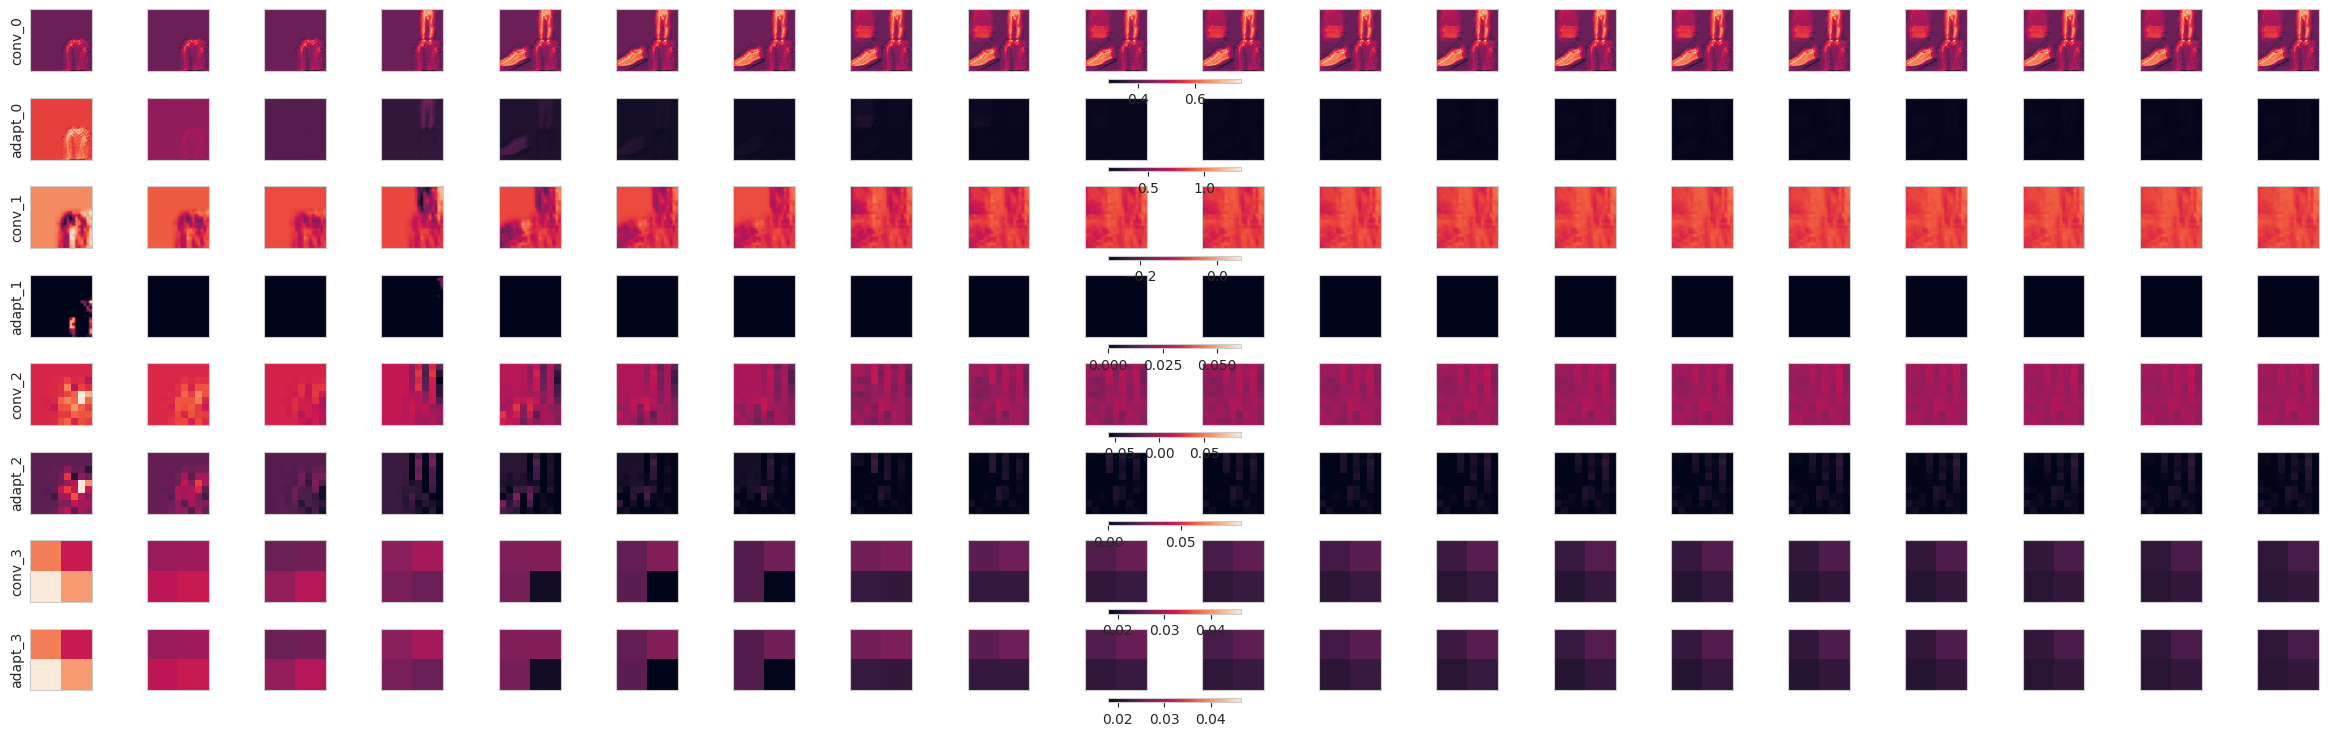

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

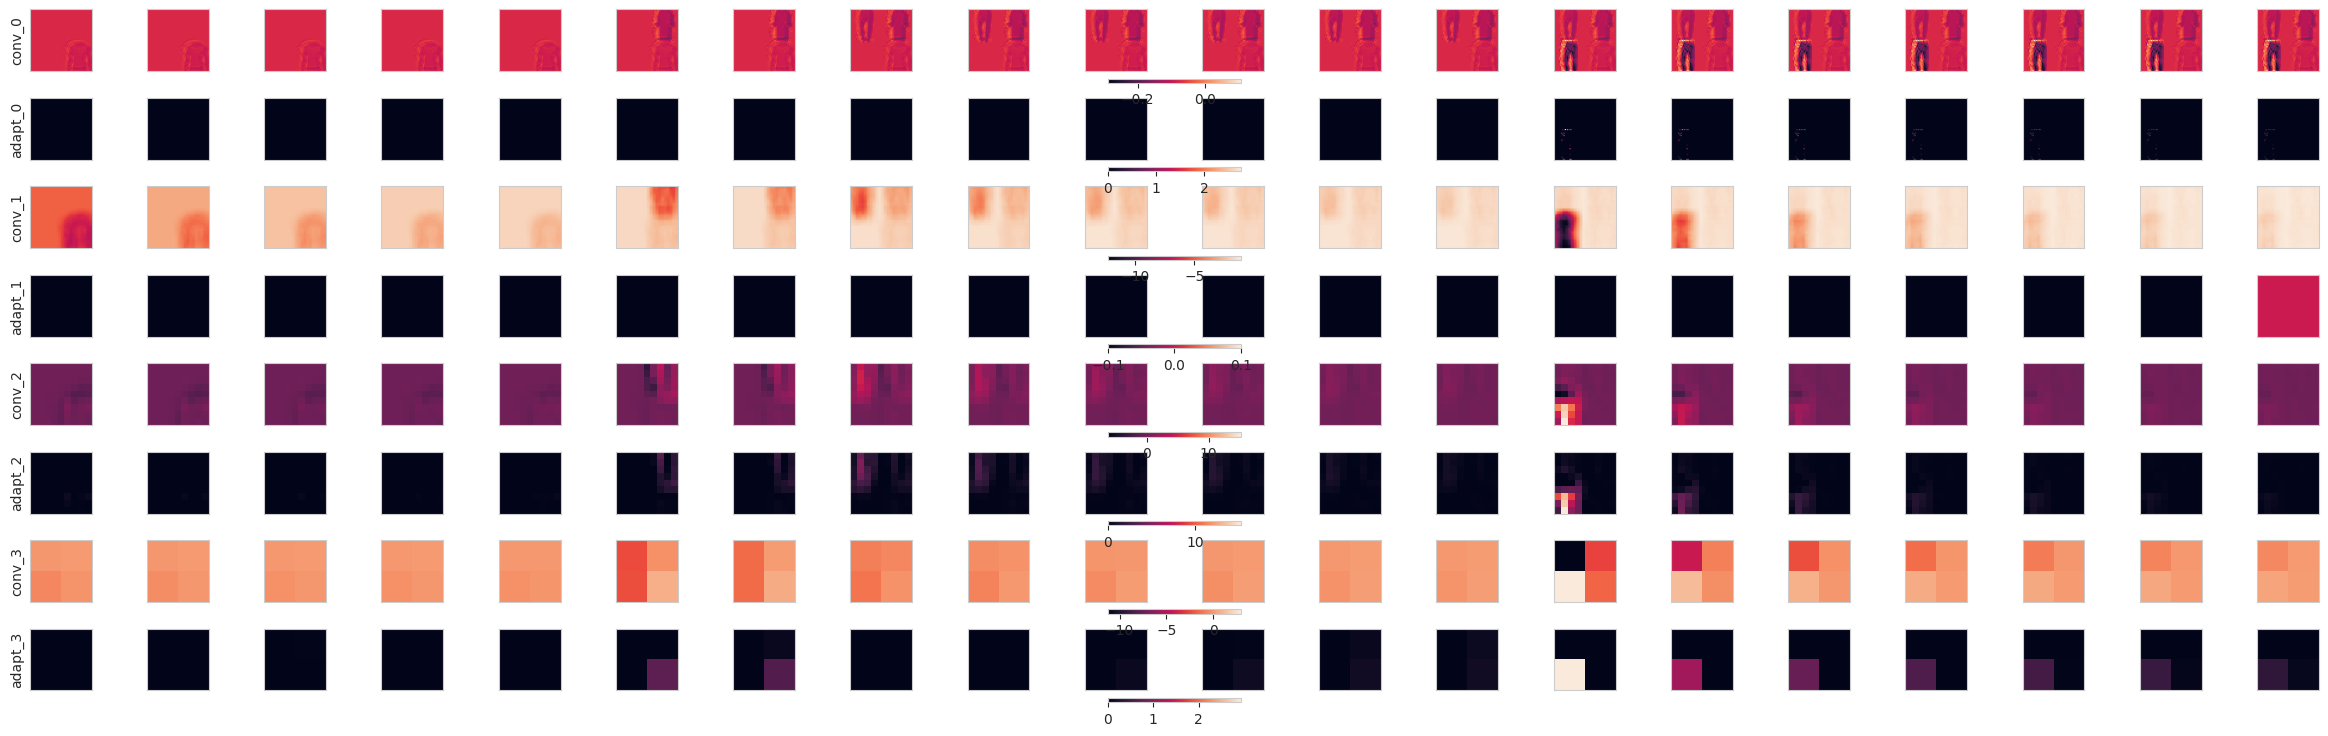

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

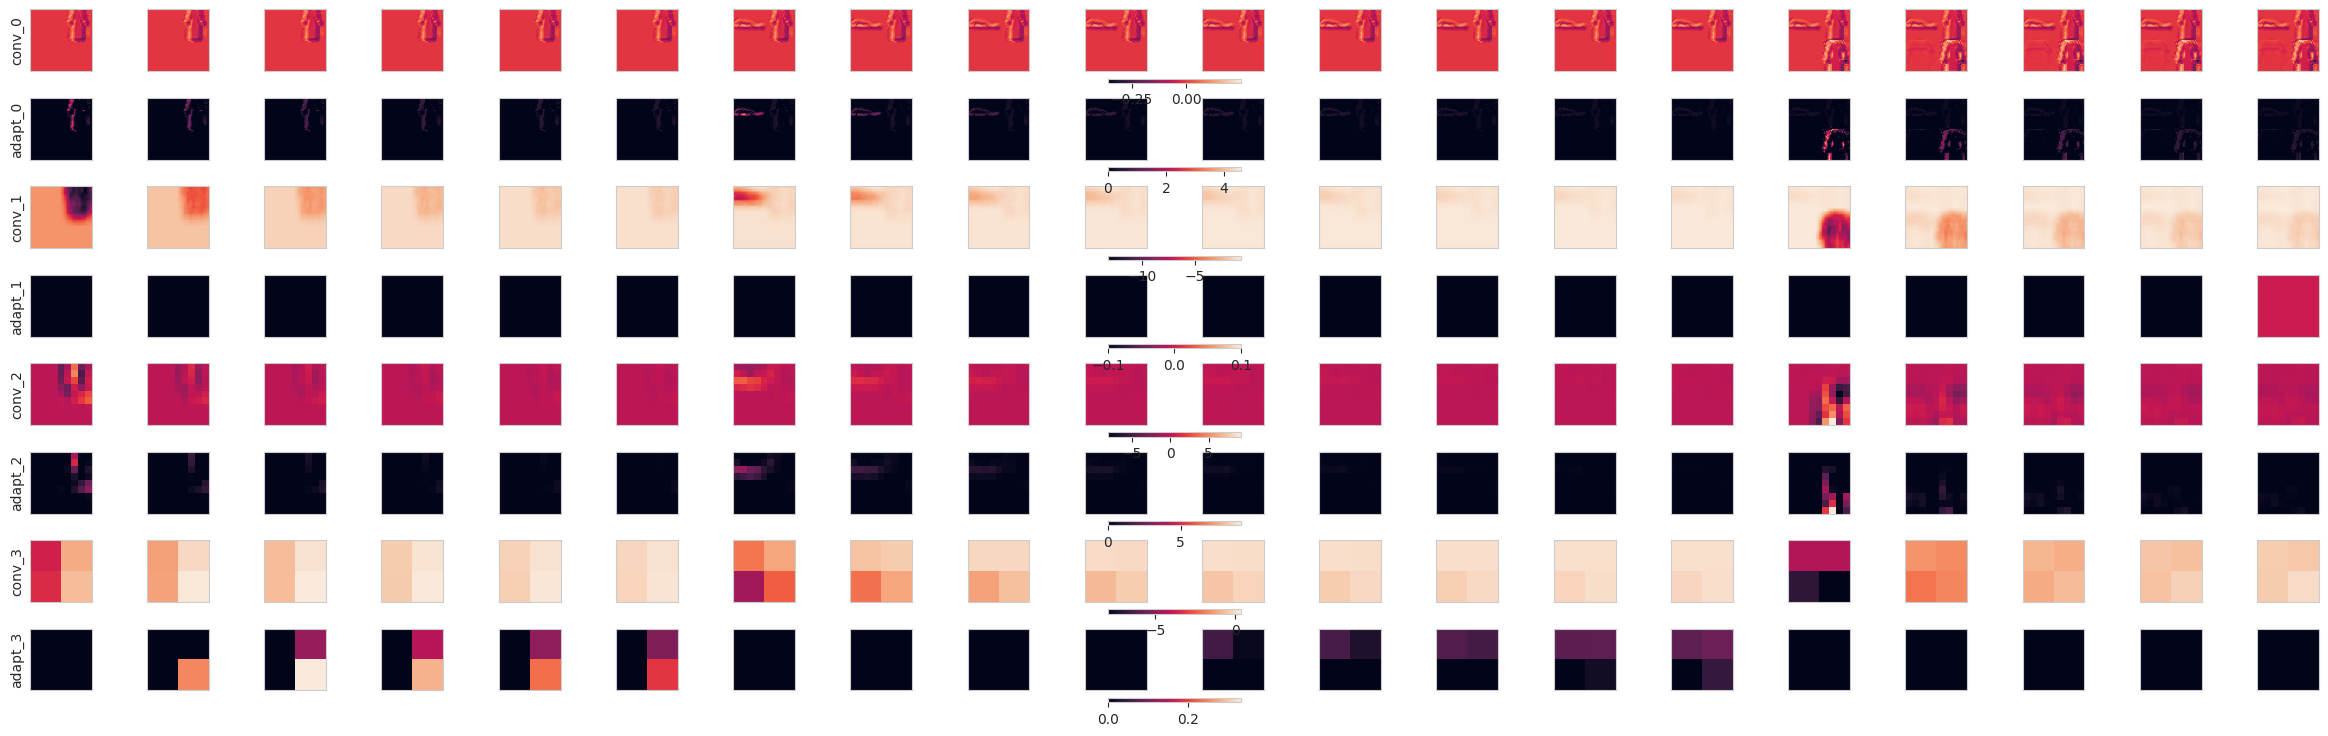

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

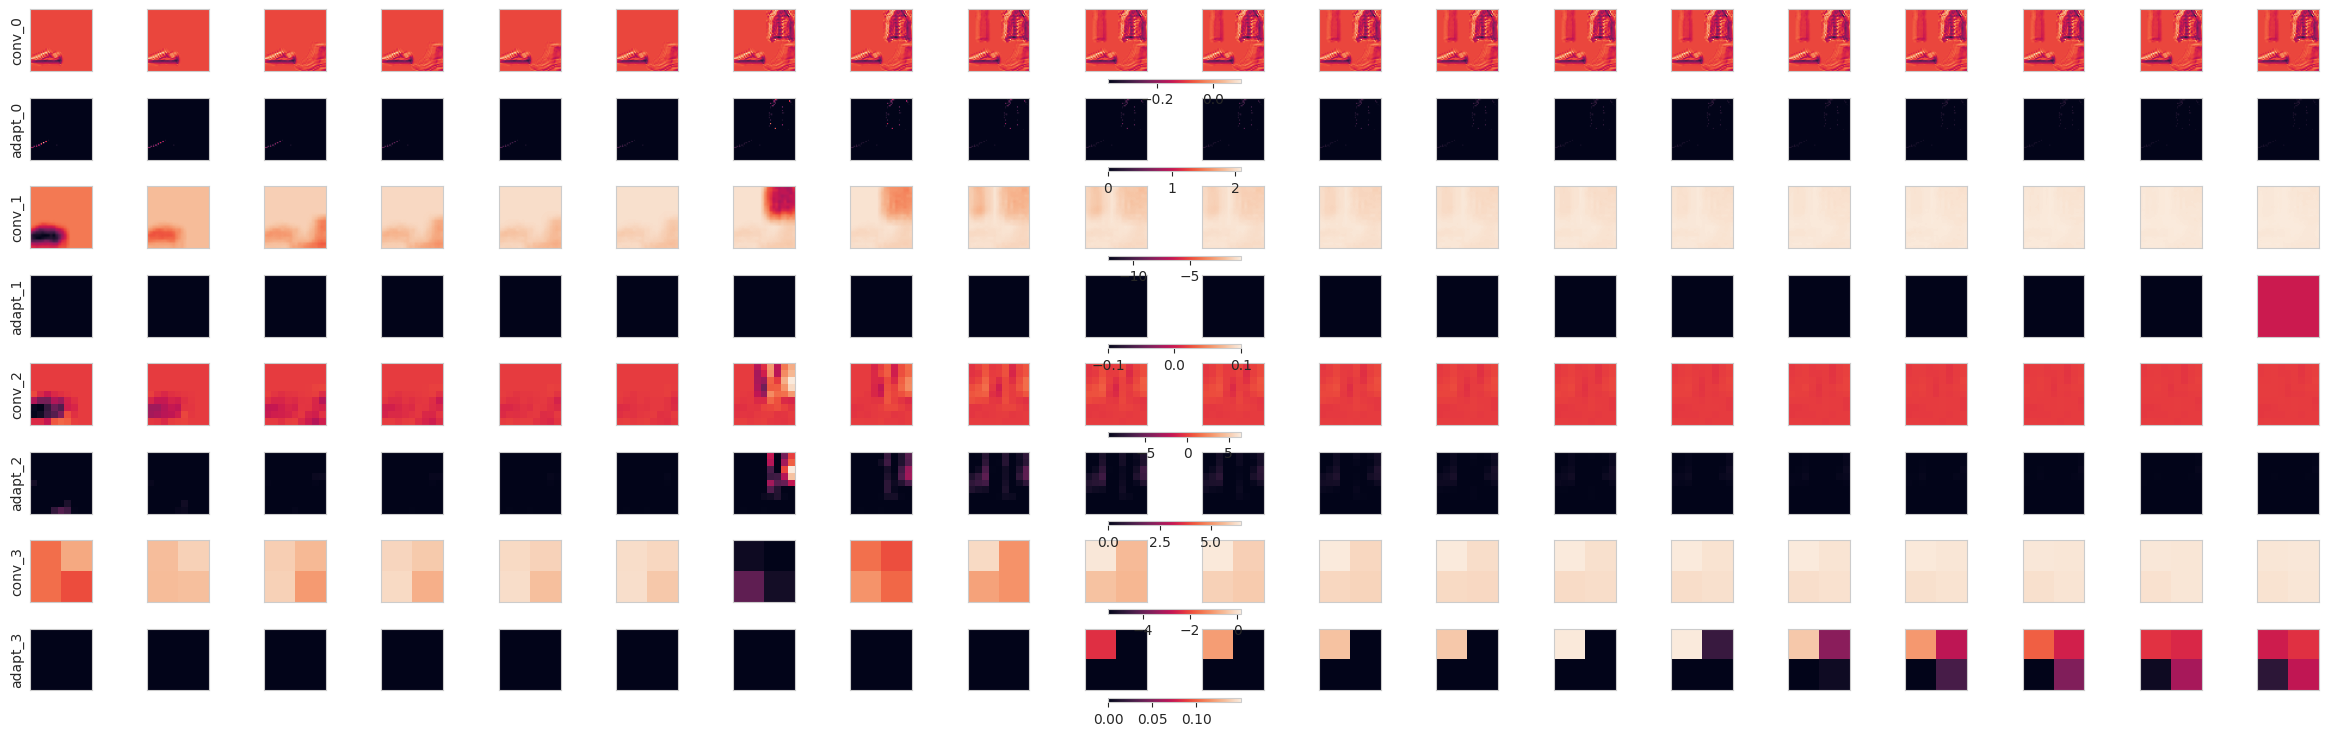

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

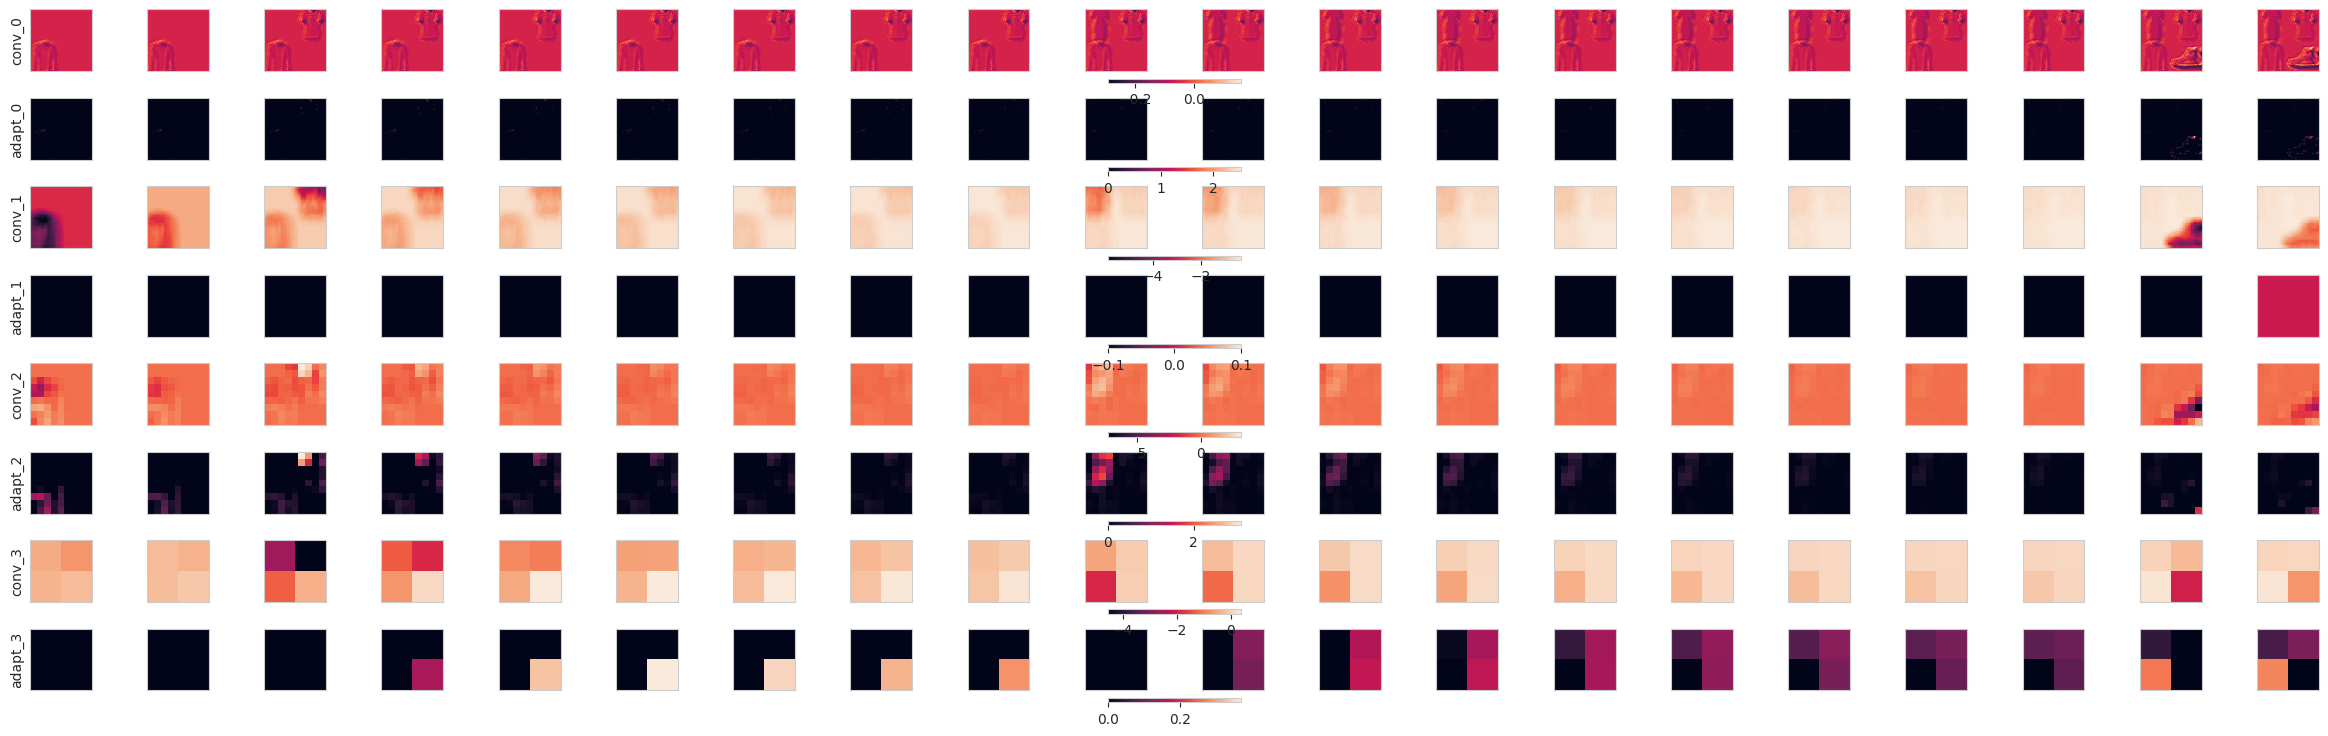

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

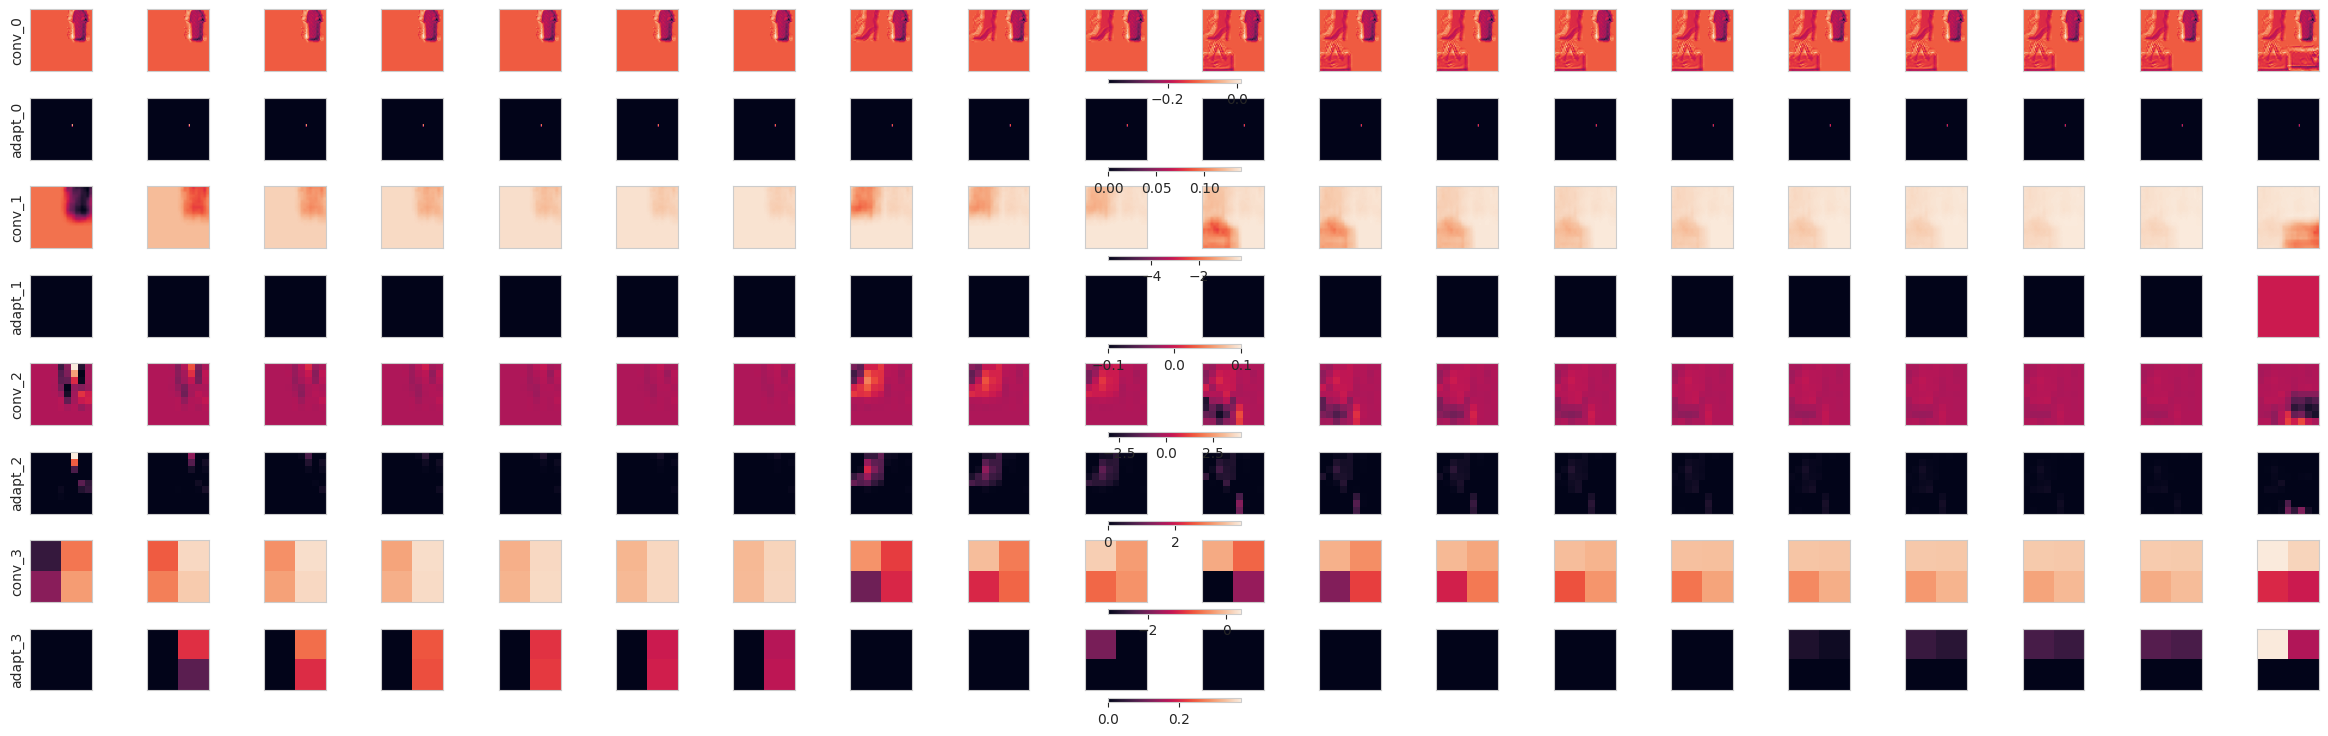

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

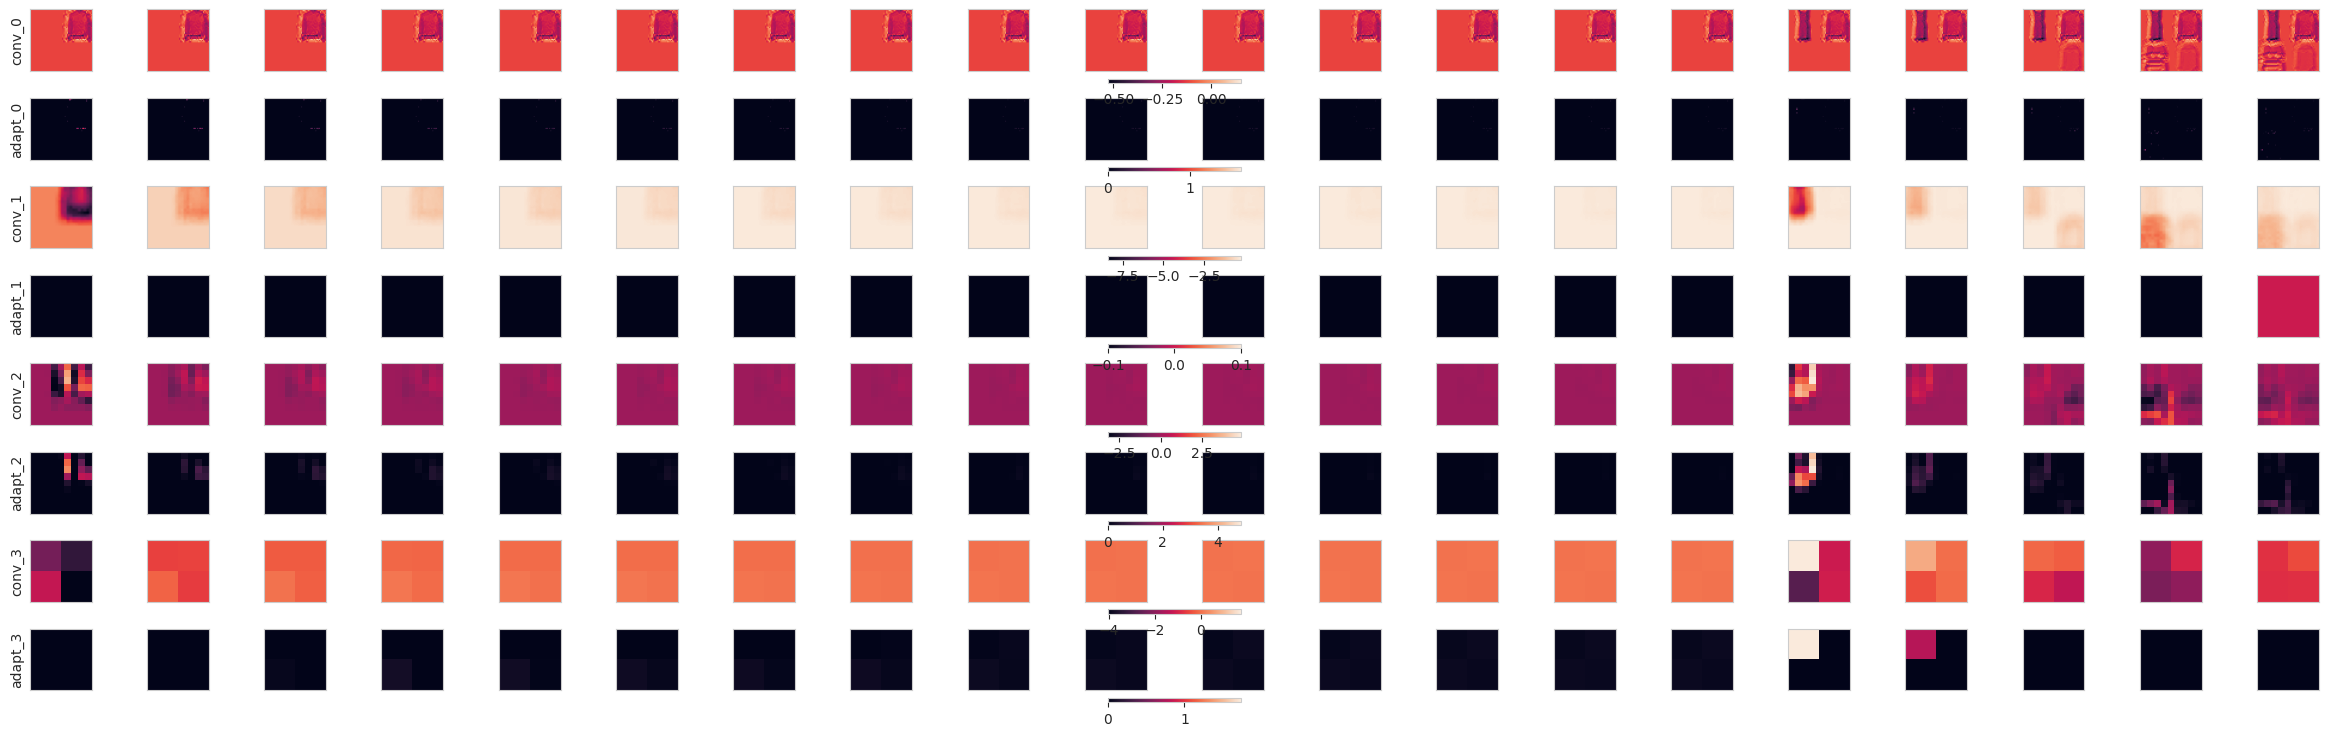

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

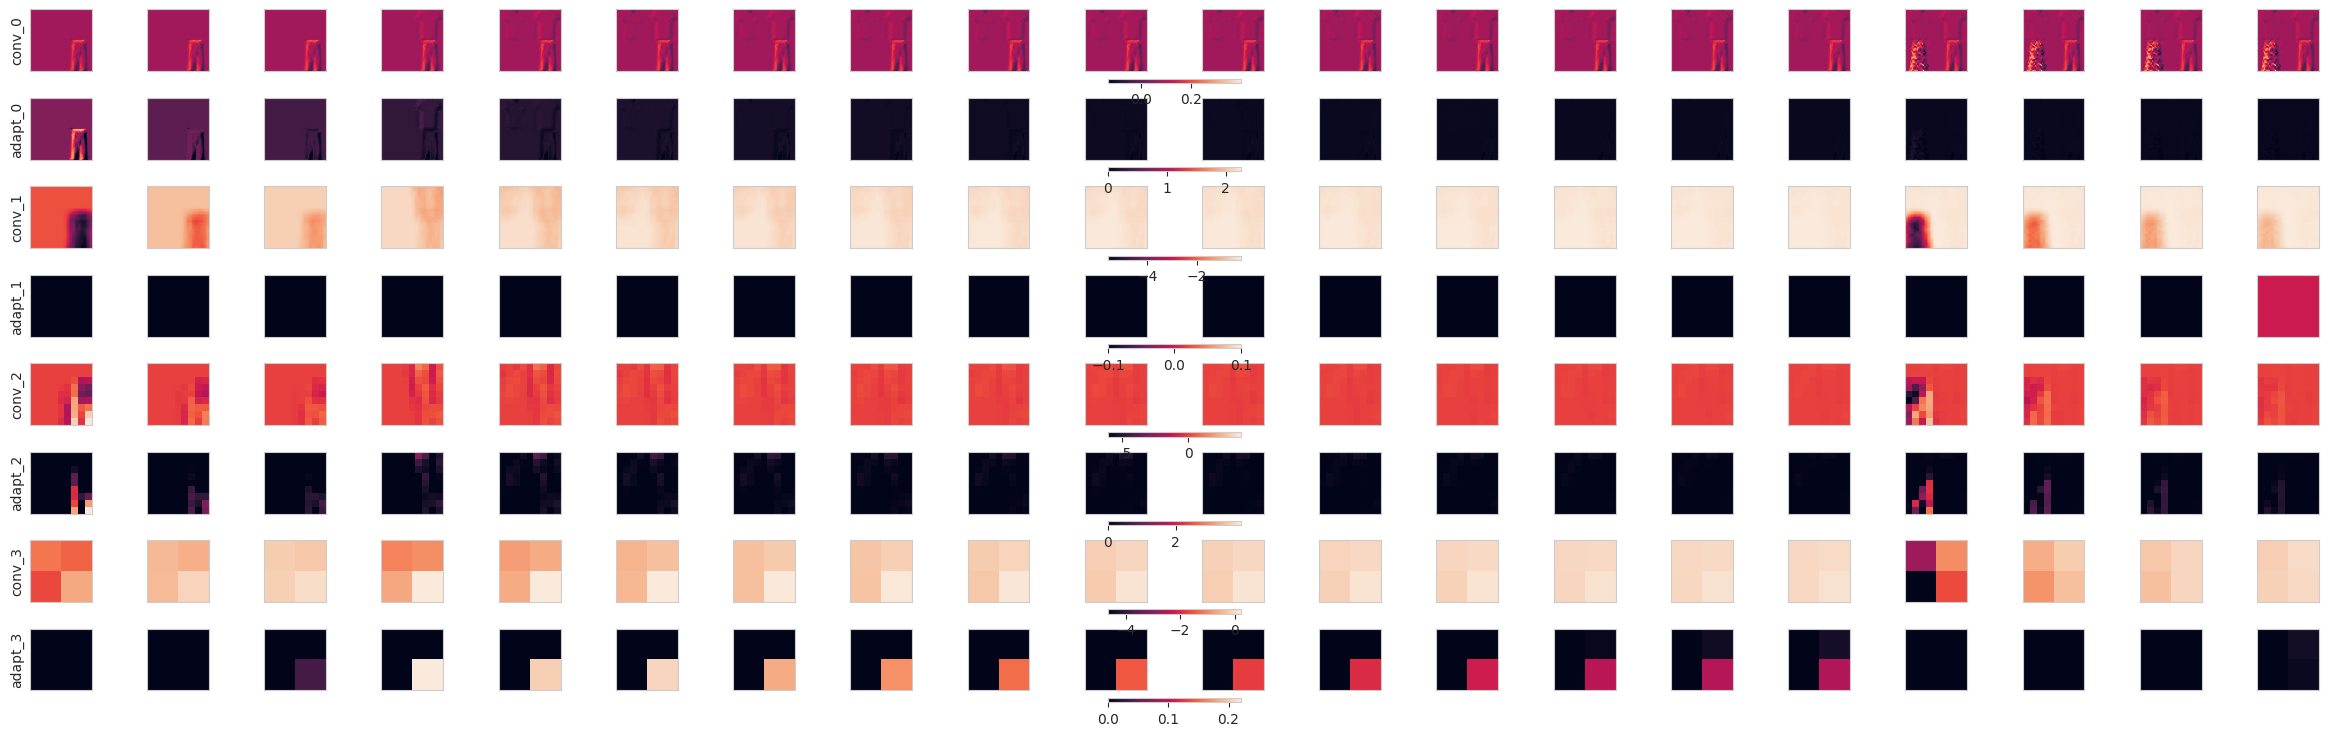

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

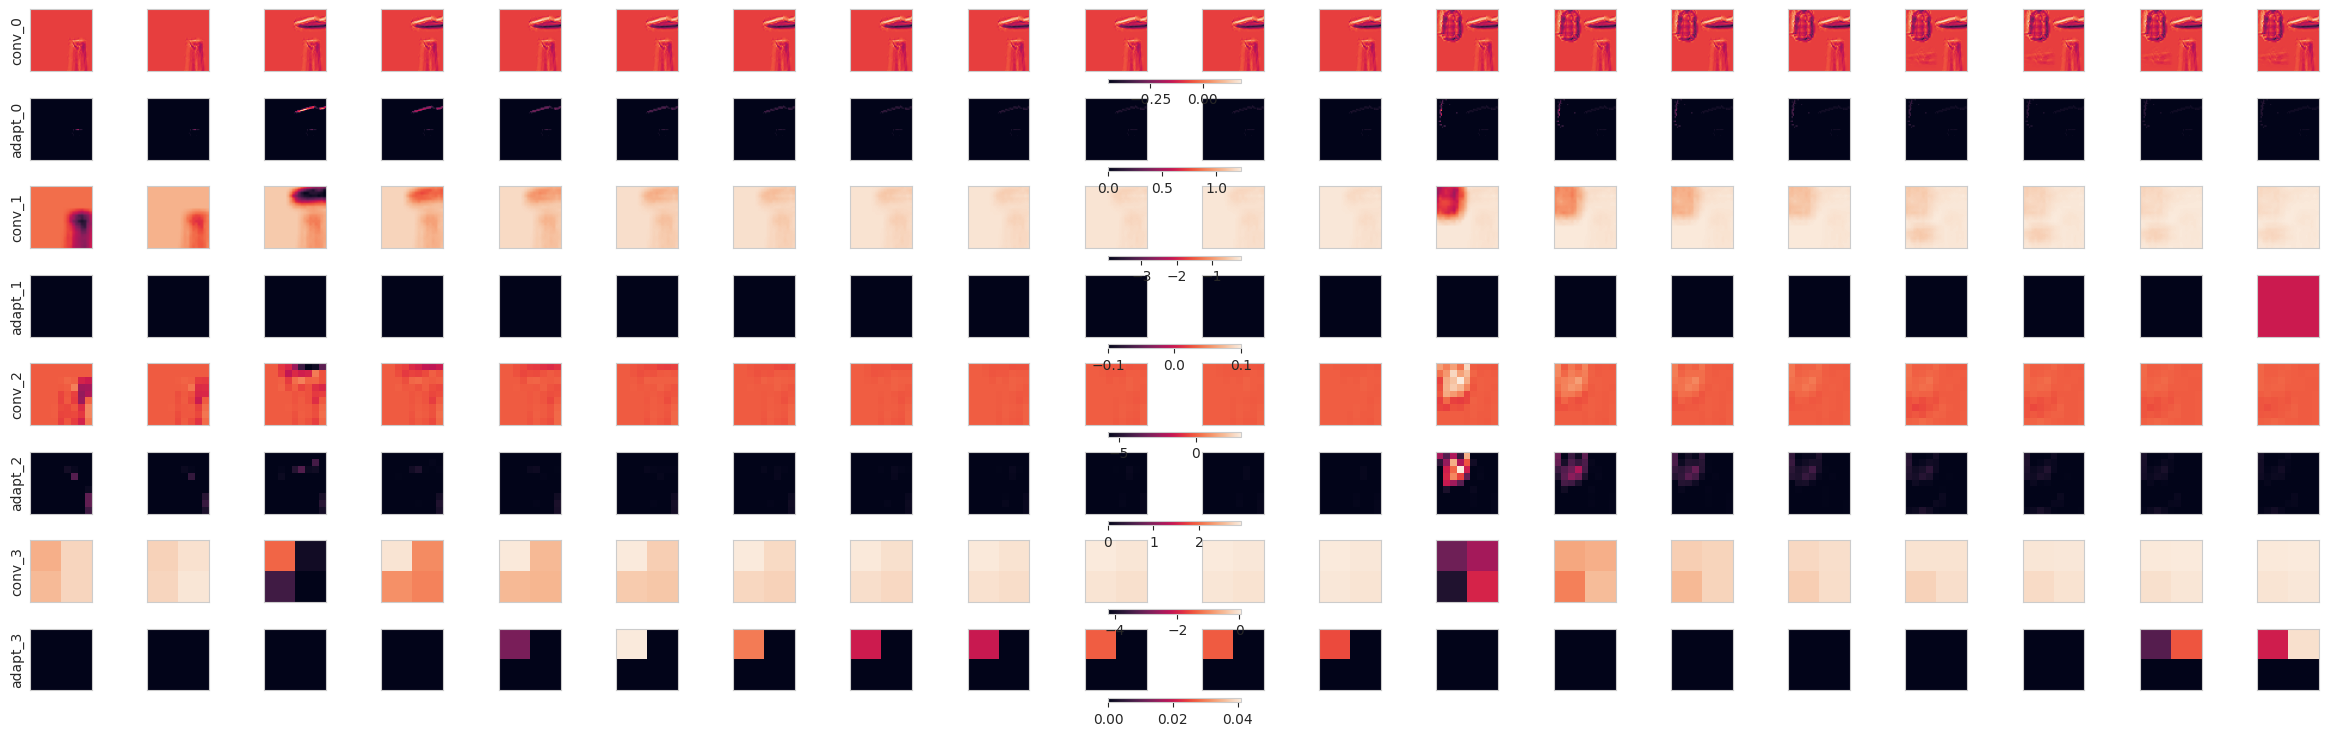

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

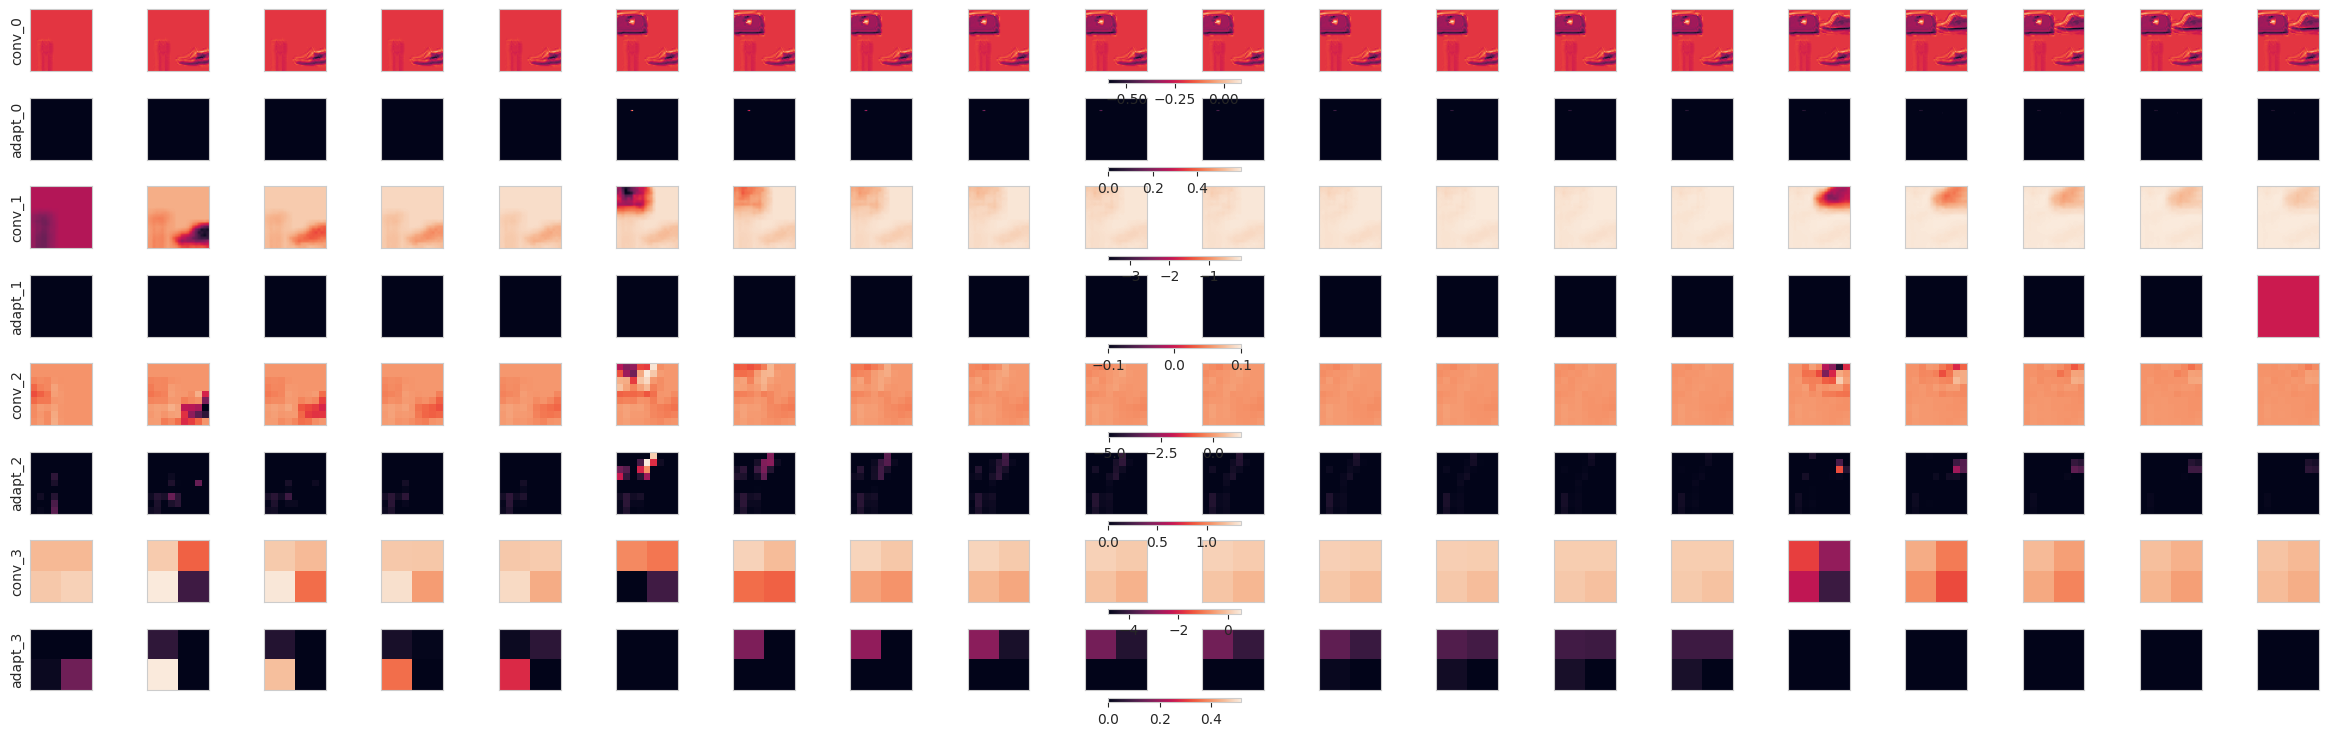

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

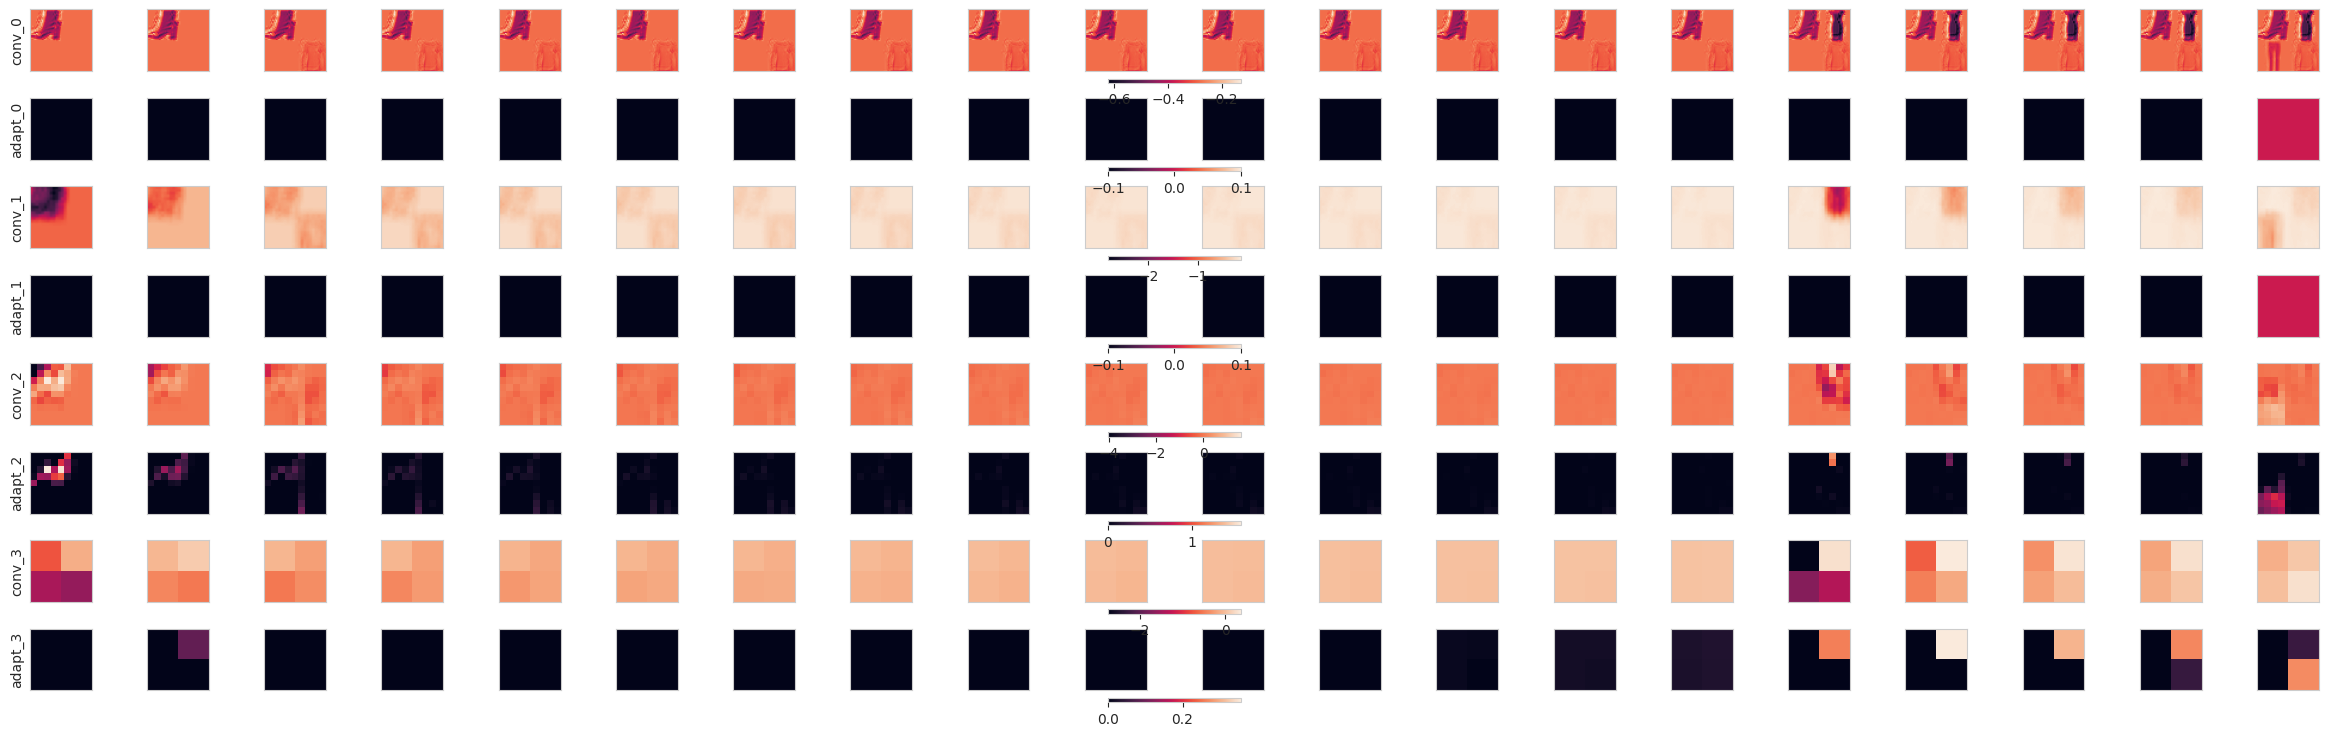

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

`Trainer.fit` stopped: `max_epochs=10` reached.


In [22]:
from modules.lateral_recurrence import LateralRecurrence
from modules.exponential_decay import ExponentialDecay
from modules.divisive_norm import DivisiveNorm
from modules.divisive_norm_group import DivisiveNormGroup
from modules.div_norm_channel import DivisiveNormChannel
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
import pytorch_lightning as pl
import json
from models.adaptation import Adaptation
from HookedRecursiveCNN import HookedRecursiveCNN

config_path = 'config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

dataset = config["dataset"]
if config["dataset"] == 'fashion_mnist':
    layer_kwargs = config["layer_kwargs_fmnist"]
elif config["dataset"] == 'cifar10':
    layer_kwargs = config["layer_kwargs_cifar10"]

# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

logger = CSVLogger(config["log_dir"], name=config["log_name"])

if config["adaptation_module"] == 'LateralRecurrence':
    adaptation_module = LateralRecurrence
    adaptation_kwargs = config["adaptation_kwargs_lateral"]
elif config["adaptation_module"] == 'ExponentialDecay':
    adaptation_module = ExponentialDecay
    adaptation_kwargs = config["adaptation_kwargs_additive"]
elif config["adaptation_module"] == 'DivisiveNorm':
    adaptation_module = DivisiveNorm
    adaptation_kwargs = config["adaptation_kwargs_div_norm"]
elif config["adaptation_module"] == 'DivisiveNormGroup':
    adaptation_module = DivisiveNormGroup
    adaptation_kwargs = config["adaptation_kwargs_div_norm_group"]
elif config["adaptation_module"] == 'DivisiveNormChannel':
    adaptation_module = DivisiveNormChannel
    adaptation_kwargs = config["adaptation_kwargs_div_norm_channel"]
else:
    raise ValueError(f'Adaptation module {config["adaptation_module"]} not implemented')

t_steps = 20

num_epoch = 10

layer_kwargs = [{'in_channels': 1, 'out_channels': 32, 'kernel_size': 5},
 {'in_channels': 32, 'out_channels': 32, 'kernel_size': 5},
 {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
 {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
 {'in_features': 128, 'out_features': 1024}]
adaptation_kwargs = [
    {"epsilon":  1e-8, "K_init":  0.2, "train_K":  True, "alpha_init":  -2.0, "train_alpha": True, "sigma_init": 0.1, "train_sigma": True},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  -2000000.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  -2000000.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  -2000000.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  0.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False}
  ]

hooked_model = HookedRecursiveCNN(t_steps=t_steps, layer_kwargs=layer_kwargs,
                                  adaptation_module=adaptation_module,
                                  adaptation_kwargs=adaptation_kwargs, decode_every_timestep=True)
model = Adaptation(hooked_model, lr=config["lr"], contrast_metrics=False)

contrast = 'random'
tb_logger = TensorBoardLogger("lightning_logs",
                              name=f'video_{config["adaptation_module"]}_001',
                              version=f'videon_{config["adaptation_module"]}_001')

# wandb.init(project='ai-thesis', config=config, entity='ai-thesis', name=f'{config["log_name"]}_{config["adaptation_module"]}_c_{contrast}_rep_{repeat_noise}_ep_{num_epoch}')
wandb_logger = pl.loggers.WandbLogger(project='ai-thesis', config=config,
                                      name=f'video_fmnist_002_{config["adaptation_module"]}_c_{contrast}_ep_{num_epoch}_{config["log_name"]}')

trainer = pl.Trainer(max_epochs=num_epoch, logger=wandb_logger)
# test_results = trainer.test(model, dataloaders=test_loader)
wandb_logger.watch(hooked_model, log='all', log_freq=1000)

trainer.fit(model, train_loader, test_loader)

# test
# test_results = trainer.test(model, dataloaders=train_loader)
# logger.log_metrics({'contrast': contrast, 'epoch': num_epoch, 'repeat_noise': 'n/a',
#                     'test_acc': test_results[0]["test_acc"]})
# logger.save()

trainer.save_checkpoint(
    f'learned_models/video_fmnist_{config["adaptation_module"]}_contrast_{contrast}_epoch_{num_epoch}.ckpt')

# Train Exponential Decay

In [ ]:
# Create instances of the Fashion MNIST dataset
train_dataset = TemporalDataset('train', transform=transform,
                                img_to_timesteps_transforms=timestep_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)

test_loader = DataLoader(EvalDataWrapper(train_dataset, contrast=1, rep_noise=False), batch_size=64, shuffle=True,
                         num_workers=3)
config_path = 'config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

dataset = config["dataset"]
if config["dataset"] == 'fashion_mnist':
    layer_kwargs = config["layer_kwargs_fmnist"]
elif config["dataset"] == 'cifar10':
    layer_kwargs = config["layer_kwargs_cifar10"]
    
config['adaptation_module'] = 'ExponentialDecay'

# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

logger = CSVLogger(config["log_dir"], name=config["log_name"])

if config["adaptation_module"] == 'LateralRecurrence':
    adaptation_module = LateralRecurrence
    adaptation_kwargs = config["adaptation_kwargs_lateral"]
elif config["adaptation_module"] == 'ExponentialDecay':
    adaptation_module = ExponentialDecay
    adaptation_kwargs = config["adaptation_kwargs_additive"]
elif config["adaptation_module"] == 'DivisiveNorm':
    adaptation_module = DivisiveNorm
    adaptation_kwargs = config["adaptation_kwargs_div_norm"]
elif config["adaptation_module"] == 'DivisiveNormGroup':
    adaptation_module = DivisiveNormGroup
    adaptation_kwargs = config["adaptation_kwargs_div_norm_group"]
elif config["adaptation_module"] == 'DivisiveNormChannel':
    adaptation_module = DivisiveNormChannel
    adaptation_kwargs = config["adaptation_kwargs_div_norm_channel"]
else:
    raise ValueError(f'Adaptation module {config["adaptation_module"]} not implemented')

t_steps = 20

num_epoch = 10

layer_kwargs = [{'in_channels': 1, 'out_channels': 32, 'kernel_size': 5},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 5},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
                {'in_features': 128, 'out_features': 1024}]
adaptation_kwargs = [
    {"alpha_init":  0.5, "train_alpha": True, "beta_init": 1, "train_beta": True},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False}
  ]

hooked_model = HookedRecursiveCNN(t_steps=t_steps, layer_kwargs=layer_kwargs,
                                  adaptation_module=adaptation_module,
                                  adaptation_kwargs=adaptation_kwargs, decode_every_timestep=True)
model = Adaptation(hooked_model, lr=config["lr"], contrast_metrics=False)

contrast = 'random'
tb_logger = TensorBoardLogger("lightning_logs",
                              name=f'video_{config["adaptation_module"]}_001',
                              version=f'videon_{config["adaptation_module"]}_001')

# wandb.init(project='ai-thesis', config=config, entity='ai-thesis', name=f'{config["log_name"]}_{config["adaptation_module"]}_c_{contrast}_rep_{repeat_noise}_ep_{num_epoch}')
wandb_logger = pl.loggers.WandbLogger(project='ai-thesis', config=config,
                                      name=f'video_fmnist_002_{config["adaptation_module"]}_c_{contrast}_ep_{num_epoch}_{config["log_name"]}')

trainer = pl.Trainer(max_epochs=num_epoch, logger=wandb_logger)
# test_results = trainer.test(model, dataloaders=test_loader)
wandb_logger.watch(hooked_model, log='all', log_freq=1000)

trainer.fit(model, train_loader, test_loader)

# test
# test_results = trainer.test(model, dataloaders=train_loader)
# logger.log_metrics({'contrast': contrast, 'epoch': num_epoch, 'repeat_noise': 'n/a',
#                     'test_acc': test_results[0]["test_acc"]})
# logger.save()

trainer.save_checkpoint(
    f'learned_models/video_fmnist_{config["adaptation_module"]}_contrast_{contrast}_epoch_{num_epoch}.ckpt')

# Train no-time baseline

In [8]:
from modules.lateral_recurrence import LateralRecurrence
from modules.exponential_decay import ExponentialDecay
from modules.divisive_norm import DivisiveNorm
from modules.divisive_norm_group import DivisiveNormGroup
from modules.div_norm_channel import DivisiveNormChannel
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
import pytorch_lightning as pl
import json
from models.adaptation import Adaptation
from HookedRecursiveCNN import HookedRecursiveCNN

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
wandb: Currently logged in as: georglange. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name                         | Type                       | Params
----------------------------------------------------------------------------
0 | model                        | HookedRecursiveCNN         | 187 K 
1 | loss                         | CrossEntropyLoss           | 0     
2 | update_to_weight_metric      | RelativeGradientUpdateNorm | 0     
3 | dead_neurons_counter         | DeadNeuronMetric           | 0     
4 | dead_feature_maps_counter    | DeadNeuronMetric           | 0     
5 | sparsity                     | Sparsity                   | 0     
6 | actv_scale_per_timestep_plot | ActvScalePerTimestepPlot   | 0     
----------------------------------------------------------------------------
187 K     Train

Sanity Checking: 0it [00:00, ?it/s]

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


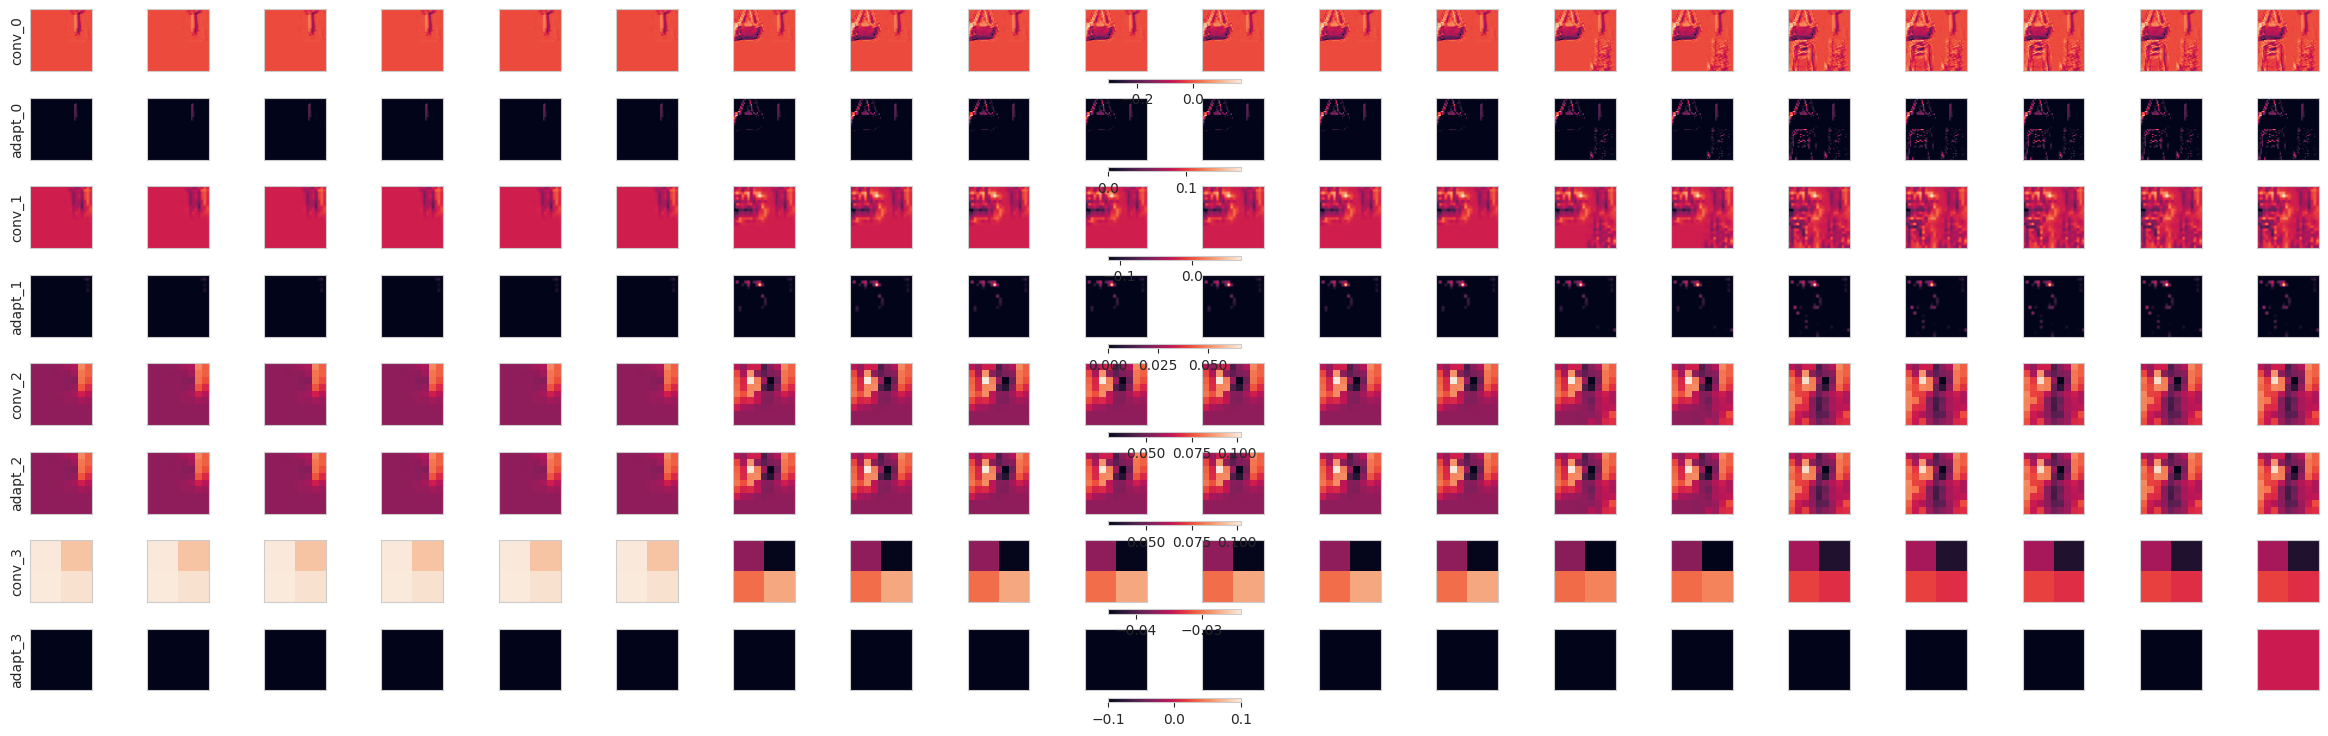

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

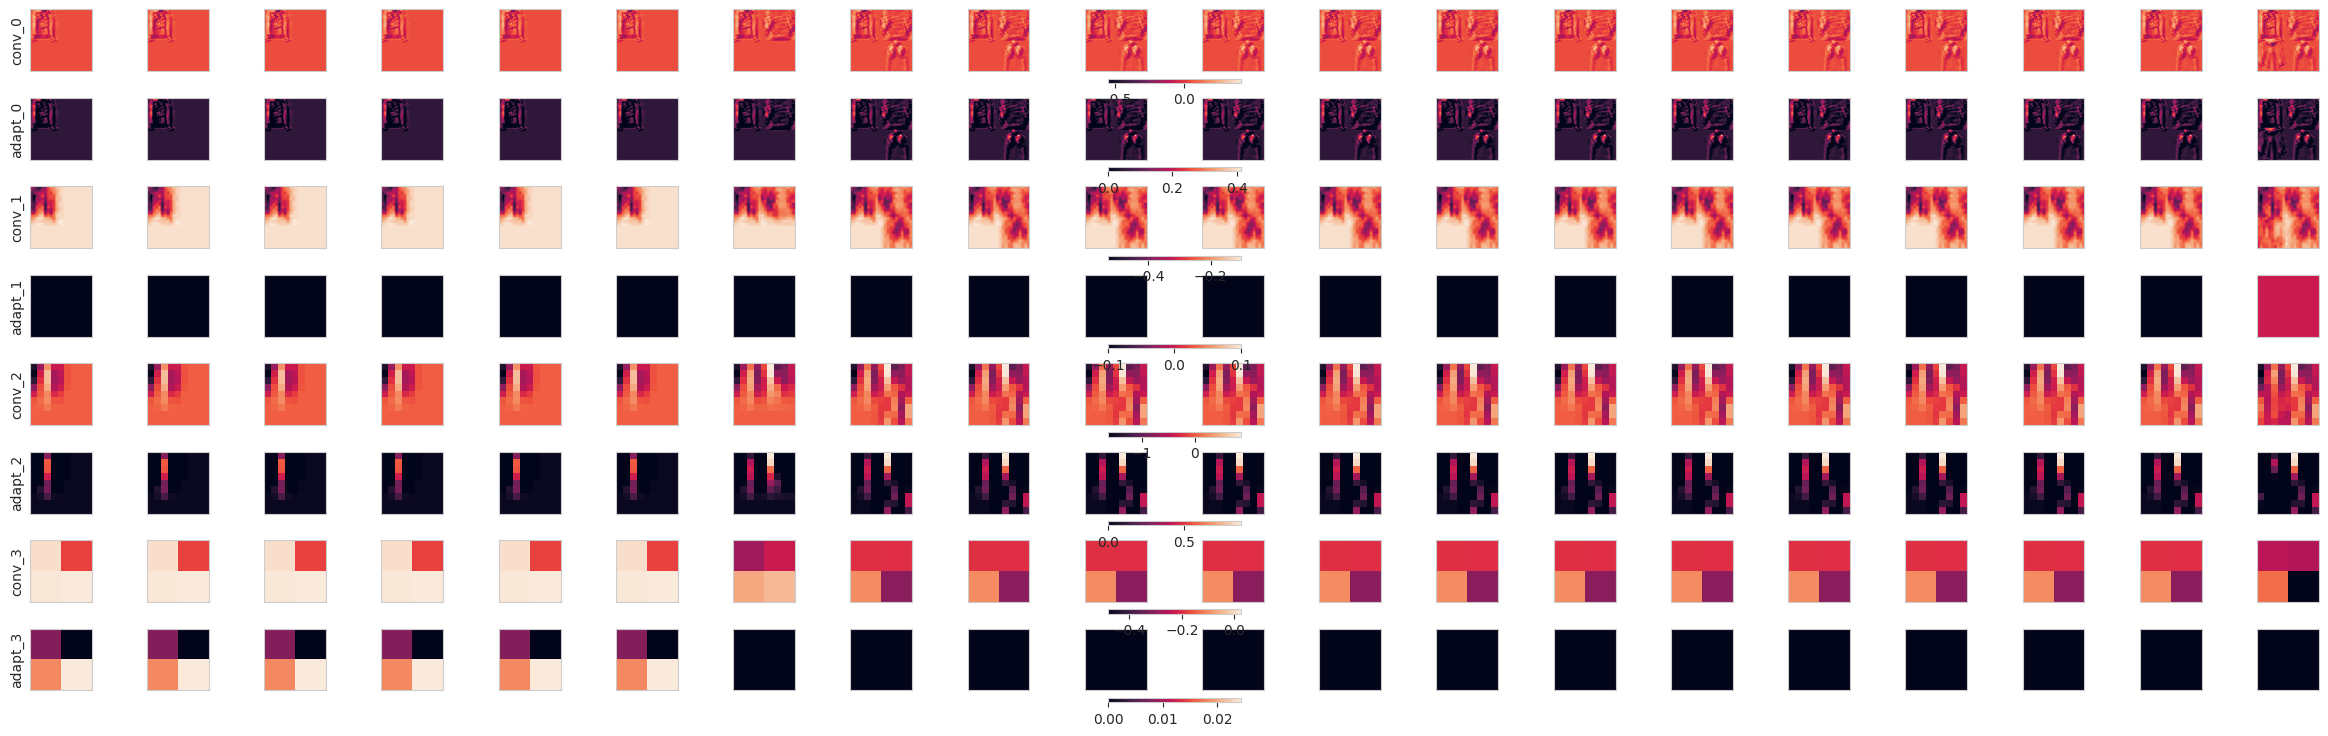

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

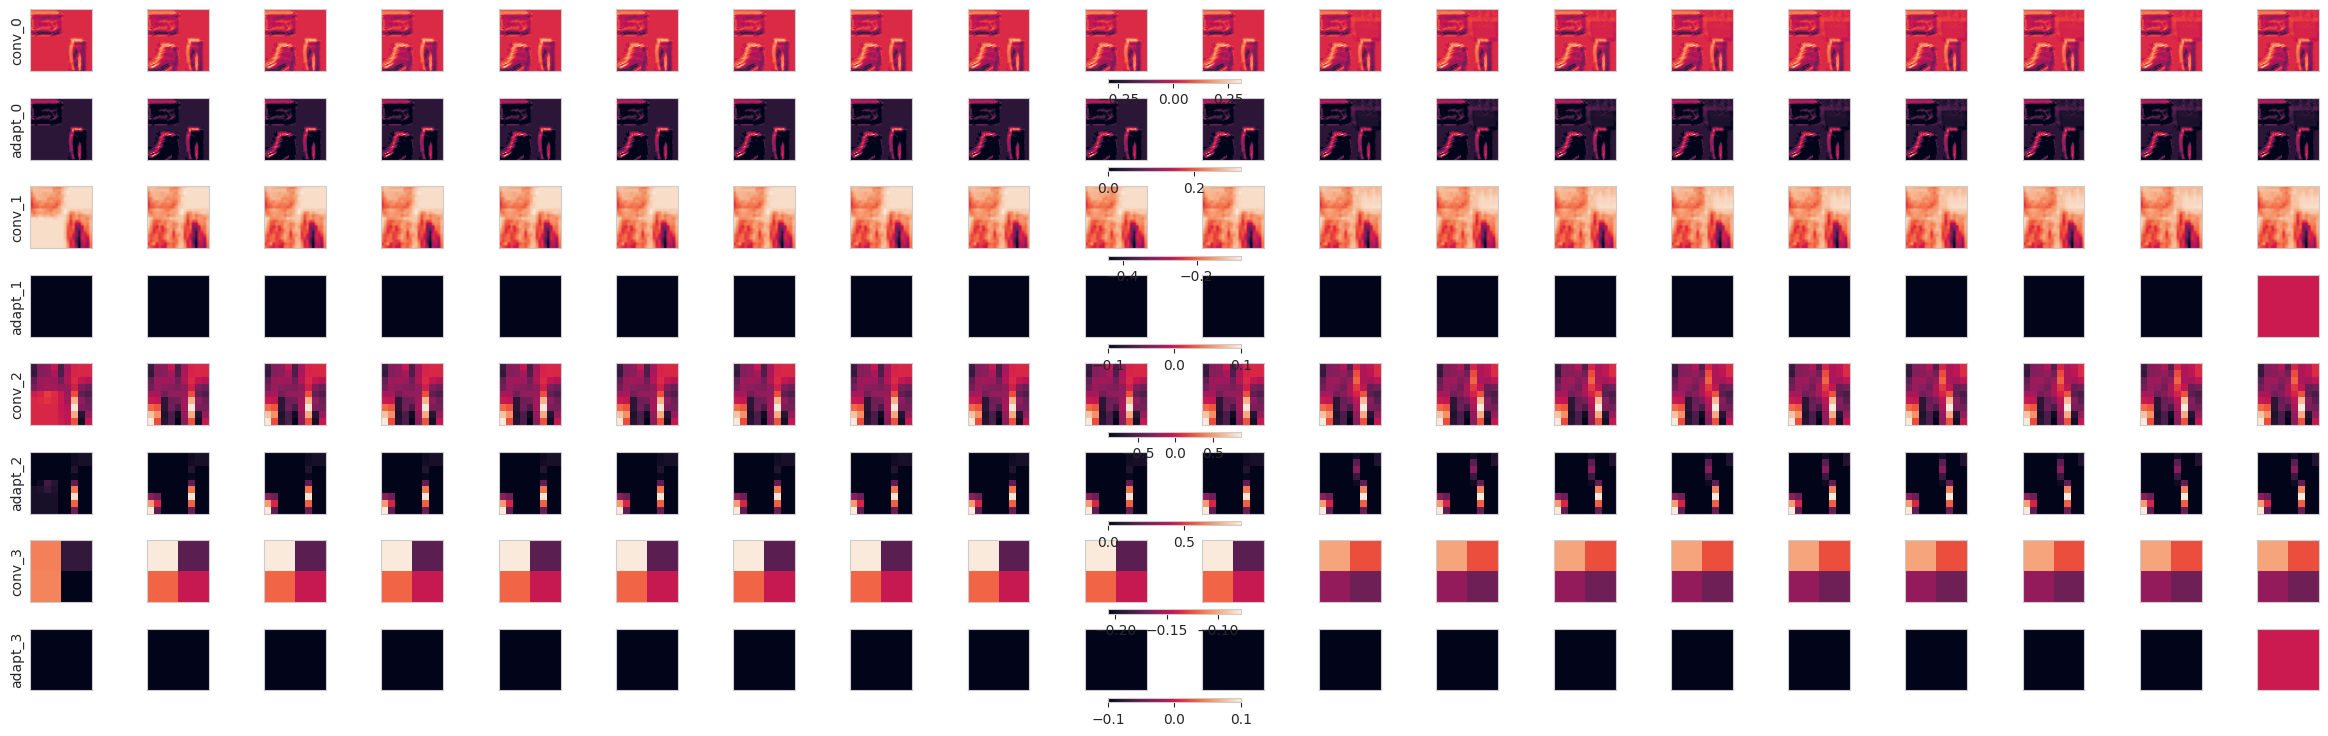

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

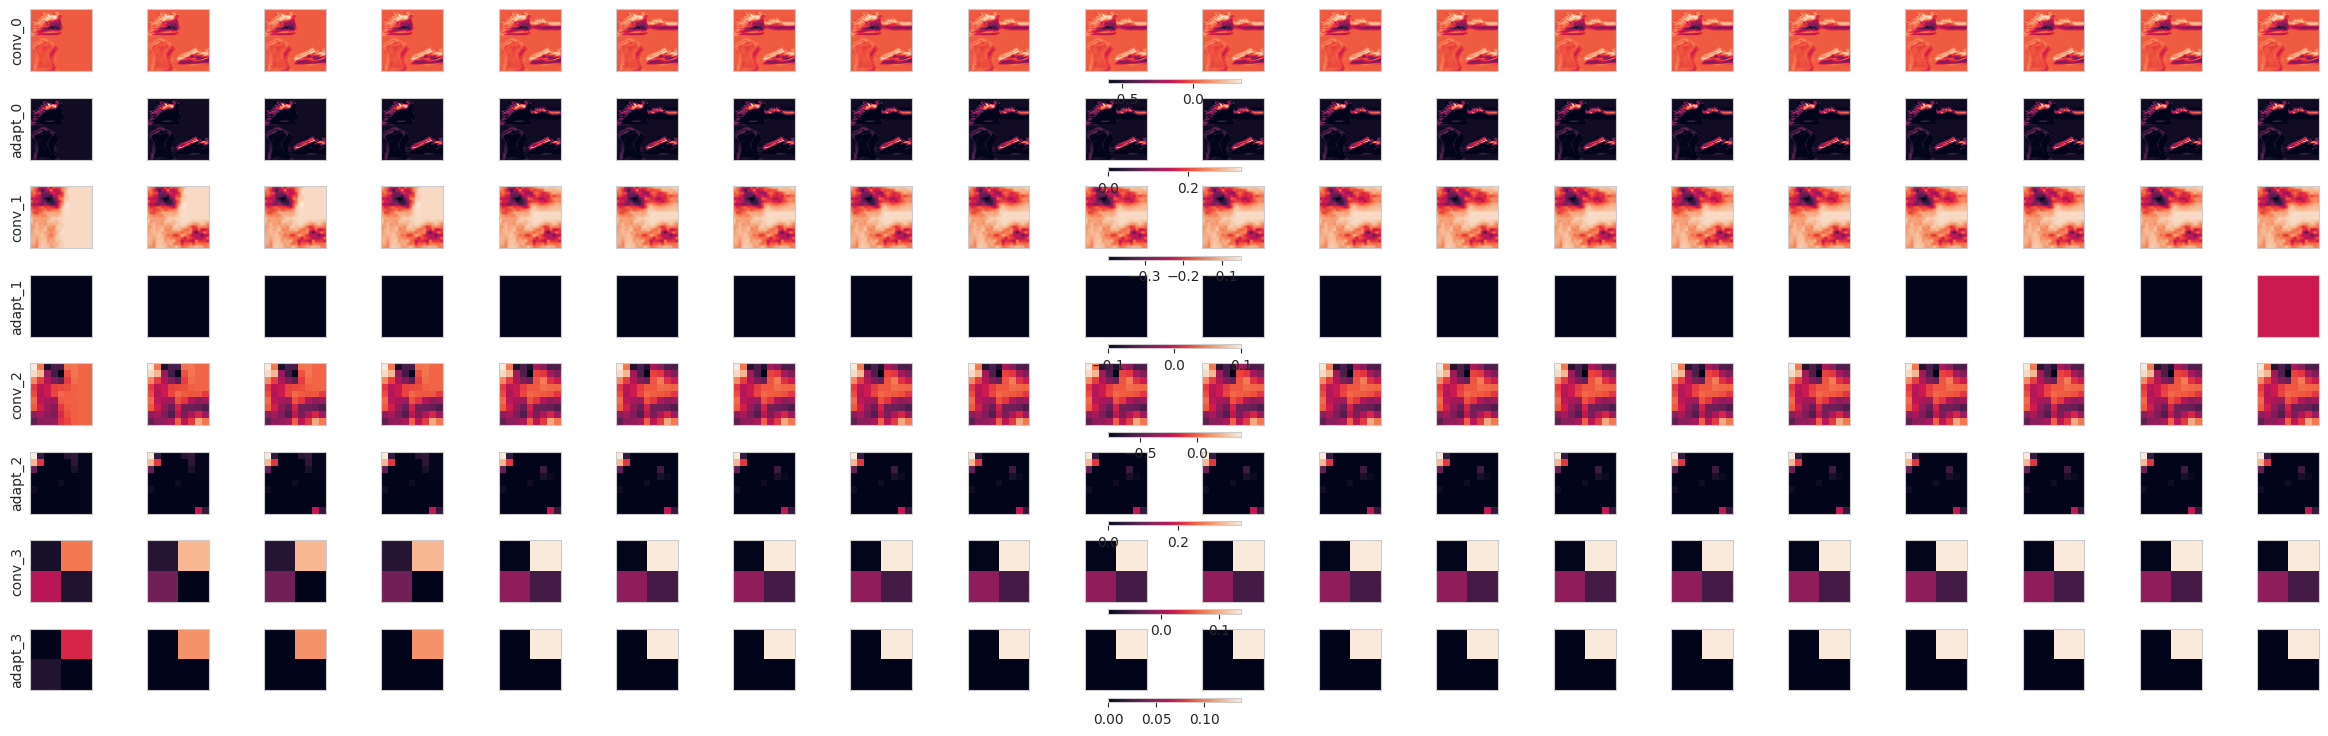

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

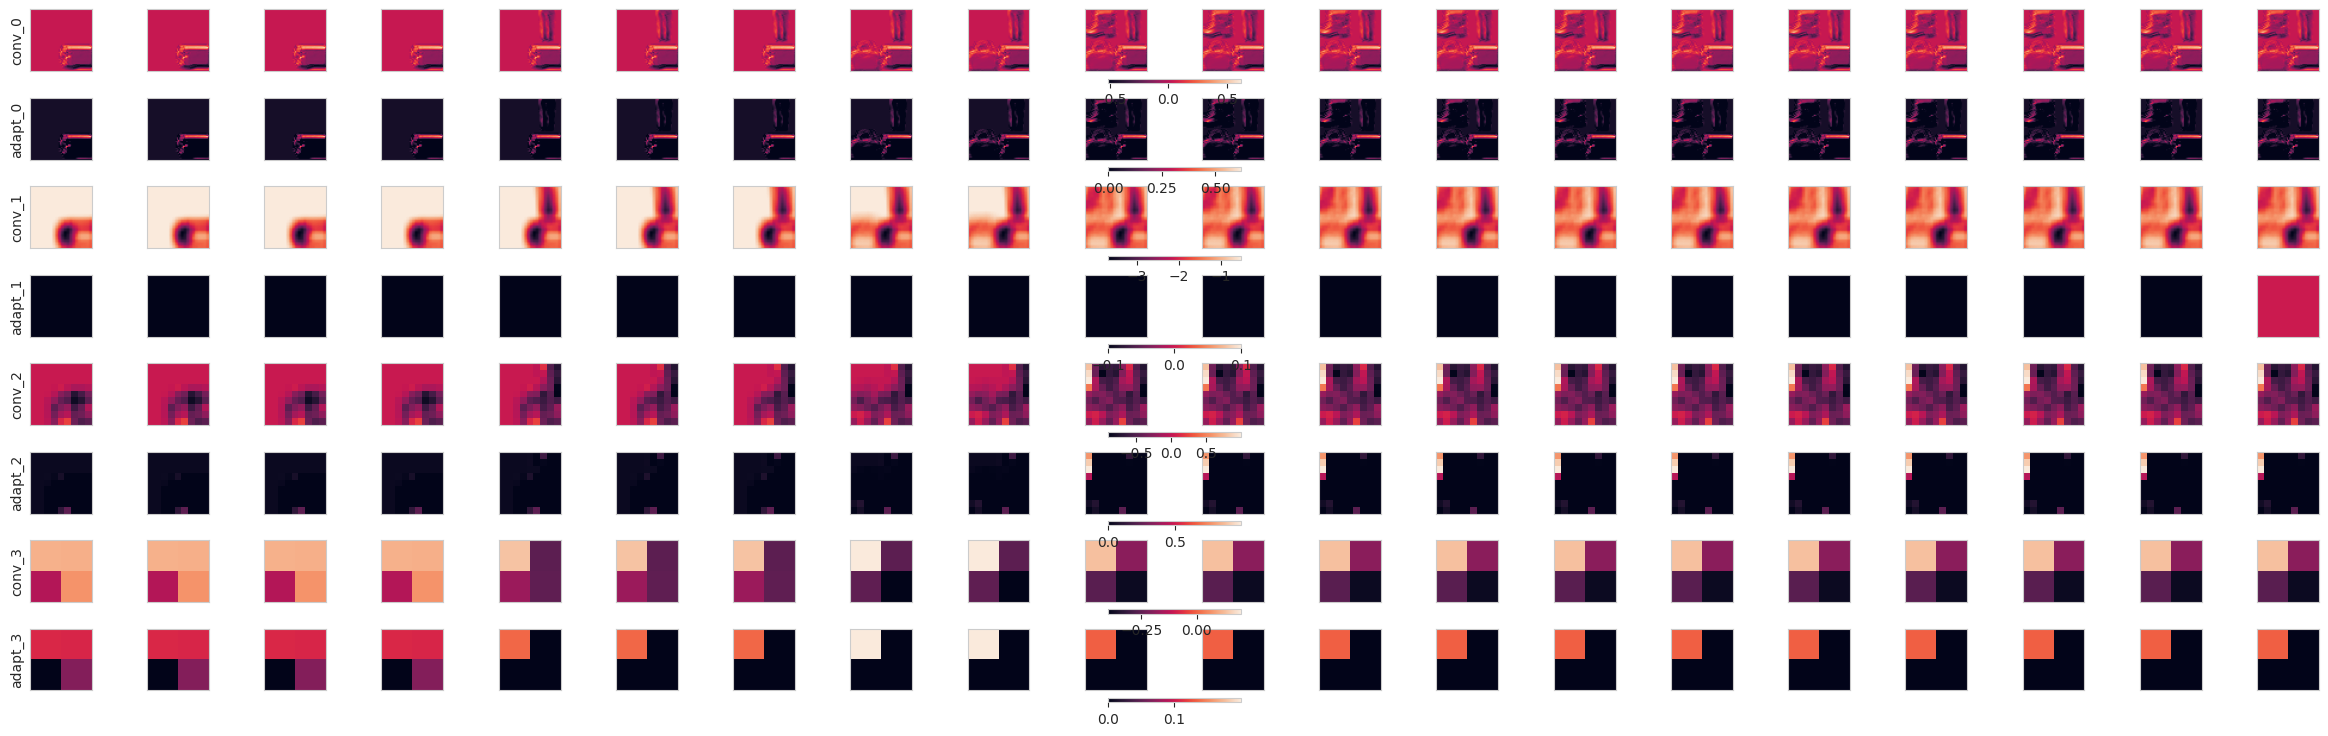

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

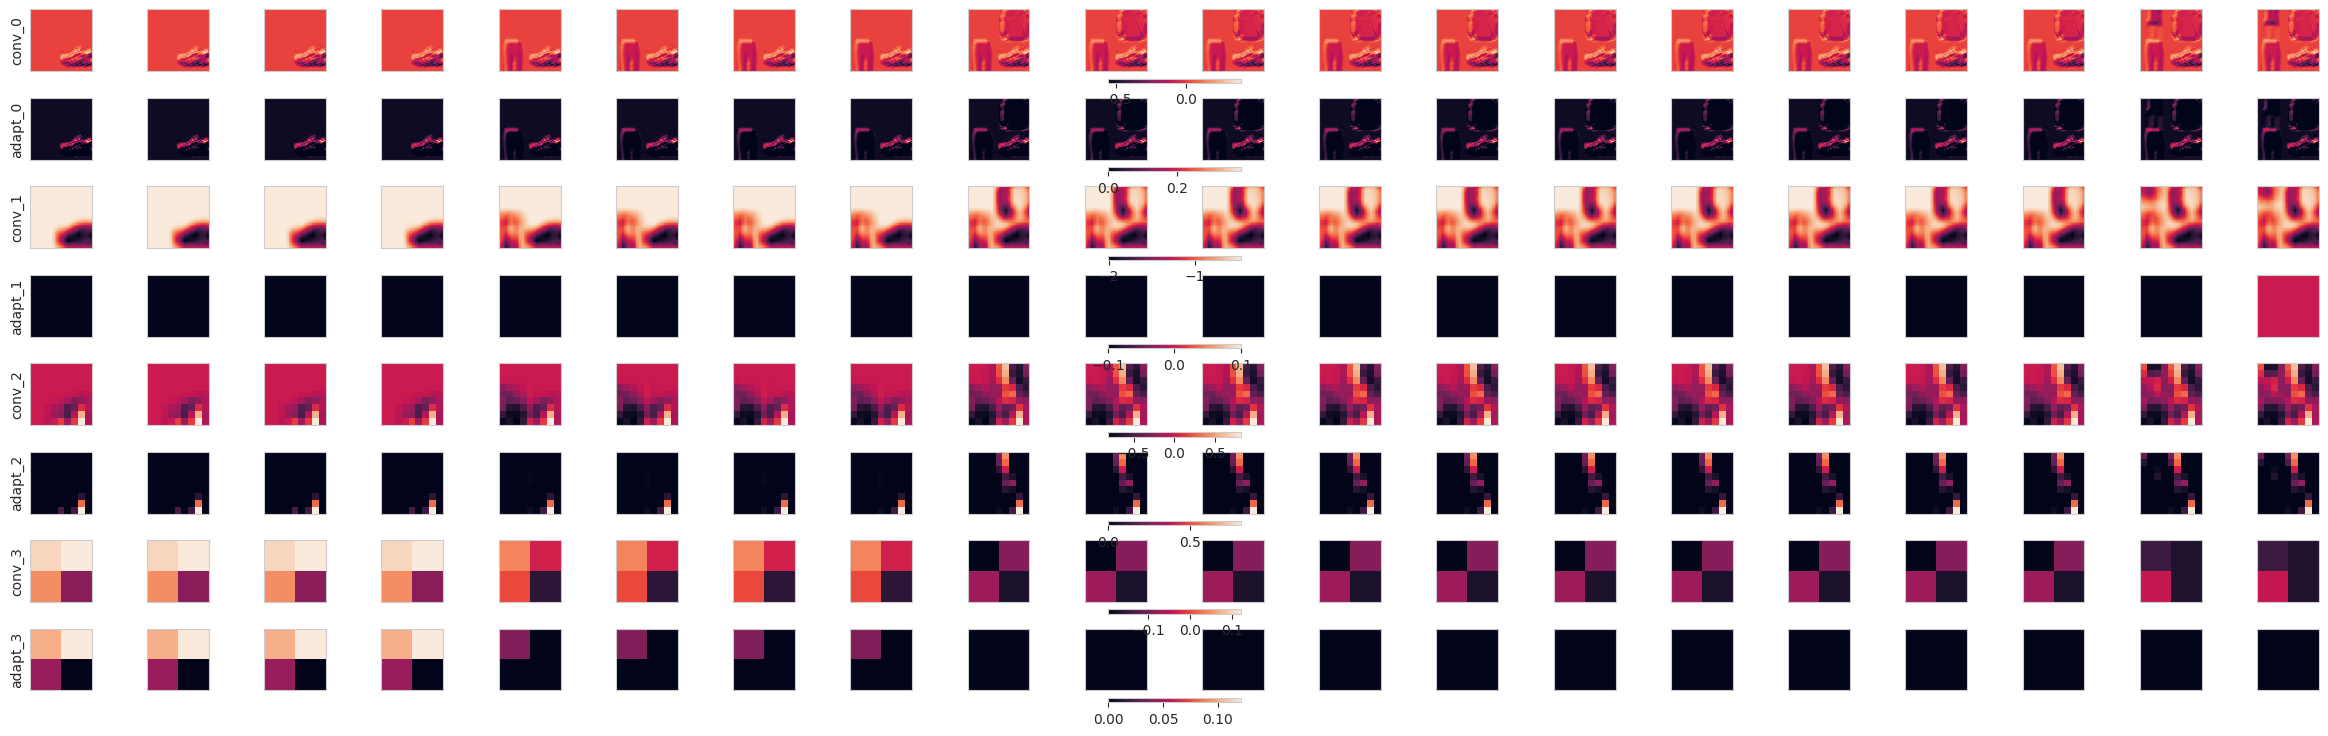

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

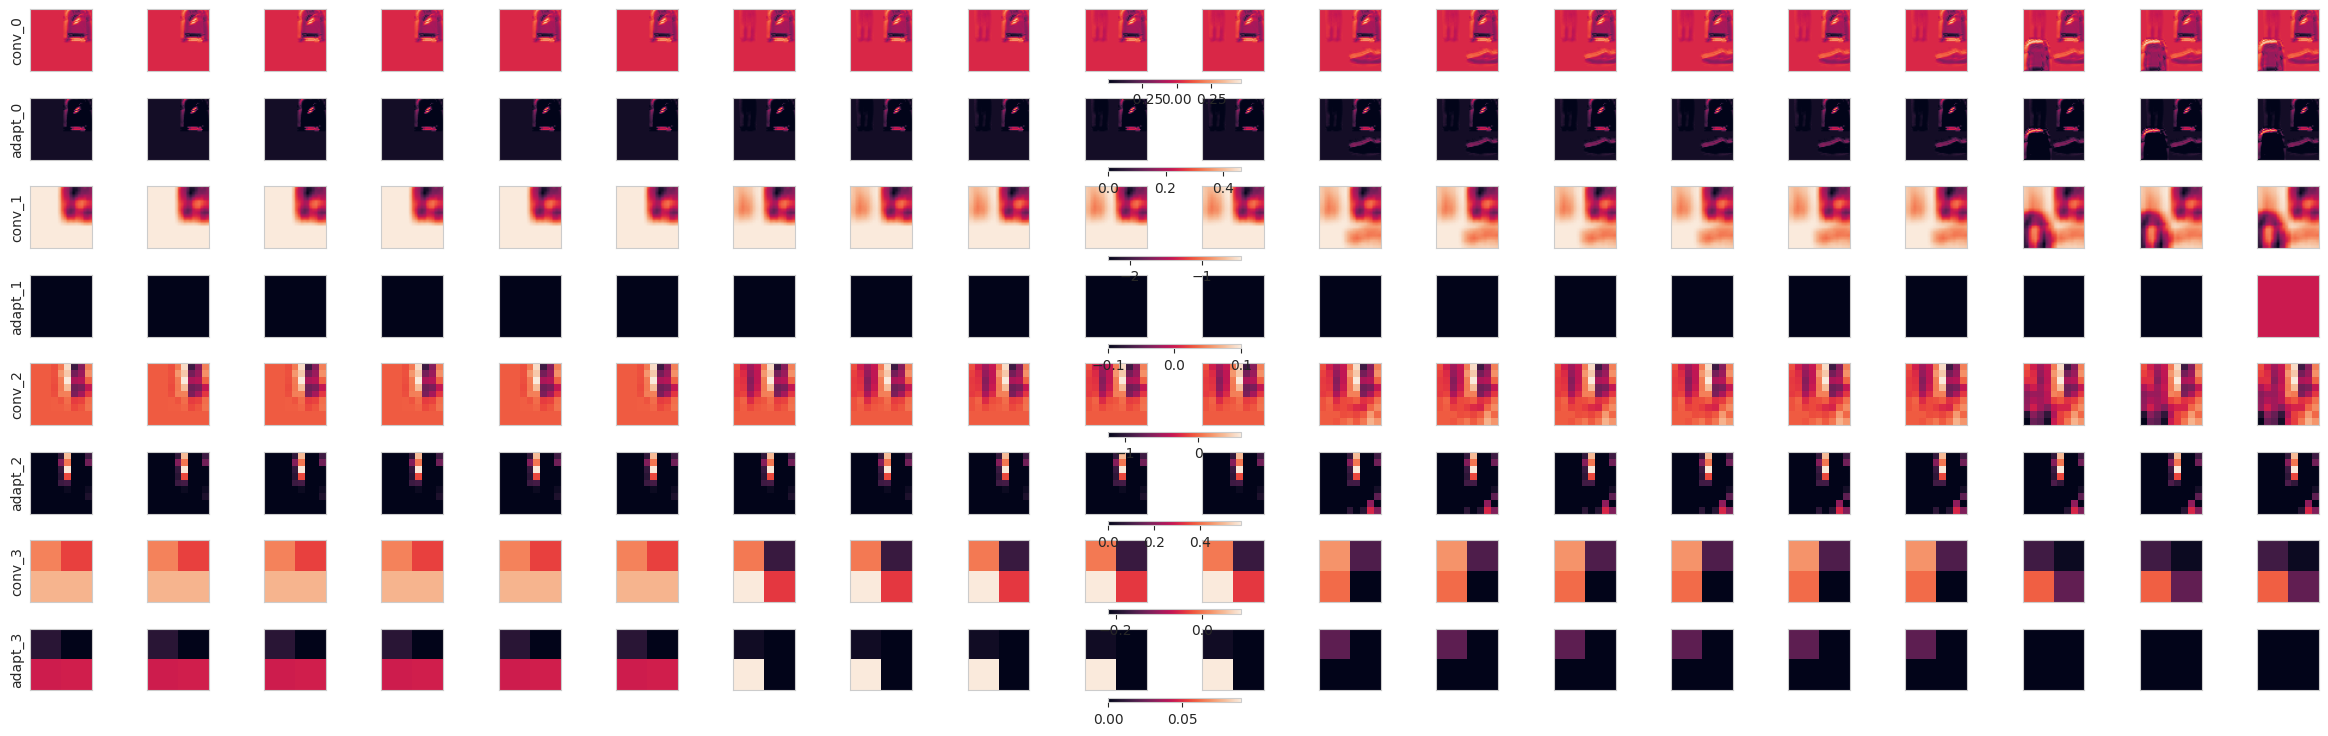

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

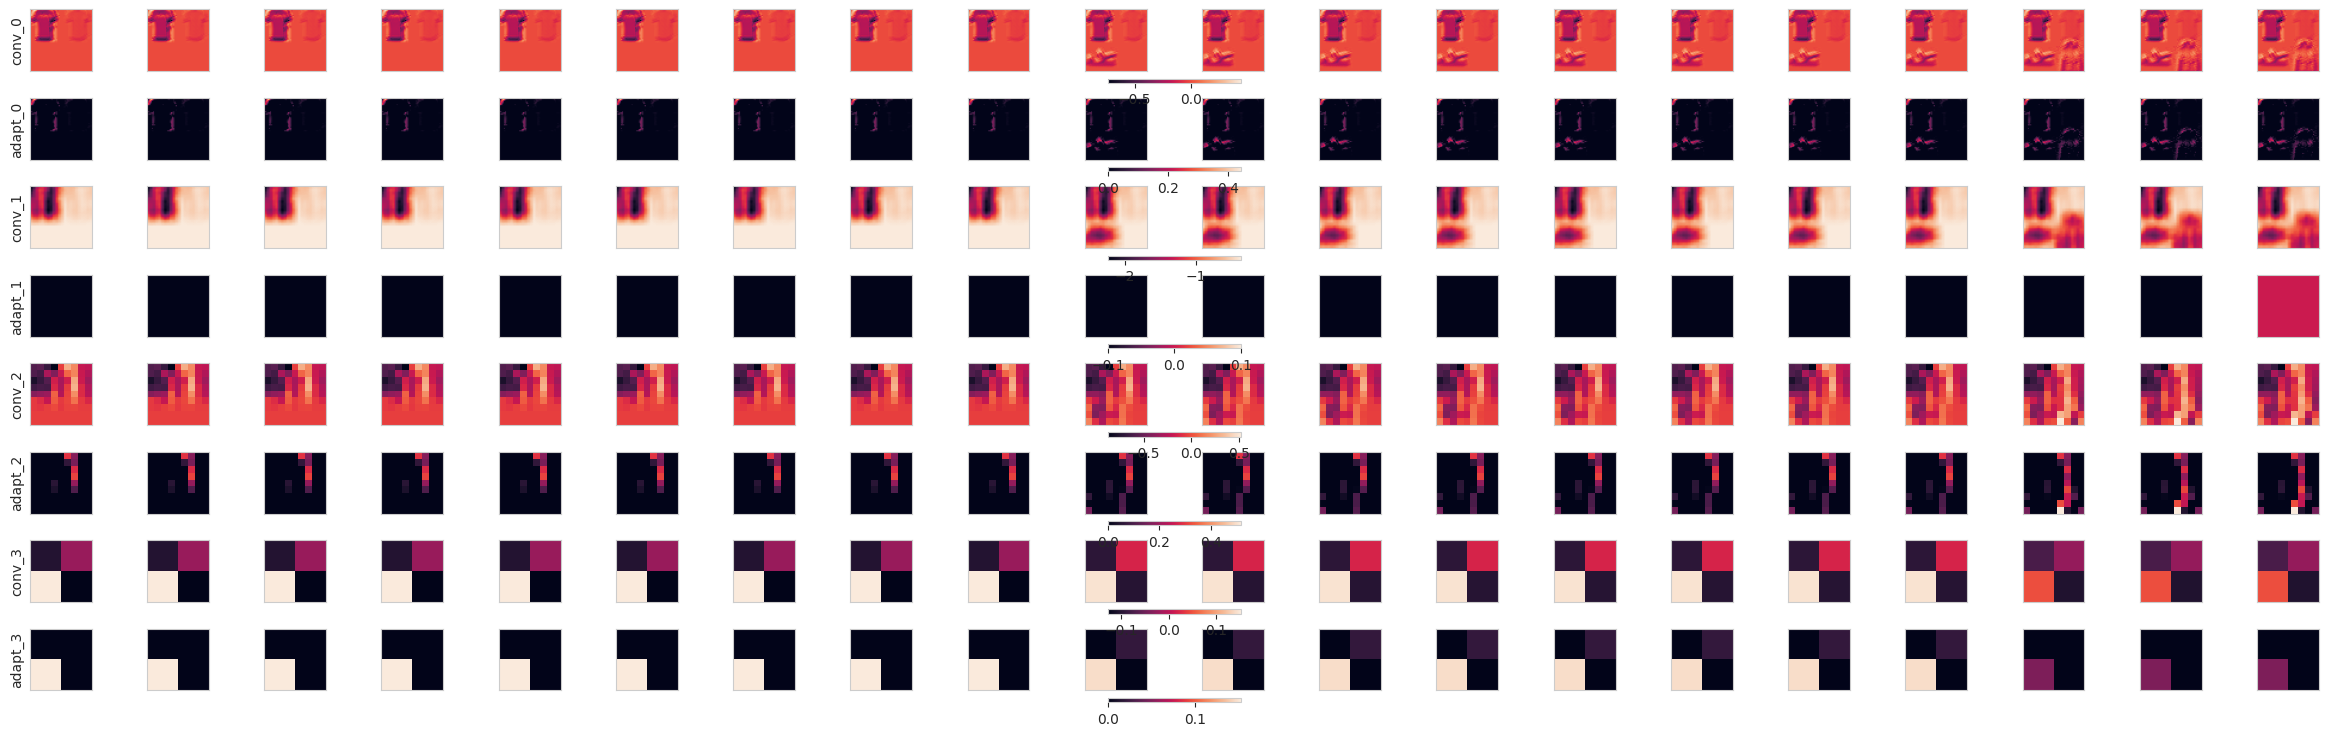

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

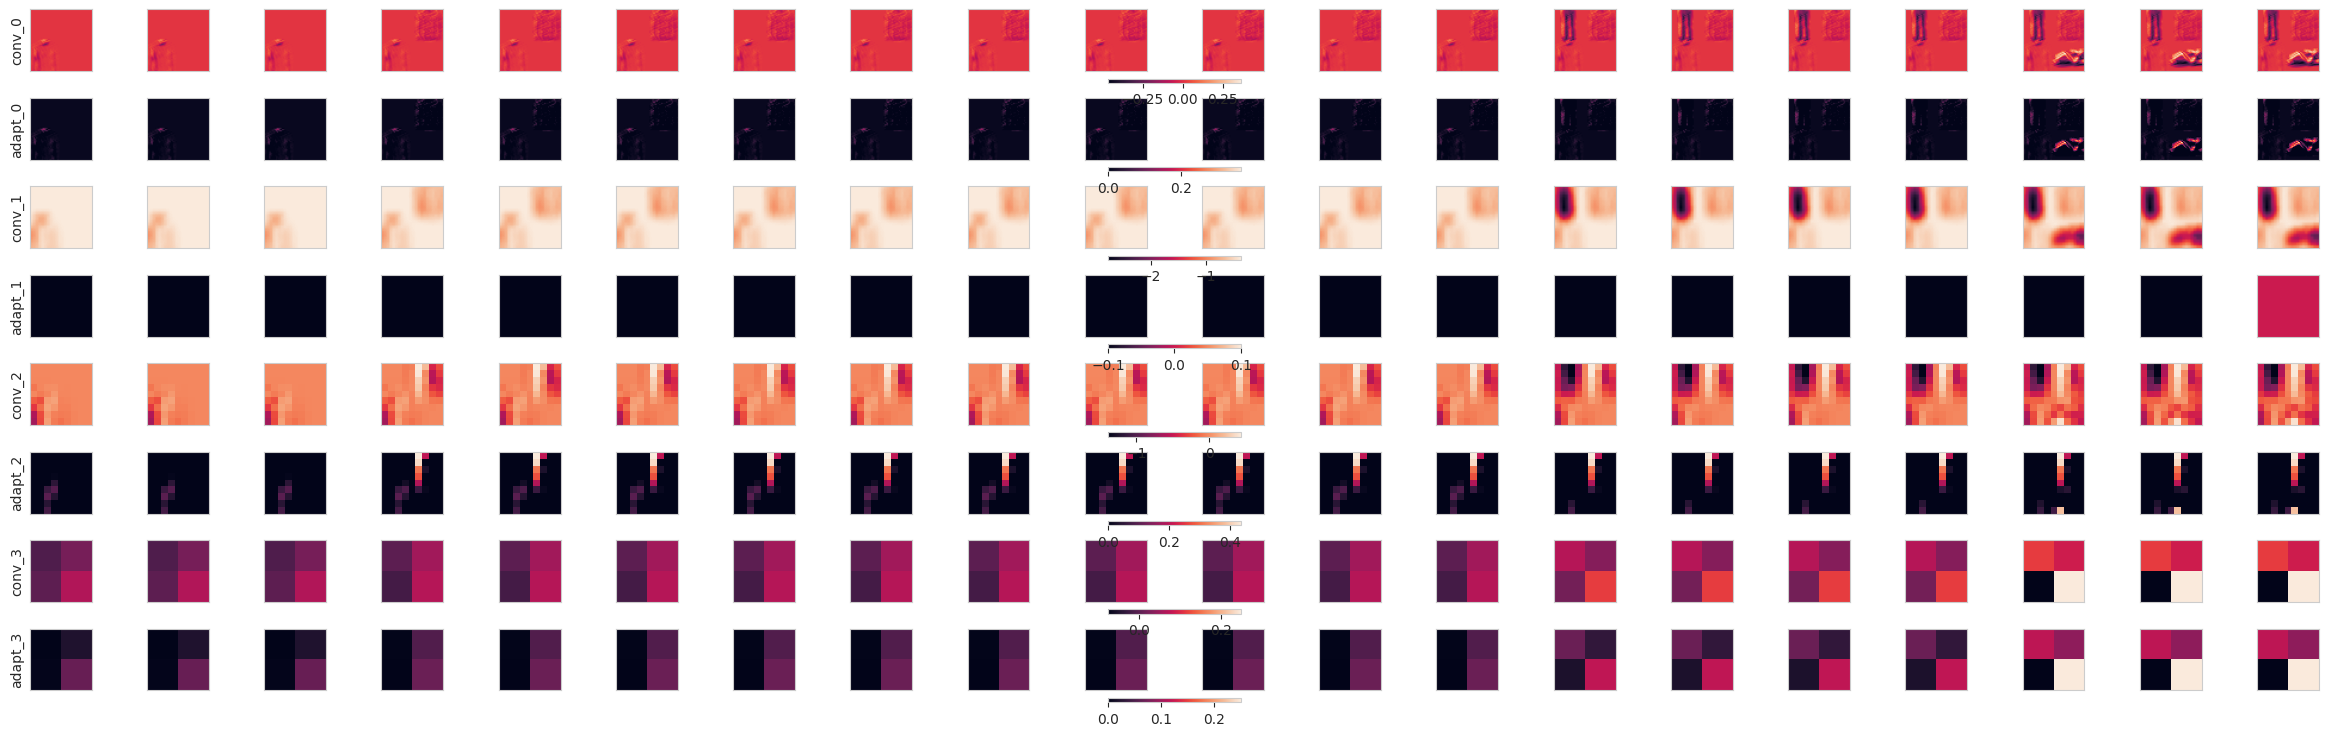

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

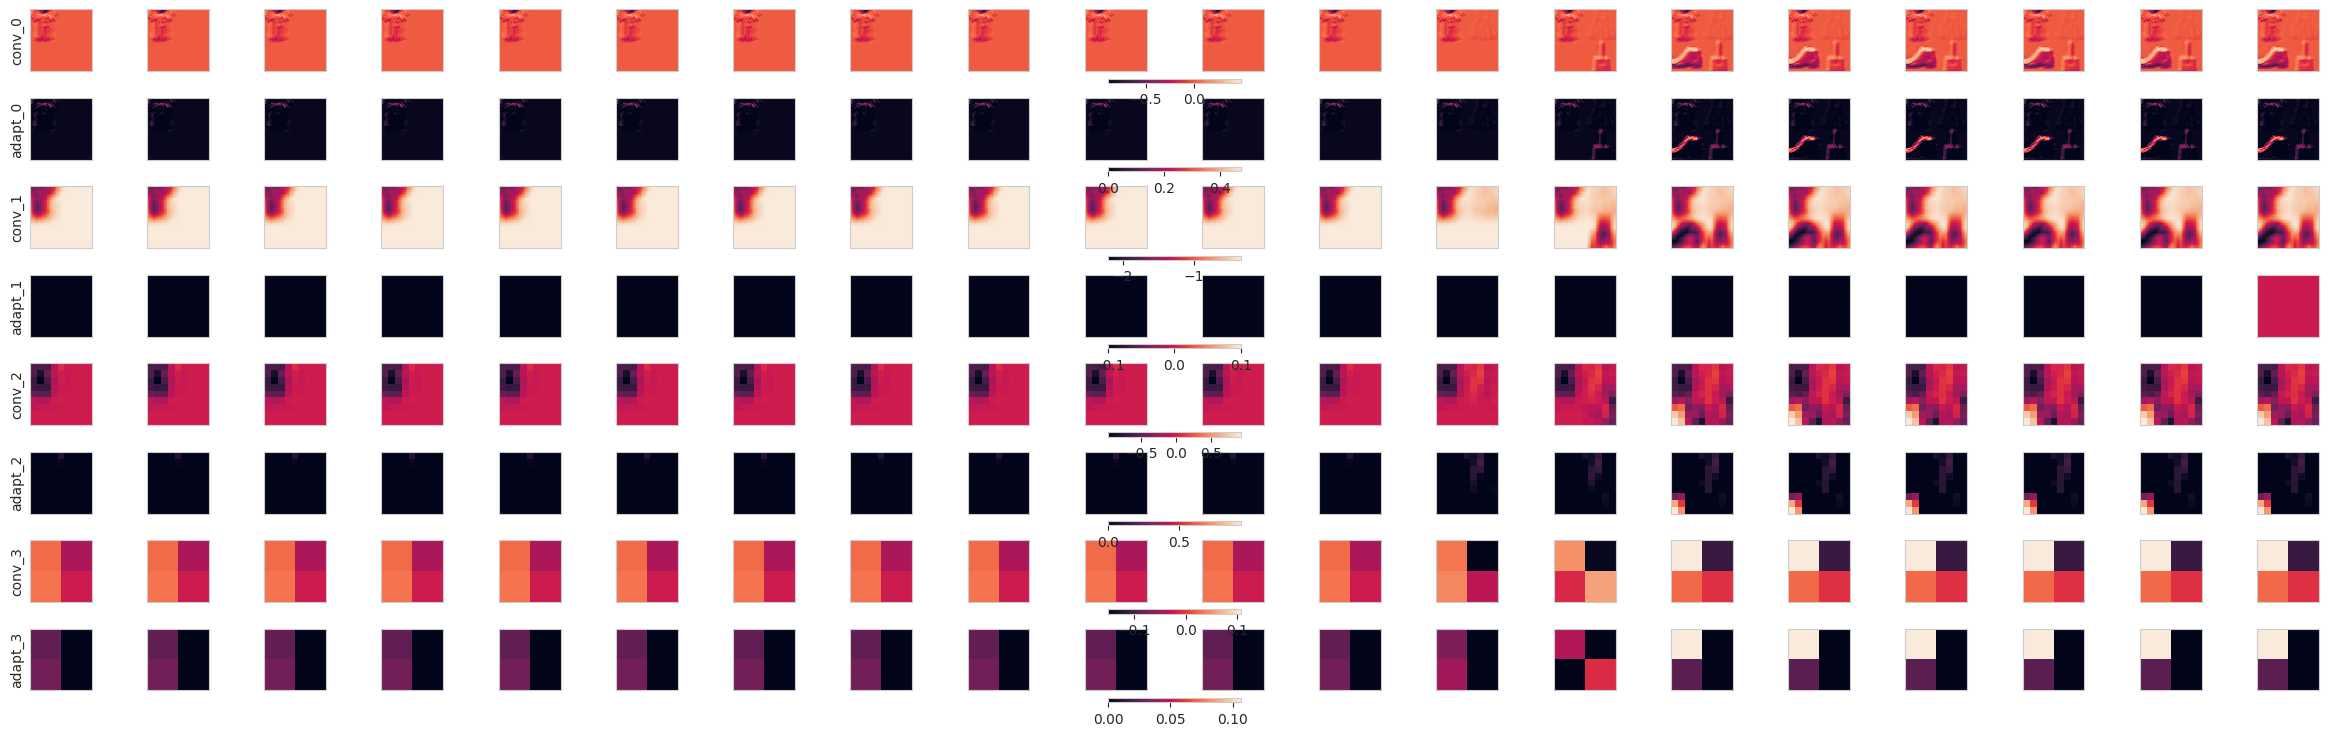

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

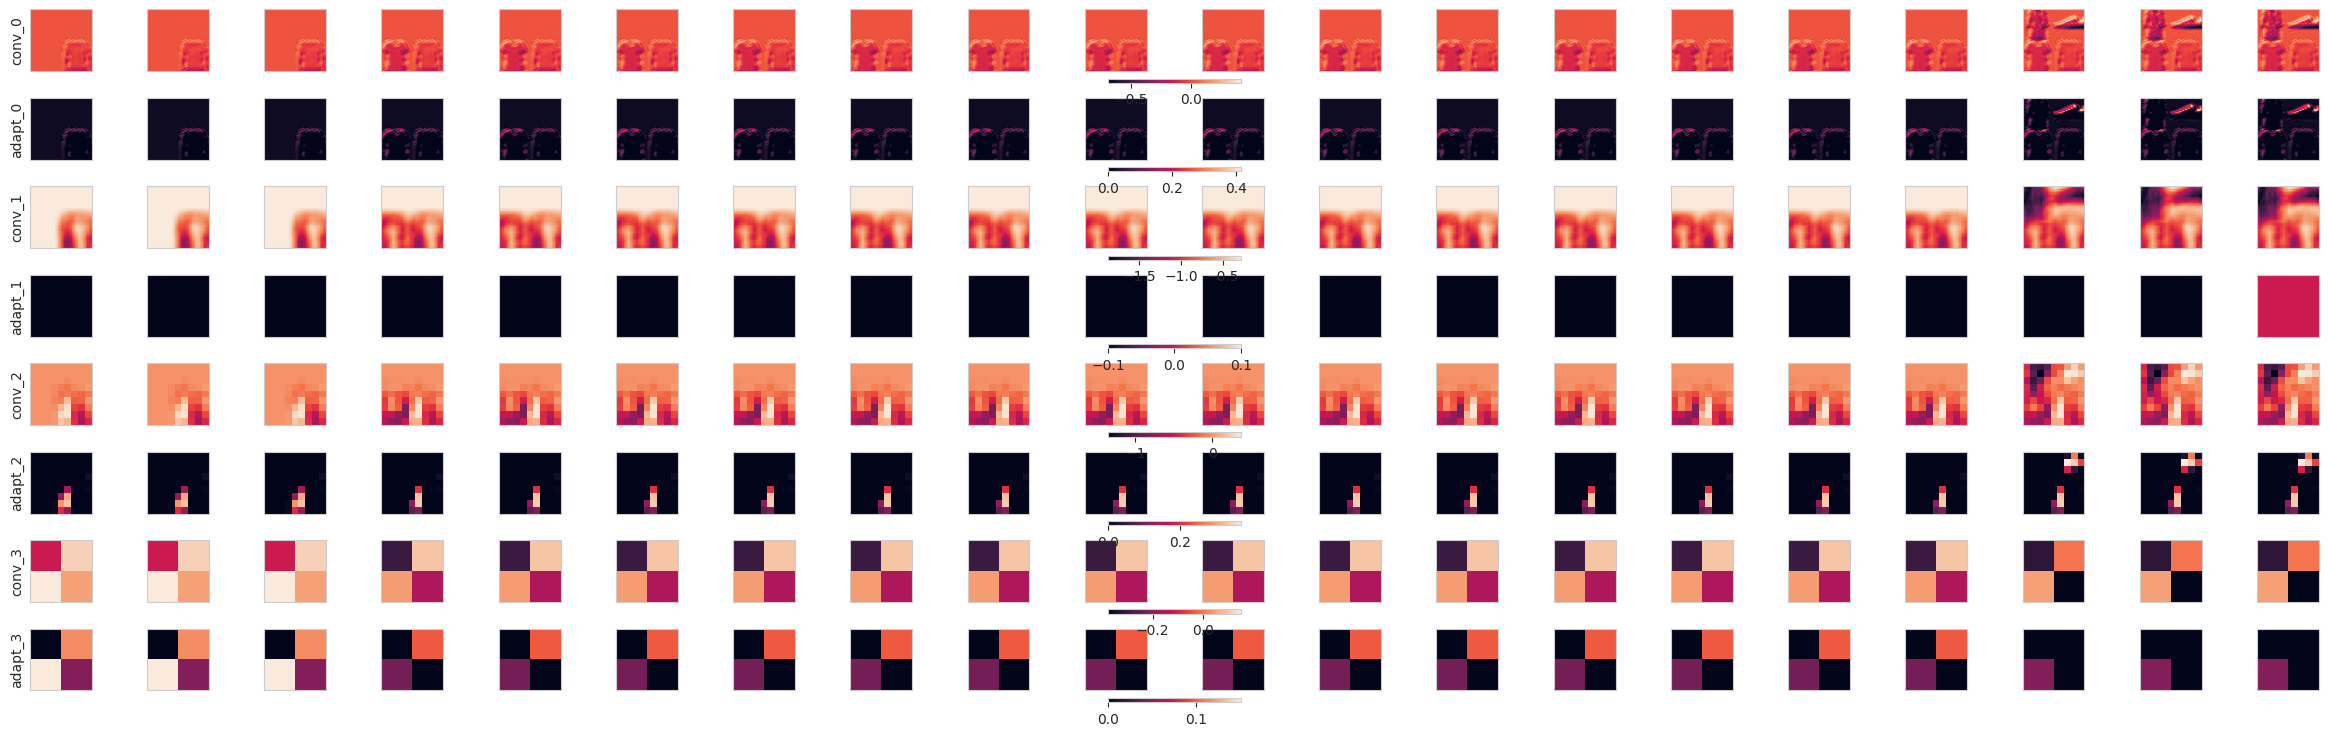

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

`Trainer.fit` stopped: `max_epochs=10` reached.


In [9]:
# Create instances of the Fashion MNIST dataset
train_dataset = TemporalDataset('train', transform=transform,
                                img_to_timesteps_transforms=timestep_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)

test_loader = DataLoader(EvalDataWrapper(train_dataset, contrast=1, rep_noise=False), batch_size=64, shuffle=True,
                         num_workers=3)
config_path = 'config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

dataset = config["dataset"]
if config["dataset"] == 'fashion_mnist':
    layer_kwargs = config["layer_kwargs_fmnist"]
elif config["dataset"] == 'cifar10':
    layer_kwargs = config["layer_kwargs_cifar10"]
    
config['adaptation_module'] = 'ExponentialDecay'

# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

logger = CSVLogger(config["log_dir"], name=config["log_name"])

if config["adaptation_module"] == 'LateralRecurrence':
    adaptation_module = LateralRecurrence
    adaptation_kwargs = config["adaptation_kwargs_lateral"]
elif config["adaptation_module"] == 'ExponentialDecay':
    adaptation_module = ExponentialDecay
    adaptation_kwargs = config["adaptation_kwargs_additive"]
elif config["adaptation_module"] == 'DivisiveNorm':
    adaptation_module = DivisiveNorm
    adaptation_kwargs = config["adaptation_kwargs_div_norm"]
elif config["adaptation_module"] == 'DivisiveNormGroup':
    adaptation_module = DivisiveNormGroup
    adaptation_kwargs = config["adaptation_kwargs_div_norm_group"]
elif config["adaptation_module"] == 'DivisiveNormChannel':
    adaptation_module = DivisiveNormChannel
    adaptation_kwargs = config["adaptation_kwargs_div_norm_channel"]
else:
    raise ValueError(f'Adaptation module {config["adaptation_module"]} not implemented')

t_steps = 20

num_epoch = 10

layer_kwargs = [{'in_channels': 1, 'out_channels': 32, 'kernel_size': 5},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 5},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
                {'in_features': 128, 'out_features': 1024}]
adaptation_kwargs = [
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False}
  ]

hooked_model = HookedRecursiveCNN(t_steps=t_steps, layer_kwargs=layer_kwargs,
                                  adaptation_module=adaptation_module,
                                  adaptation_kwargs=adaptation_kwargs, decode_every_timestep=True)
model = Adaptation(hooked_model, lr=config["lr"], contrast_metrics=False)

contrast = 'random'
tb_logger = TensorBoardLogger("lightning_logs",
                              name=f'video_{config["adaptation_module"]}_001',
                              version=f'baseline_video_{config["adaptation_module"]}_001')

# wandb.init(project='ai-thesis', config=config, entity='ai-thesis', name=f'{config["log_name"]}_{config["adaptation_module"]}_c_{contrast}_rep_{repeat_noise}_ep_{num_epoch}')
wandb_logger = pl.loggers.WandbLogger(project='ai-thesis', config=config,
                                      name=f'baseline_video_fmnist_002_{config["adaptation_module"]}_c_{contrast}_ep_{num_epoch}_{config["log_name"]}')

trainer = pl.Trainer(max_epochs=num_epoch, logger=wandb_logger)
# test_results = trainer.test(model, dataloaders=test_loader)
wandb_logger.watch(hooked_model, log='all', log_freq=1000)

trainer.fit(model, train_loader, test_loader)

# test
# test_results = trainer.test(model, dataloaders=train_loader)
# logger.log_metrics({'contrast': contrast, 'epoch': num_epoch, 'repeat_noise': 'n/a',
#                     'test_acc': test_results[0]["test_acc"]})
# logger.save()

trainer.save_checkpoint(
    f'learned_models/baseline_video_fmnist_{config["adaptation_module"]}_contrast_{contrast}_epoch_{num_epoch}.ckpt')

# visualize data

In [179]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 20, 1, 56, 56]), torch.Size([64, 20]))

In [18]:
int_to_label = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

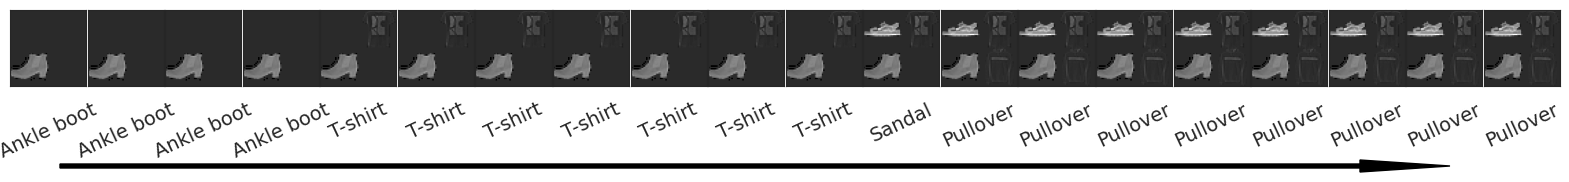

In [189]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

idx = 7
sample = x[idx].permute((0, 2, 3, 1))
fig, axes = plt.subplots(1, 20, figsize=(20, 4))  # Adjusted figsize to make it wider
fig.subplots_adjust(wspace=0.02)

for i, ax in enumerate(axes):
    ax.imshow(sample[i], cmap='gray', vmin=0.4, vmax=1)  # Set colormap to greyscale
    ax.set_xlabel(int_to_label[int(y[idx, i])], rotation=25, labelpad=10, fontsize=14)  # Rotate and position labels
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove y ticks

# Drawing a long arrow
arrow = FancyArrow(0.15, 0.2, 0.65, 0, width=0.01, color='black', transform=fig.transFigure, clip_on=False)
fig.add_artist(arrow)

plt.savefig("figures/attn_001.svg", format='svg')
plt.savefig("figures/attn_001.png")


# Load pretrained models

In [12]:
from modules.lateral_recurrence import LateralRecurrence
from modules.exponential_decay import ExponentialDecay
from modules.divisive_norm import DivisiveNorm
from modules.divisive_norm_group import DivisiveNormGroup
from modules.div_norm_channel import DivisiveNormChannel
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
import pytorch_lightning as pl
import json
from models.adaptation import Adaptation
from HookedRecursiveCNN import HookedRecursiveCNN

# HookedRecursiveCNN needs layer_kwargs and div_norm_kwargs to know how to setup the model but the concrete init values are unimportant as they will get overwritten with the pretrained values
layer_kwargs = [{'in_channels': 1, 'out_channels': 32, 'kernel_size': 5},
 {'in_channels': 32, 'out_channels': 32, 'kernel_size': 5},
 {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
 {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
 {'in_features': 128, 'out_features': 1024}]

div_norm_kwargs = [
    {"epsilon":  1e-8, "K_init":  0.2, "train_K":  True, "alpha_init":  -2.0, "train_alpha": True, "sigma_init": 0.1, "train_sigma": True},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  -2000000.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  -2000000.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  -2000000.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  0.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False}
  ]
exp_decay_kwargs = [
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False},
    {"alpha_init":  1.0, "train_alpha": False, "beta_init": 1, "train_beta": False}
  ]

div_norm_cfg = {
    't_steps': 20, 'layer_kwargs': layer_kwargs,
    'adaptation_module': DivisiveNorm,
    'adaptation_kwargs': div_norm_kwargs, 'decode_every_timestep': True
}
exp_decay_cfg = {
    't_steps': 20, 'layer_kwargs': layer_kwargs,
    'adaptation_module': ExponentialDecay,
    'adaptation_kwargs': exp_decay_kwargs, 'decode_every_timestep': True
}

In [13]:
div_norm_model = HookedRecursiveCNN.load_from_checkpoint('learned_models/video_fmnist_DivisiveNorm_contrast_random_epoch_10.ckpt', div_norm_cfg)
exp_decay_model = HookedRecursiveCNN.load_from_checkpoint('learned_models/video_fmnist_ExponentialDecay_contrast_random_epoch_10.ckpt', exp_decay_cfg)
baseline_model = HookedRecursiveCNN.load_from_checkpoint('learned_models/baseline_video_fmnist_ExponentialDecay_contrast_random_epoch_10.ckpt', exp_decay_cfg)

In [14]:
models = {
    'Divisive Norm.': div_norm_model,
    'Additive': exp_decay_model,
    'No Adaptation': baseline_model
}

In [17]:
from tqdm import tqdm
from torchmetrics.functional import accuracy
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Accuracy per timestep

In [230]:
from tqdm import tqdm
from torchmetrics.functional import accuracy
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.DataFrame({'Model': [], 'Accuracy': [], 'Timestep': []})
for name, model in models.items():
    j = 0
    for x, y, _, _ in tqdm(test_loader):
        x = x.cuda()
        y = y.cuda()
        logits = model(x.cuda())
        for i in range(20):
            l = logits[:, i, :]
            t = y[:, i]
            preds = torch.argmax(l, dim=1)
            acc = accuracy(preds, t, task='multiclass', num_classes=10)
            df.loc[len(df)] = [name, float(acc), i]
        j += 1
        if j > 100:
            break
df['Timestep'] += 1

 11%|█         | 100/938 [01:07<09:25,  1.48it/s] 


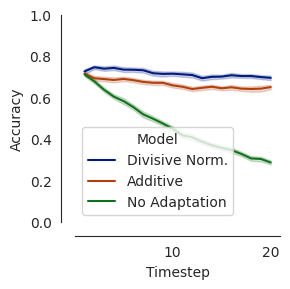

In [232]:
plt.figure(figsize=(3, 3))
sns.set_style('white')
sns.lineplot(data=df, x='Timestep', y='Accuracy', hue='Model', palette='dark')
plt.ylim(0, 1)
sns.despine(offset=10)
plt.tight_layout()

plt.savefig('figures/attn_002.svg')
plt.savefig('figures/attn_002.png')

## Only one image the whole time

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


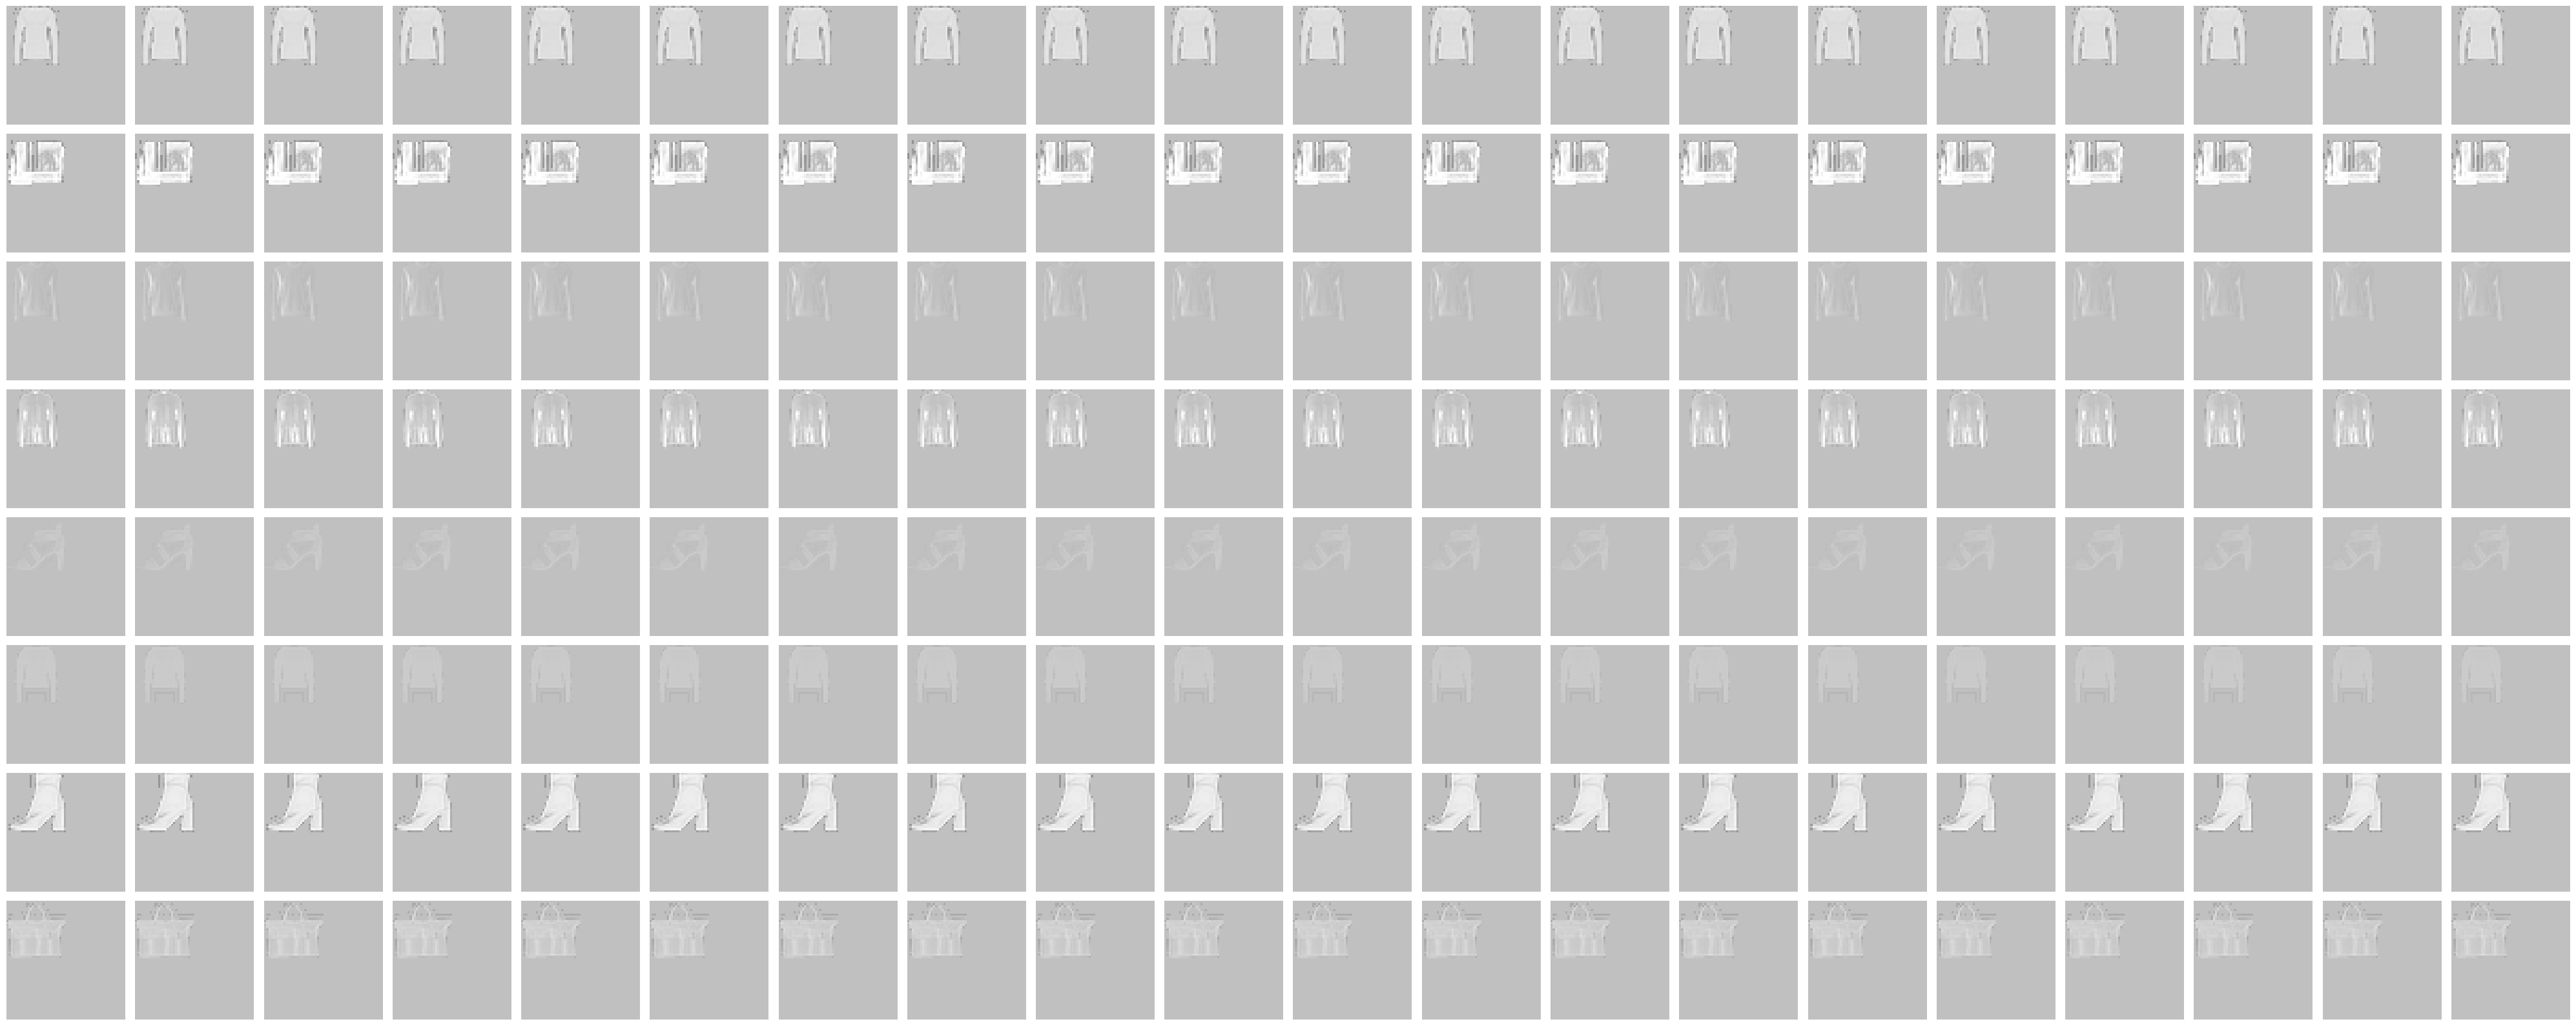

In [233]:
class OneImageTemporalDataset(Dataset):
    def __init__(self, split, dataset='fashion_mnist', transform=None, img_to_timesteps_transforms=None, contrast='random'):
        """
        Initializes the FashionMNISTNoisyDataset
        :param split: 'train' or 'test'
        :param dataset: name of the dataset
            must be one of the datasets in the huggingface datasets package
        :param transform: transforms to apply to the images
        :param img_to_timesteps_transforms: list of functions
            for every desired timestep, there should be a function in the list that converts
            the image to the desired format
        """
        self.split = split
        self.transform = transform
        self.dataset = load_dataset(dataset, split=split)
        input_col_name = 'img' if 'img' in self.dataset.column_names else 'image'  # because different datasets have different names
        self.data, self.targets = self.dataset[input_col_name], self.dataset['label']
        self.img_to_timesteps_transforms = img_to_timesteps_transforms
        self.contrast = contrast

    def int_to_coordinate(self, index):
        if index == 0:
            return 0, 0
        elif index == 1:
            return 0, 28
        elif index == 2:
            return 28, 0
        elif index == 3:
            return 28, 28
        else:
            raise ValueError('index must be between 0 and 3')

    def adjust_contrast(self, img, contrast):
        mean = img.mean()
        img = (img - mean) * contrast  #+ mean
        return img

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img_timesteps = list()
        labels = list()

        prev_img = torch.zeros((1, 28 * 2, 28 * 2)) + 0.5
        for i, trans_func in enumerate(self.img_to_timesteps_transforms):
            if i == 0:
                if self.transform is not None:
                    img = self.transform(img)
                mask = img > 1e-2
                img = trans_func(img, index, target)

                if self.contrast == 'random':
                    rand_contrast = np.random.uniform(0.1, 1)
                else:
                    rand_contrast = self.contrast
                img = self.adjust_contrast(img, rand_contrast)

                new_img = torch.zeros((1, 28 * 2, 28 * 2))
                x, y = 0, 0
                new_img[:, x:x + 28, y:y + 28] = img * mask

                prev_img = prev_img + new_img
                labels.append(
                    target
                )

                img_timesteps.append(prev_img)
            else:
                img_timesteps.append(prev_img)
                labels.append(labels[-1])

                # Stack the augmented images along the timestep dimension
        img_timesteps = torch.stack(img_timesteps, dim=0)
        labels = torch.tensor(labels)
        return img_timesteps, labels

    def __len__(self):
        return len(self.data)


import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])
from models.noisy_dataloader import NoisyTemporalDataset
from utils.transforms import MeanFlat, RandomRepeatedNoise, Identity
from functools import partial

eye = Identity()

timestep_transforms = [eye] * 20
# Create instances of the Fashion MNIST dataset
one_image_dataset = OneImageTemporalDataset('train', transform=transform,
                                img_to_timesteps_transforms=timestep_transforms)
from torch.utils.data import DataLoader

loader = DataLoader(one_image_dataset, batch_size=64, shuffle=True, num_workers=3)

from utils.visualization import visualize_first_batch_with_timesteps

visualize_first_batch_with_timesteps(loader, 8)

In [235]:
from tqdm import tqdm
from torchmetrics.functional import accuracy
import pandas as pd

df = pd.DataFrame({'Model': [], 'Accuracy': [], 'Timestep': []})
for name, model in models.items():
    model.cpu()
    j = 0
    for x, y in tqdm(loader):
        logits = model(x)
        for i in range(20):
            l = logits[:, i, :]
            t = y[:, 0]
            preds = torch.argmax(l, dim=1)
            acc = accuracy(preds, t, task='multiclass', num_classes=10)
            df.loc[len(df)] = [name, float(acc), i]
        j += 1
        if j > 100:
            break

 11%|█         | 100/938 [00:45<06:17,  2.22it/s]


In [236]:
df['Timestep'] += 1

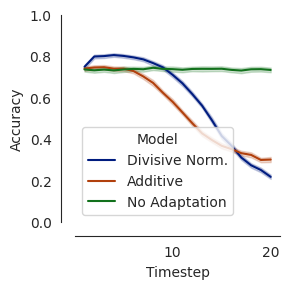

In [237]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(3, 3))
sns.set_style('white')
sns.lineplot(data=df, x='Timestep', y='Accuracy', hue='Model', palette='dark')
plt.ylim(0, 1)
sns.despine(offset=10)
plt.tight_layout()

plt.savefig('figures/attn_003.svg')
plt.savefig('figures/attn_003.png')

## per contrast

In [36]:
import pandas as pd

acc_dict = {'contrast': [], 'timestep': [], 'accuracy': []}
for contrast in [0.2, 0.4, 0.6, 0.8, 1.0]:
    one_image_dataset = OneImageTemporalDataset('train', transform=transform,
                                    img_to_timesteps_transforms=timestep_transforms, contrast=contrast)
    from torch.utils.data import DataLoader
    
    loader = DataLoader(one_image_dataset, batch_size=64, shuffle=True, num_workers=3)
    
    acc_per_timestep = torch.zeros(20)
    total = torch.zeros(1)
    j = 0
    for x, y in tqdm(loader):
        logits = model(x)
        for i in range(20):
            l = logits[:, i, :]
            t = y[:, 0]
            preds = torch.argmax(l, dim=1)
            acc = accuracy(preds, t, task='multiclass', num_classes=10)
            acc_per_timestep[i] += acc
        total += 1
        j += 1
        if j > 100:
            break
    acc_per_timestep /= total
    acc_dict['contrast'].extend([contrast] * 20)
    acc_dict['timestep'].extend(list(np.arange(20)))
    acc_dict['accuracy'].extend(list(acc_per_timestep))
df = pd.DataFrame(acc_dict)
df['accuracy'] = [float(val) for val in df['accuracy']]
df

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

 11%|█         | 100/938 [01:13<10:19,  1.35it/s]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

 11%|█         | 100/938 [01:14<10:23,  1.34it/s]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

 11%|█         | 100/938 [01:14<10:26,  1.34it/s]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

 11%|█         | 100/938 [01:14<10:21,  1.35it/s]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/

contrast  timestep        accuracy
0        0.2         0  tensor(0.7369)
1        0.2         1  tensor(0.7754)
2        0.2         2  tensor(0.7845)
3        0.2         3  tensor(0.7857)
4        0.2         4  tensor(0.7859)
..       ...       ...             ...
95       1.0        15  tensor(0.4915)
96       1.0        16  tensor(0.4811)
97       1.0        17  tensor(0.4336)
98       1.0        18  tensor(0.4432)
99       1.0        19  tensor(0.3877)

[100 rows x 3 columns]

Text(0.5, 1.0, 'Accuracy goes down faster for low contrast because it has lower activations in the first place?')

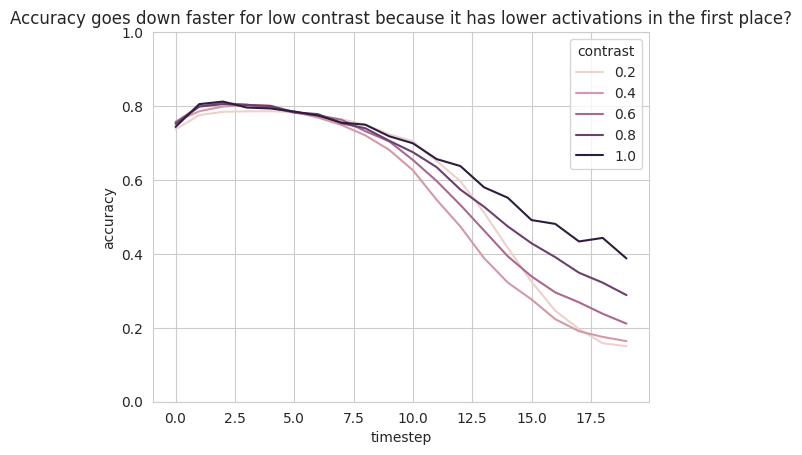

In [39]:
sns.lineplot(data=df, x='timestep', y='accuracy', hue='contrast')
plt.ylim(0, 1)
plt.title('Accuracy goes down faster for low contrast because it has lower activations in the first place?')

## Activation Scale

In [114]:
actv_dict = {'Timestep': [], 'Layer': [], 'Mean': [], 'num_active': [], 'mean_not_null': [], 'Norm': [], 'Model': []}
one_image_dataset = OneImageTemporalDataset('test', transform=transform,
                                img_to_timesteps_transforms=timestep_transforms, contrast='random')

loader = DataLoader(one_image_dataset, batch_size=64, shuffle=True, num_workers=3, pin_memory=True, pin_memory_device='cuda')
    
for x, y in tqdm(loader):
    x = x.cuda()
    y = y.cuda()
    for name, model in models.items():
        model.cuda()
        logits, cache = model.run_with_cache(x)
        for layer in range(4):
            for timestep in range(20):
                actv = cache[f'hks.adapt_{layer}_{timestep}']
                actv_dict['Timestep'].append(timestep)
                actv_dict['Layer'].append(layer)
                actv_dict['Mean'].append(float(actv.mean()))
                actv_dict['num_active'].append(float((actv > 1e-4).sum()))
                actv_dict['mean_not_null'].append(float(actv[actv > 1e-4].mean()))   
                actv_dict['Norm'].append(float(actv.norm()))
                actv_dict['Model'].append(name)

actv_df = pd.DataFrame(actv_dict)
actv_df

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 157/157 [00:39<00:00,  4.02it/s]


Timestep  Layer      Mean  num_active  mean_not_null        Norm   
0             0      0  0.154388   2291352.0       0.373128  917.039734  \
1             1      0  0.076507   2276064.0       0.186145  387.568939   
2             2      0  0.049674   2291352.0       0.120053  240.302582   
3             3      0  0.036369   2290989.0       0.087912  168.138092   
4             4      0  0.028833   2291352.0       0.069684  127.711411   
...         ...    ...       ...         ...            ...         ...   
37675        15      3  0.037857       968.0       0.080095    2.871884   
37676        16      3  0.037857       968.0       0.080095    2.871884   
37677        17      3  0.037857       968.0       0.080095    2.871884   
37678        18      3  0.037857       968.0       0.080095    2.871884   
37679        19      3  0.037857       968.0       0.080095    2.871884   

                Model  
0      Divisive Norm.  
1      Divisive Norm.  
2      Divisive Norm.  
3      Divisive Norm.  
4      Divisive Norm.  
...               ...  
37675   No Adaptation  
37676   No Adaptation  
37677   No Adaptation  
37678   No Adaptation  
37679   No Adaptation  

[37680 rows x 7 columns]

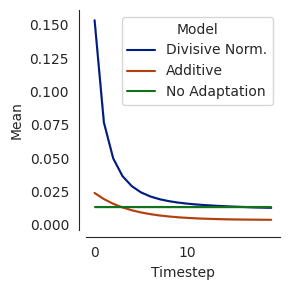

In [226]:
plt.figure(figsize=(3,3))
sns.lineplot(data=actv_df[actv_df.Layer==0], x='Timestep', y='Mean', hue='Model', palette='dark')
sns.despine(offset=5)
plt.tight_layout()
plt.savefig('figures/attn_006.svg')
plt.savefig('figures/attn_006.png')
#plt.ylim(0, 0.09)

In [41]:
actv_dict = {'contrast': [], 'timestep': [], 'layer': [], 'mean': [], 'num_active': [], 'mean_not_null': []}
for contrast in [0.2, 0.4, 0.6, 0.8, 1.0]:
    one_image_dataset = OneImageTemporalDataset('train', transform=transform,
                                    img_to_timesteps_transforms=timestep_transforms, contrast=contrast)
    from torch.utils.data import DataLoader
    
    loader = DataLoader(one_image_dataset, batch_size=64, shuffle=True, num_workers=3)
    
    acc_per_timestep = torch.zeros(20)
    total = torch.zeros(1)
    j = 0
    for x, y in tqdm(loader):
        logits, cache = model.model.run_with_cache(x)
        for layer in range(4):
            for timestep in range(20):
                actv = cache[f'hks.adapt_{layer}_{timestep}']
                actv_dict['contrast'].append(contrast)
                actv_dict['timestep'].append(timestep)
                actv_dict['layer'].append(layer)
                actv_dict['mean'].append(actv.mean())
                actv_dict['num_active'].append((actv > 1e-4).sum())
                actv_dict['mean_not_null'].append(actv[actv > 1e-4].mean())                
        j += 1
        if j > 100:
            break
actv_df = pd.DataFrame(actv_dict)
actv_df


Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

 11%|█         | 100/938 [01:52<15:44,  1.13s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

 11%|█         | 100/938 [02:05<17:30,  1.25s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

 11%|█         | 100/938 [02:03<17:16,  1.24s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

 11%|█         | 100/938 [02:03<17:12,  1.23s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/

contrast  timestep  layer            mean       num_active   
0           0.2         0      0  tensor(0.1440)  tensor(2310265)  \
1           0.2         1      0  tensor(0.0761)  tensor(2309062)   
2           0.2         2      0  tensor(0.0498)  tensor(2310265)   
3           0.2         3      0  tensor(0.0367)  tensor(2310265)   
4           0.2         4      0  tensor(0.0292)  tensor(2310265)   
...         ...       ...    ...             ...              ...   
40395       1.0        15      3  tensor(0.0354)     tensor(7808)   
40396       1.0        16      3  tensor(0.0355)     tensor(7774)   
40397       1.0        17      3  tensor(0.0360)     tensor(7878)   
40398       1.0        18      3  tensor(0.0360)     tensor(7825)   
40399       1.0        19      3  tensor(0.0364)     tensor(7904)   

        mean_not_null  
0      tensor(0.3452)  
1      tensor(0.1825)  
2      tensor(0.1194)  
3      tensor(0.0880)  
4      tensor(0.0700)  
...               ...  
40395  tensor(0.0372)  
40396  tensor(0.0374)  
40397  tensor(0.0375)  
40398  tensor(0.0376)  
40399  tensor(0.0378)  

[40400 rows x 6 columns]

In [43]:
actv_df['mean'] = [float(val) for val in actv_df['mean']]
actv_df['num_active'] = [float(val) for val in actv_df['num_active']]
actv_df['mean_not_null'] = [float(val) for val in actv_df['mean_not_null']]

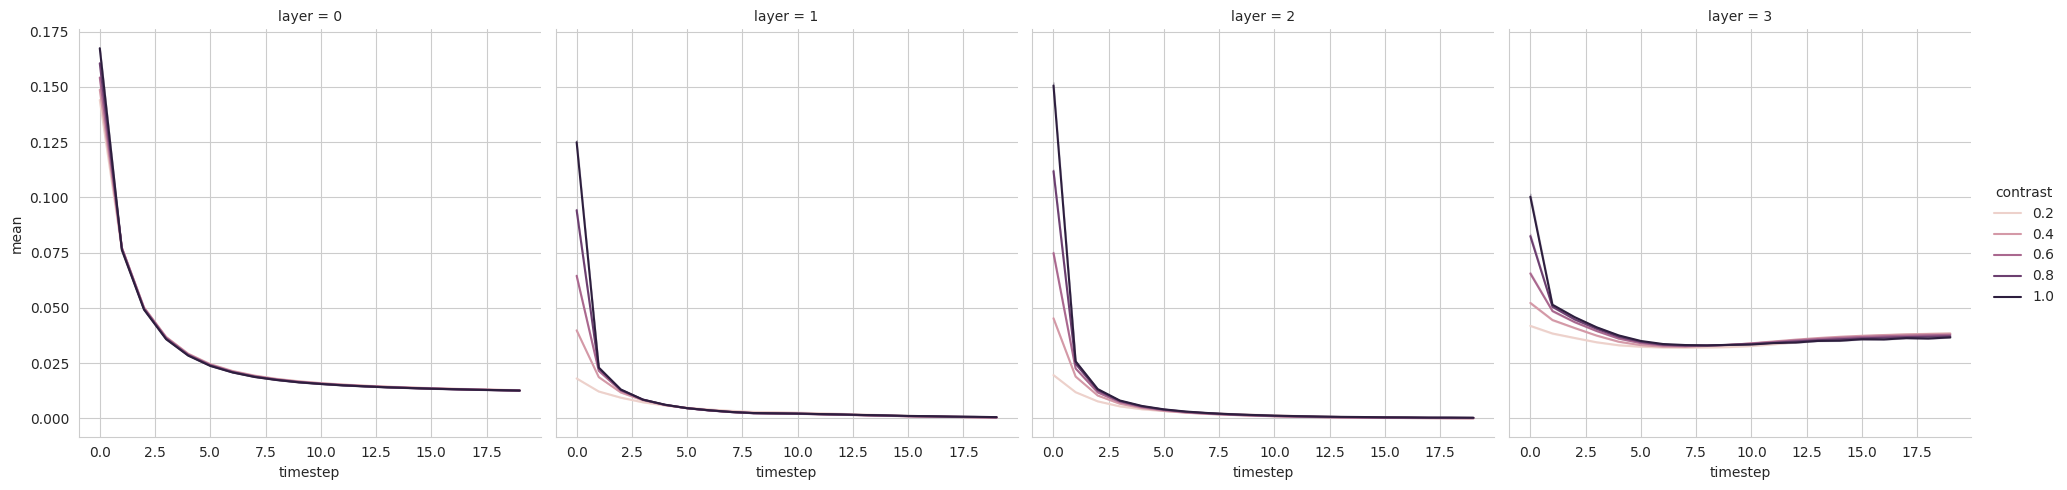

In [47]:
sns.relplot(data=actv_df, x='timestep', y='mean', hue='contrast', kind='line', col='layer')

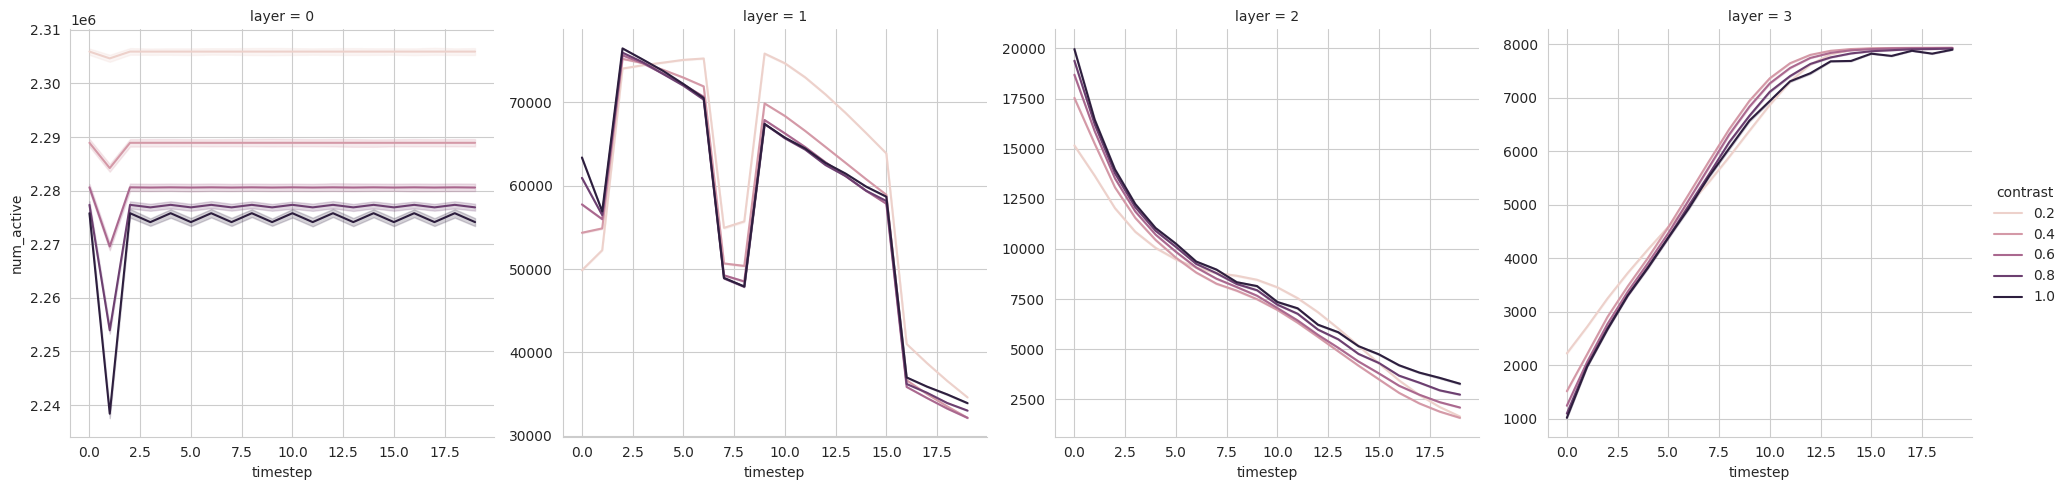

In [50]:
sns.relplot(data=actv_df, x='timestep', y='num_active', hue='contrast', kind='line', col='layer', facet_kws={'sharey':False})


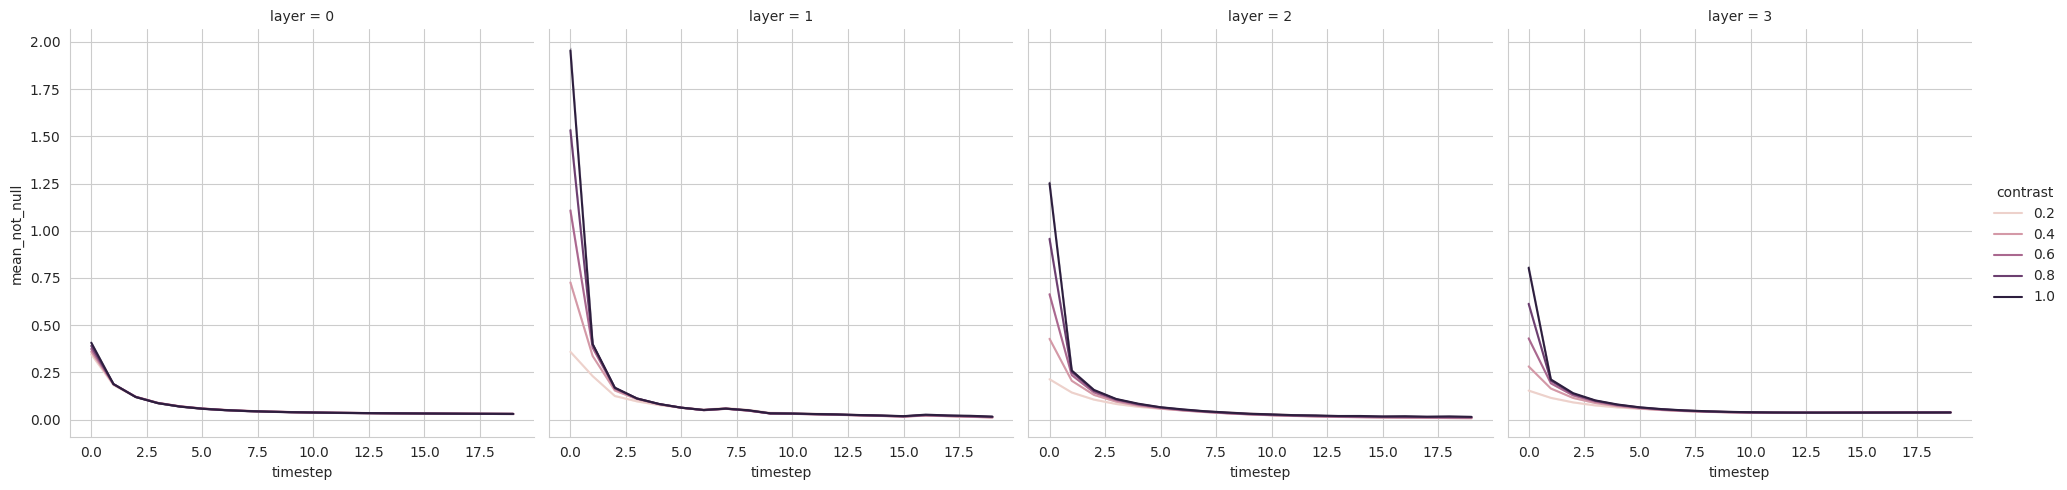

In [51]:
sns.relplot(data=actv_df, x='timestep', y='mean_not_null', hue='contrast', kind='line', col='layer')


## Two images

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


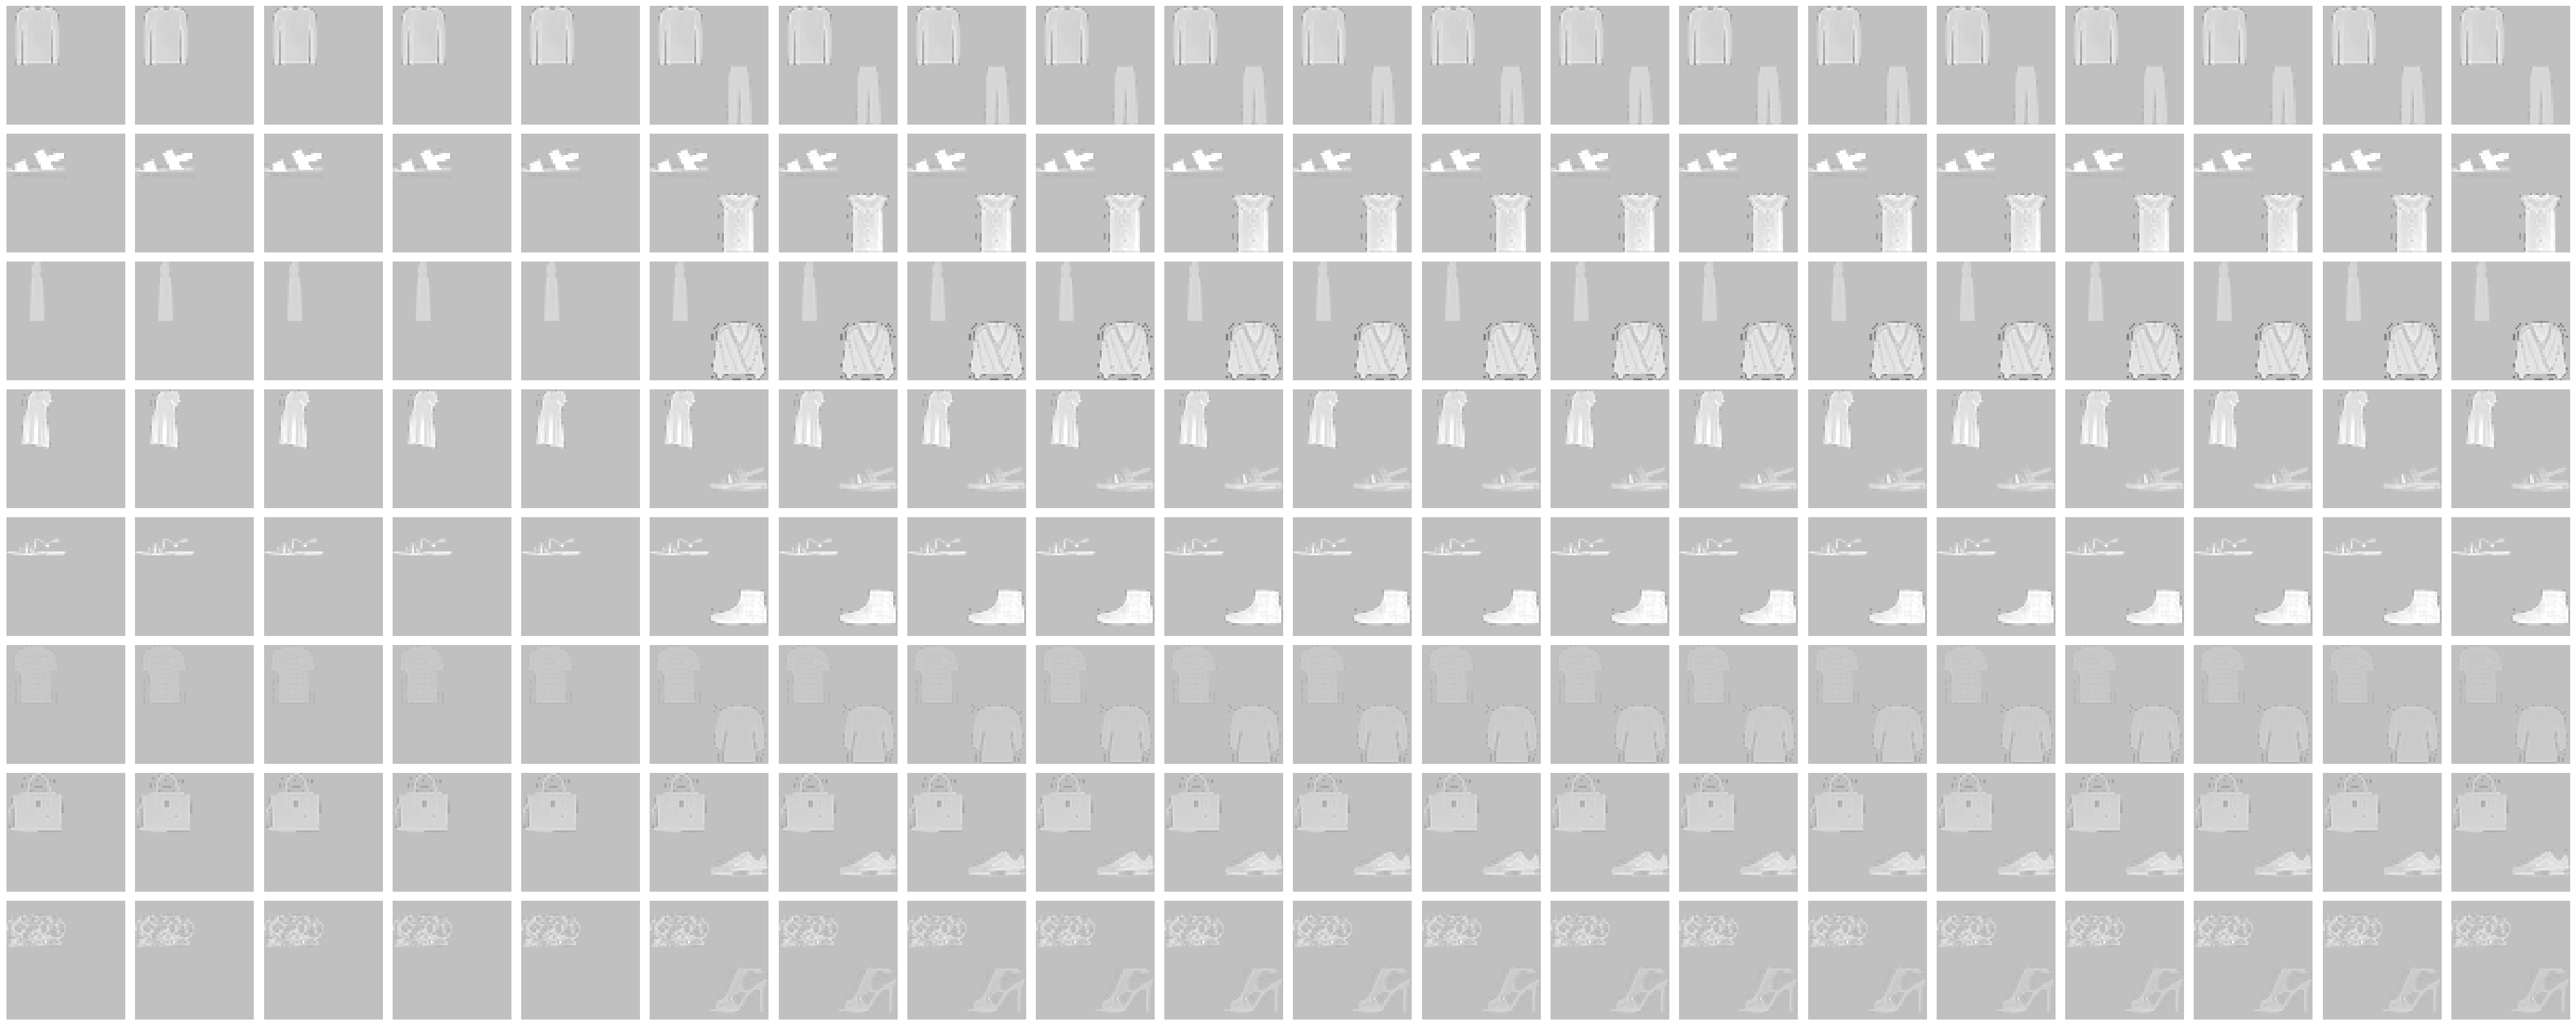

In [9]:
class TwoImageTemporalDataset(Dataset):
    def __init__(self, split, onset_img_2, dataset='fashion_mnist', transform=None, img_to_timesteps_transforms=None, contrast_1='random', contrast_2='random'):
        """
        Initializes the FashionMNISTNoisyDataset
        :param split: 'train' or 'test'
        :param dataset: name of the dataset
            must be one of the datasets in the huggingface datasets package
        :param transform: transforms to apply to the images
        :param img_to_timesteps_transforms: list of functions
            for every desired timestep, there should be a function in the list that converts
            the image to the desired format
        """
        self.split = split
        self.transform = transform
        self.dataset = load_dataset(dataset, split=split)
        input_col_name = 'img' if 'img' in self.dataset.column_names else 'image'  # because different datasets have different names
        self.data, self.targets = self.dataset[input_col_name], self.dataset['label']
        self.img_to_timesteps_transforms = img_to_timesteps_transforms
        self.contrast_1 = contrast_1
        self.contrast_2 = contrast_2
        self.onset_img_2 = onset_img_2

    def int_to_coordinate(self, index):
        if index == 0:
            return 0, 0
        elif index == 1:
            return 0, 28
        elif index == 2:
            return 28, 0
        elif index == 3:
            return 28, 28
        else:
            raise ValueError('index must be between 0 and 3')

    def adjust_contrast(self, img, contrast):
        mean = img.mean()
        img = (img - mean) * contrast  #+ mean
        return img

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img_timesteps = list()
        labels = list()

        prev_img = torch.zeros((1, 28 * 2, 28 * 2)) + 0.5
        for i, trans_func in enumerate(self.img_to_timesteps_transforms):
            if i == 0:
                if self.transform is not None:
                    img = self.transform(img)
                mask = img > 1e-2
                img = trans_func(img, index, target)

                if self.contrast_1 == 'random':
                    rand_contrast = np.random.uniform(0.1, 1)
                else:
                    rand_contrast = self.contrast_1
                img = self.adjust_contrast(img, rand_contrast)

                new_img = torch.zeros((1, 28 * 2, 28 * 2))
                x, y = 0, 0
                new_img[:, x:x + 28, y:y + 28] = img * mask

                prev_img = prev_img + new_img
                labels.append(
                    target
                )

                img_timesteps.append(prev_img)
            elif i == self.onset_img_2:
                index = int(np.random.choice(10000, 1))
                img, target = self.data[index], int(self.targets[index])
                if self.transform is not None:
                    img = self.transform(img)
                mask = img > 1e-2
                img = trans_func(img, index, target)

                if self.contrast_2 == 'random':
                    rand_contrast = np.random.uniform(0.1, 1)
                else:
                    rand_contrast = self.contrast_2
                img = self.adjust_contrast(img, rand_contrast)

                new_img = torch.zeros((1, 28 * 2, 28 * 2))
                x, y = 28, 28
                new_img[:, x:x + 28, y:y + 28] = img * mask

                prev_img = prev_img + new_img
                labels.append(
                    target
                )

                img_timesteps.append(prev_img)
            else:
                img_timesteps.append(prev_img)
                labels.append(labels[-1])

                # Stack the augmented images along the timestep dimension
        img_timesteps = torch.stack(img_timesteps, dim=0)
        labels = torch.tensor(labels)
        return img_timesteps, labels

    def __len__(self):
        return len(self.data)


import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])
from models.noisy_dataloader import NoisyTemporalDataset
from utils.transforms import MeanFlat, RandomRepeatedNoise, Identity
from functools import partial

eye = Identity()

timestep_transforms = [eye] * 20
# Create instances of the Fashion MNIST dataset
two_image_dataset = TwoImageTemporalDataset('train', 5, transform=transform,
                                img_to_timesteps_transforms=timestep_transforms)
from torch.utils.data import DataLoader

loader = DataLoader(two_image_dataset, batch_size=64, shuffle=True, num_workers=3)

from utils.visualization import visualize_first_batch_with_timesteps

visualize_first_batch_with_timesteps(loader, 8)

In [81]:
acc_dict = {'Model': [], 'Timestep': [], 'Accuracy': [], 'Onset': []}
for onset in [2, 5, 15]:
    one_image_dataset = TwoImageTemporalDataset('test', onset_img_2=onset, transform=transform,
                                    img_to_timesteps_transforms=timestep_transforms, contrast_1=0.6, contrast_2='random')        
    loader = DataLoader(one_image_dataset, batch_size=64, shuffle=True, num_workers=30)
    
    for name, model in models.items():
        for x, y in tqdm(loader):
            logits = model(x)
            for i in range(20):
                l = logits[:, i, :]
                t = y[:, i]
                preds = torch.argmax(l, dim=1)
                acc = accuracy(preds, t, task='multiclass', num_classes=10)
                acc_dict['Timestep'].append(i)
                acc_dict['Accuracy'].append(float(acc))
                acc_dict['Onset'].append(onset)
                acc_dict['Model'].append(name)
df = pd.DataFrame(acc_dict)
df

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 157/157 [01:35<00:00,  1.64it/s]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 157/157 [01:34<00:00,  1.65it/s]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 157/157 [01:37<00:00,  1.60it/s]


Model  Timestep  Accuracy  Onset
0      Divisive Norm.         0  0.656250      2
1      Divisive Norm.         1  0.796875      2
2      Divisive Norm.         2  0.703125      2
3      Divisive Norm.         3  0.828125      2
4      Divisive Norm.         4  0.781250      2
...               ...       ...       ...    ...
28255   No Adaptation        15  0.625000     15
28256   No Adaptation        16  0.500000     15
28257   No Adaptation        17  0.500000     15
28258   No Adaptation        18  0.687500     15
28259   No Adaptation        19  0.562500     15

[28260 rows x 4 columns]

In [194]:
one_image_dataset = TwoImageTemporalDataset('test', onset_img_2=4, transform=transform,
                                img_to_timesteps_transforms=timestep_transforms, contrast_1=.8, contrast_2=.8)        
loader = DataLoader(one_image_dataset, batch_size=10, shuffle=True, num_workers=0)

x, y = next(iter(loader))
x = x.cuda()
y = y.cuda()
_, cache = div_norm_model.run_with_cache(x)

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


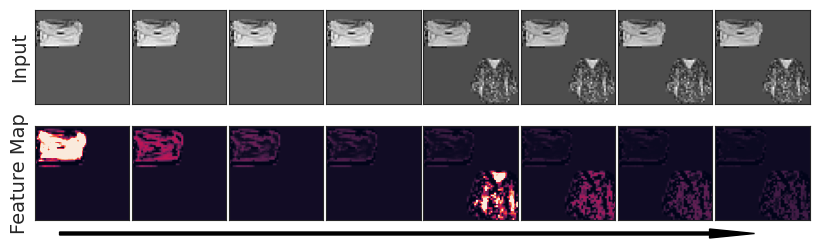

In [176]:
idx = 3
map = 2
sample = x[idx].permute((0, 2, 3, 1)).cpu()
fig, axes = plt.subplots(ncols=8, nrows=2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.03, hspace=0.01)

for i, ax in enumerate(axes[0]):
    ax.imshow(sample[i], cmap='gray')  # Set colormap to greyscale
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    
for i, ax in enumerate(axes[1]):
    ax.imshow(cache[f'hks.adapt_0_{i}'][idx, map].cpu(), vmin=0, vmax=1)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    
axes[0, 0].set_ylabel('Input', fontsize=14)
axes[1, 0].set_ylabel('Feature Map', fontsize=14)
    
# Drawing a long arrow
arrow = FancyArrow(0.15, 0.1, 0.65, 0, width=0.01, color='black', transform=fig.transFigure, clip_on=False)
fig.add_artist(arrow)

plt.savefig("figures/attn_005.svg", format='svg')

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


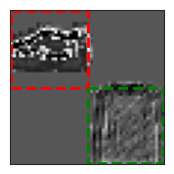

In [222]:
one_image_dataset = TwoImageTemporalDataset('test', onset_img_2=2, transform=transform,
                                            img_to_timesteps_transforms=timestep_transforms, contrast_1=.8,
                                            contrast_2=.8)
loader = DataLoader(one_image_dataset, batch_size=10, shuffle=True, num_workers=0)

x, y = next(iter(loader))
x = x.cuda()
y = y.cuda()
_, cache = div_norm_model.run_with_cache(x)

sample = cache[f'hks.adapt_{0}_{2}'].cpu()
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(sample[0, 9], cmap='gray')
ax.add_patch(plt.Rectangle((0, 0), 26, 26, fill=False, edgecolor='red', linestyle='--', linewidth=2))
ax.add_patch(plt.Rectangle((26, 26), 25, 25, fill=False, edgecolor='green', linestyle='--', linewidth=2))
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('figures/attn_007.svg')
plt.savefig('figures/attn_007.png')

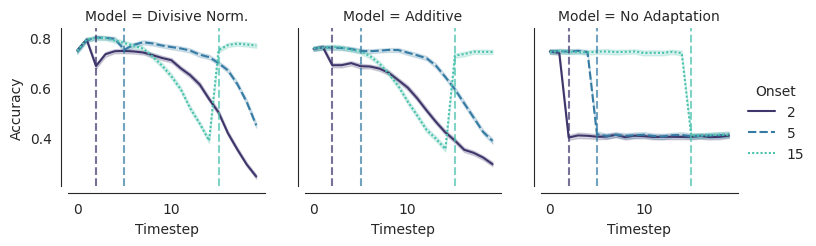

In [193]:
palette = sns.color_palette("mako", 3)
g = sns.relplot(data=df, x='Timestep', y='Accuracy', hue='Onset', col='Model', style='Onset', kind='line', height=2.5, palette=palette)
plt.subplots_adjust(wspace=0.2)
sns.despine(offset=5)

# Adding vertical dashed lines
unique_onsets = df['Onset'].unique()

# Loop through each subplot and add vertical lines
for model, ax in g.axes_dict.items():
    for onset, color in zip(unique_onsets, palette):
        ax.axvline(x=onset, color=color, linestyle='--', alpha=0.7)
plt.savefig('figures/attn_004.svg')
plt.savefig('figures/attn_004.png')

In [62]:
import pandas as pd

acc_dict = {'Contrast': [], 'Timestep': [], 'Accuracy': [], 'Onset': []}
for onset in [2, 5, 15]:
    for contrast in [0.2, 0.4, 0.6, 0.8, 1.0]:
        one_image_dataset = TwoImageTemporalDataset('train', onset_img_2=onset, transform=transform,
                                        img_to_timesteps_transforms=timestep_transforms, contrast_1=0.6, contrast_2=contrast)        
        loader = DataLoader(one_image_dataset, batch_size=64, shuffle=True, num_workers=3)
        
        acc_per_timestep = torch.zeros(20)
        j = 0
        for x, y in tqdm(loader):
            logits = model(x)
            for i in range(20):
                l = logits[:, i, :]
                t = y[:, i]
                preds = torch.argmax(l, dim=1)
                acc = accuracy(preds, t, task='multiclass', num_classes=10)
                acc_per_timestep[i] += acc
                acc_dict['Contrast'].append(contrast)
                acc_dict['Timestep'].append(i)
                acc_dict['Accuracy'].append(float(acc))
                acc_dict['Onset'].append(onset)
            j += 1
            if j > 50:
                break
df = pd.DataFrame(acc_dict)
df

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  5%|▌         | 50/938 [00:53<15:51,  1.07s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  5%|▌         | 50/938 [00:54<16:13,  1.10s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  5%|▌         | 50/938 [00:54<16:01,  1.08s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  5%|▌         | 50/938 [00:54<16:16,  1.10s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/data

contrast  timestep  accuracy  onset
0           0.2         0  0.812500      2
1           0.2         1  0.750000      2
2           0.2         2  0.640625      2
3           0.2         3  0.578125      2
4           0.2         4  0.625000      2
...         ...       ...       ...    ...
15295       1.0        15  0.515625     15
15296       1.0        16  0.500000     15
15297       1.0        17  0.562500     15
15298       1.0        18  0.515625     15
15299       1.0        19  0.562500     15

[15300 rows x 4 columns]

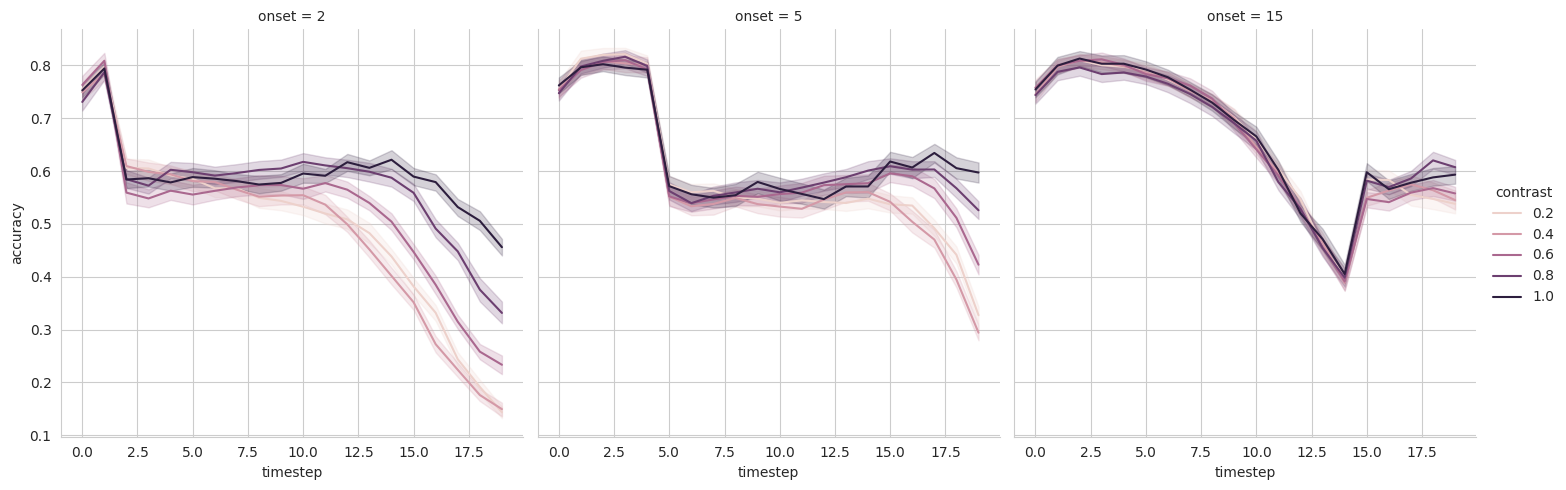

In [63]:
sns.relplot(data=df, x='timestep', y='accuracy', hue='contrast', col='onset', kind='line')

# Receptive Fields

In [250]:
actv_df = pd.DataFrame({'Model': [], 'Timestep': [], 'Layer': [], 'Mean': [], 'Norm': [], 'num_active': [], 'mean_not_null': [], 'Onset': [], 'Region': []})
for onset in [2, 5, 15]:
    two_image_dataset = TwoImageTemporalDataset('test', onset_img_2=onset, transform=transform,
                                    img_to_timesteps_transforms=timestep_transforms, contrast_1=0.6, contrast_2='random')        
    loader = DataLoader(two_image_dataset, batch_size=100, shuffle=False, num_workers=10, worker_init_fn=worker_init_fn)
        
    for x, y in tqdm(loader):
        x = x.cuda()
        y = y.cuda()
        for name, model in models.items():
            model.cuda()
            logits, cache = model.run_with_cache(x)
            for layer in range(4):
                for timestep in range(20):
                    actv = cache[f'hks.adapt_{layer}_{timestep}'] # batch channel width height
                    width = actv.shape[-1]
                    upper_left = actv[..., :width // 2, :width // 2]
                    lower_right = actv[..., width // 2:, width // 2:]
                    for region in ['ul', 'lr', 'both']:
                        if region == 'ul':
                            cur_actv = upper_left
                        elif region == 'lr':
                            cur_actv = lower_right
                        elif region == 'both':
                            cur_actv = actv
                        else:
                            raise ValueError('region can only be ul, lr, or both')
                            
                        actv_df.loc[len(actv_df)] = [
                            name, timestep, layer, float(cur_actv.mean()), float(cur_actv.norm()),
                            float((cur_actv > 1e-4).sum()), float(cur_actv[cur_actv > 1e-4].mean()),
                            onset, region
                        ]
actv_df

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 100/100 [03:22<00:00,  2.02s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 100/100 [05:36<00:00,  3.36s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
 51%|█████     | 51/100 [04:05<04:03,  4.96s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa925d077f0>
Traceback (most recent call last):
  File "/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/var/local/gl

KeyboardInterrupt: 

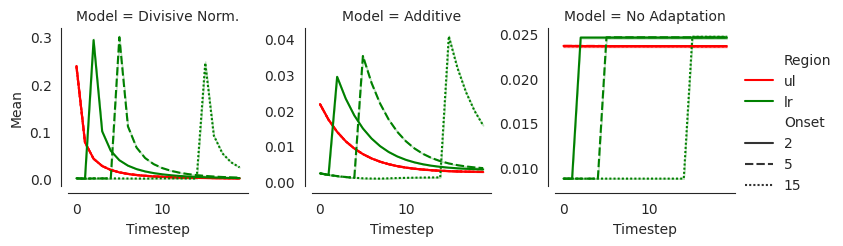

In [262]:
palette = ['red', 'green']
sns.relplot(data=actv_df[(actv_df.Layer==1) & (actv_df.Region.isin(['ul', 'lr']))], x='Timestep', y='Mean', hue='Region', style='Onset', col='Model', kind='line', height=2.5, facet_kws={'sharey': False}, palette=palette)
sns.despine(offset=5)

plt.savefig('figures/attn_008.svg')
plt.savefig('figures/attn_008.png')

In [255]:
actv_df

Model  Timestep  Layer      Mean         Norm  num_active   
0       Divisive Norm.         0      0  0.191935   678.193176    741416.0  \
1       Divisive Norm.         0      0  0.140904   522.052124    946379.0   
2       Divisive Norm.         0      0  0.154103  1132.556274   3568711.0   
3       Divisive Norm.         1      0  0.084300   256.865936    724863.0   
4       Divisive Norm.         1      0  0.074528   238.307556    946379.0   
...                ...       ...    ...       ...          ...         ...   
181055        Additive        11      1  0.001674    12.656811    128468.0   
181056        Additive        12      1  0.003244    11.166800     25271.0   
181057        Additive        12      1  0.001130     2.343576     36176.0   
181058        Additive        12      1  0.001637    11.948482    128519.0   
181059        Additive        13      1  0.003066    10.581401     25077.0   

        mean_not_null  Onset Region  
0            0.560000      2     ul  
1            0.322073      2     lr  
2            0.373642      2   both  
3            0.251575      2     ul  
4            0.170353      2     lr  
...               ...    ...    ...  
181055       0.020176     15   both  
181056       0.049698     15     ul  
181057       0.012090     15     lr  
181058       0.019722     15   both  
181059       0.047333     15     ul  

[181060 rows x 9 columns]

In [68]:
actv_dict = {'contrast': [], 'timestep': [], 'layer': [], 'mean': [], 'num_active': [], 'mean_not_null': [], 'onset': [], 'region': []}
for onset in [2, 5, 15]:
    for contrast in [0.2, 0.4, 0.6, 0.8, 1.0]:
        two_image_dataset = TwoImageTemporalDataset('train', onset_img_2=onset, transform=transform,
                                        img_to_timesteps_transforms=timestep_transforms, contrast_1=0.6, contrast_2=contrast)        
        loader = DataLoader(two_image_dataset, batch_size=500, shuffle=True, num_workers=3)
        
        j = 0
        for x, y in tqdm(loader):
            logits, cache = model.model.run_with_cache(x)
            for layer in range(4):
                for timestep in range(20):
                    actv = cache[f'hks.adapt_{layer}_{timestep}'] # batch channel width height
                    width = actv.shape[-1]
                    upper_left = actv[..., :width // 2, :width // 2]
                    lower_right = actv[..., width // 2:, width // 2:]
                    for region in ['ul', 'lr', 'both']:
                        actv_dict['contrast'].append(contrast)
                        actv_dict['timestep'].append(timestep)
                        actv_dict['layer'].append(layer)
                        if region == 'ul':
                            cur_actv = upper_left
                        elif region == 'lr':
                            cur_actv = lower_right
                        elif region == 'both':
                            cur_actv = actv
                        else:
                            raise ValueError('region can only be ul, lr, or both')
                            
                        actv_dict['mean'].append(cur_actv.mean())
                        actv_dict['num_active'].append((cur_actv > 1e-4).sum())
                        actv_dict['mean_not_null'].append(cur_actv[cur_actv > 1e-4].mean())      
                        actv_dict['onset'].append(onset)
                        actv_dict['region'].append(region)
                    
                    
            j += 1
            if j > 10:
                break
actv_df = pd.DataFrame(actv_dict)
actv_df


Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  8%|▊         | 10/120 [03:16<35:56, 19.61s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  8%|▊         | 10/120 [03:28<38:08, 20.81s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  8%|▊         | 10/120 [03:31<38:43, 21.12s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  8%|▊         | 10/120 [03:24<37:25, 20.41s/it]
Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/data

contrast  timestep  layer            mean        num_active   
0           0.2         0      0  tensor(0.1925)   tensor(3663989)  \
1           0.2         0      0  tensor(0.1409)   tensor(4731843)   
2           0.2         0      0  tensor(0.1543)  tensor(17795863)   
3           0.2         1      0  tensor(0.0847)   tensor(3581139)   
4           0.2         1      0  tensor(0.0745)   tensor(4731843)   
...         ...       ...    ...             ...               ...   
39595       1.0        18      3  tensor(0.0838)      tensor(7414)   
39596       1.0        18      3  tensor(0.0447)     tensor(22485)   
39597       1.0        19      3  tensor(0.0199)      tensor(5980)   
39598       1.0        19      3  tensor(0.0728)      tensor(7718)   
39599       1.0        19      3  tensor(0.0408)     tensor(25873)   

        mean_not_null  onset region  
0      tensor(0.5683)      2     ul  
1      tensor(0.3221)      2     lr  
2      tensor(0.3750)      2   both  
3      tensor(0.2557)      2     ul  
4      tensor(0.1704)      2     lr  
...               ...    ...    ...  
39595  tensor(0.1807)     15     lr  
39596  tensor(0.1273)     15   both  
39597  tensor(0.0531)     15     ul  
39598  tensor(0.1509)     15     lr  
39599  tensor(0.1008)     15   both  

[39600 rows x 8 columns]

In [69]:
actv_df['mean'] = [float(val) for val in actv_df['mean']]
actv_df['num_active'] = [float(val) for val in actv_df['num_active']]
actv_df['mean_not_null'] = [float(val) for val in actv_df['mean_not_null']]

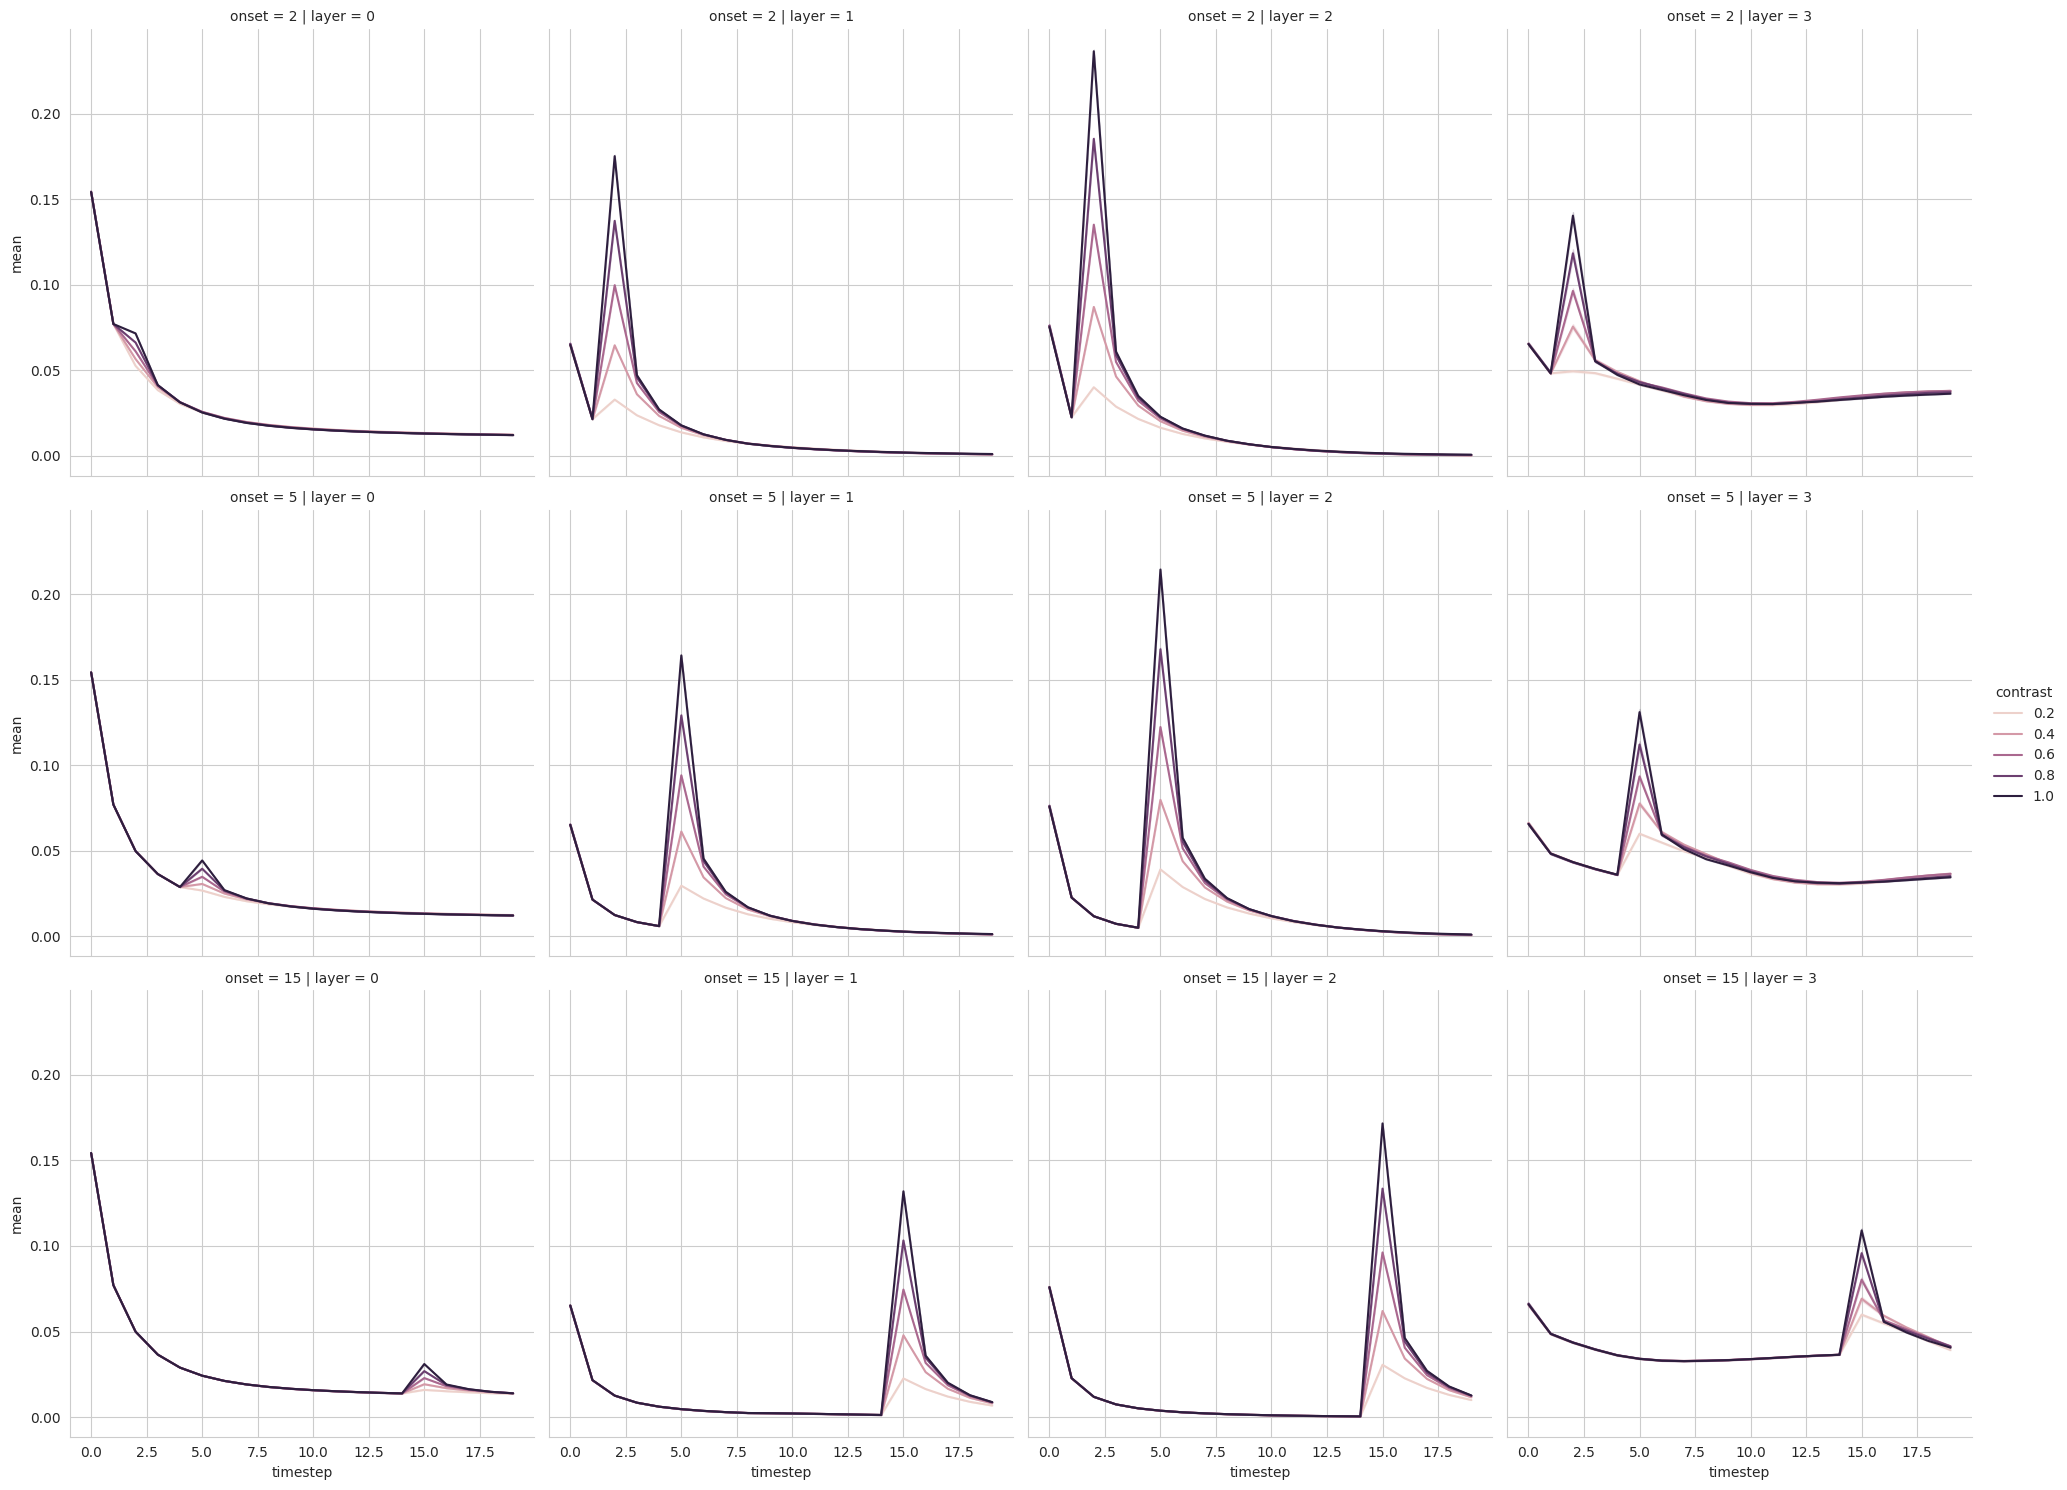

In [72]:
sns.relplot(data=actv_df[actv_df.region=='both'], x='timestep', y='mean', hue='contrast', kind='line', col='layer', row='onset')

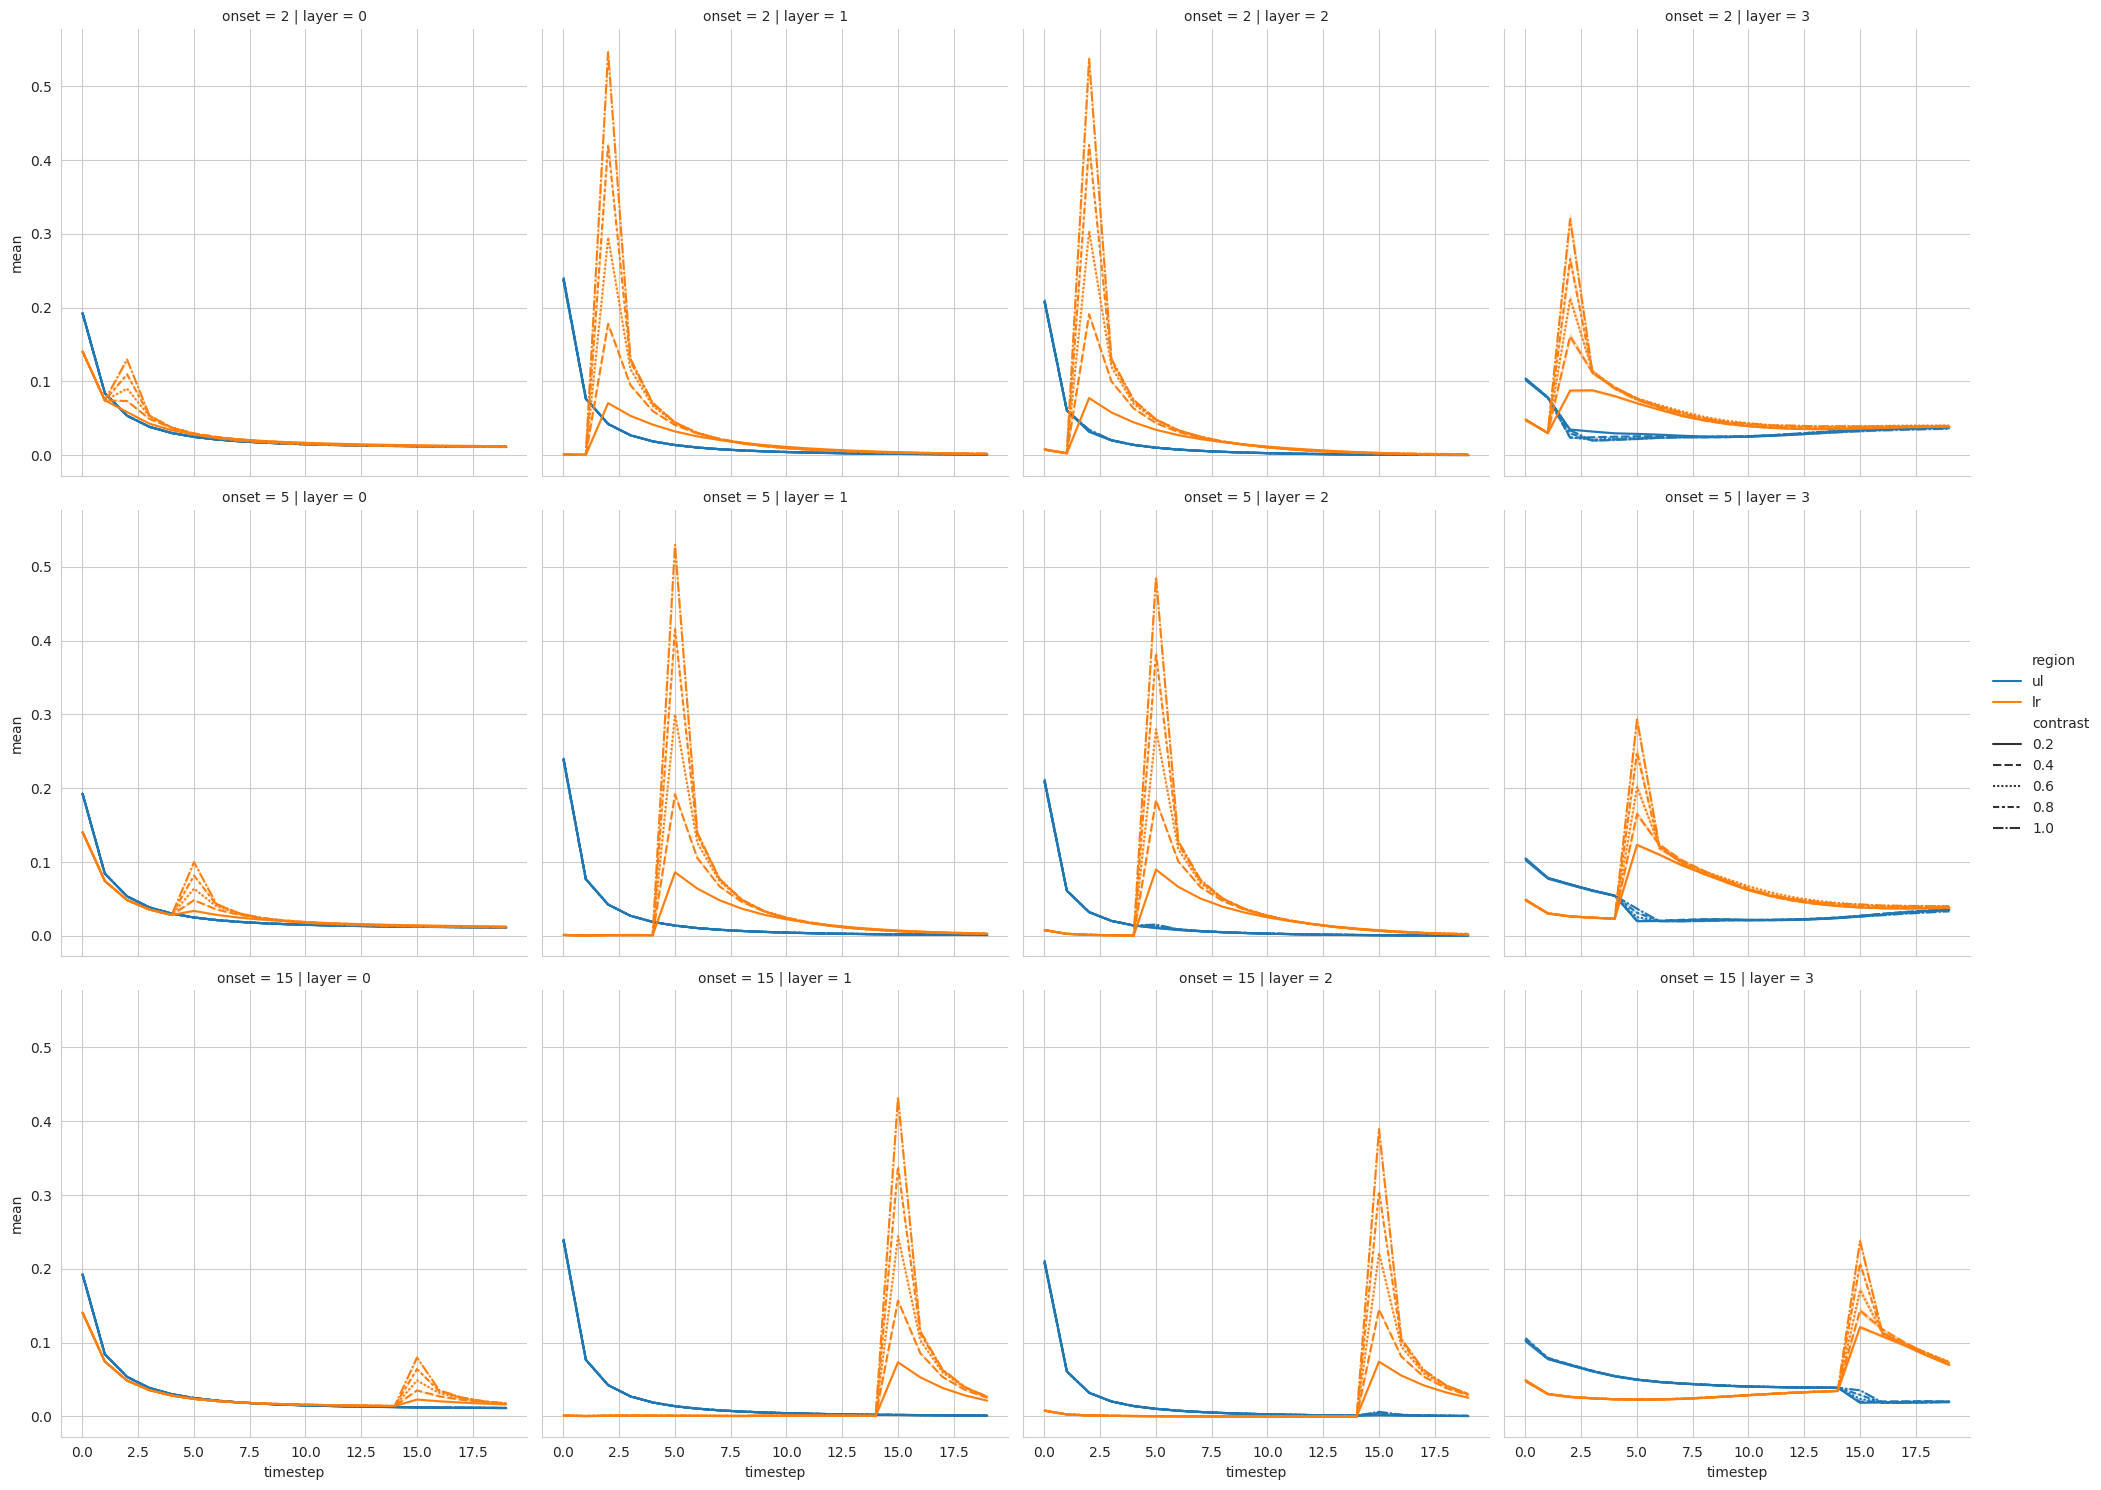

In [75]:
sns.relplot(data=actv_df[actv_df.region.isin(['ul', 'lr'])], x='timestep', y='mean', hue='region', kind='line', col='layer', row='onset', style='contrast')

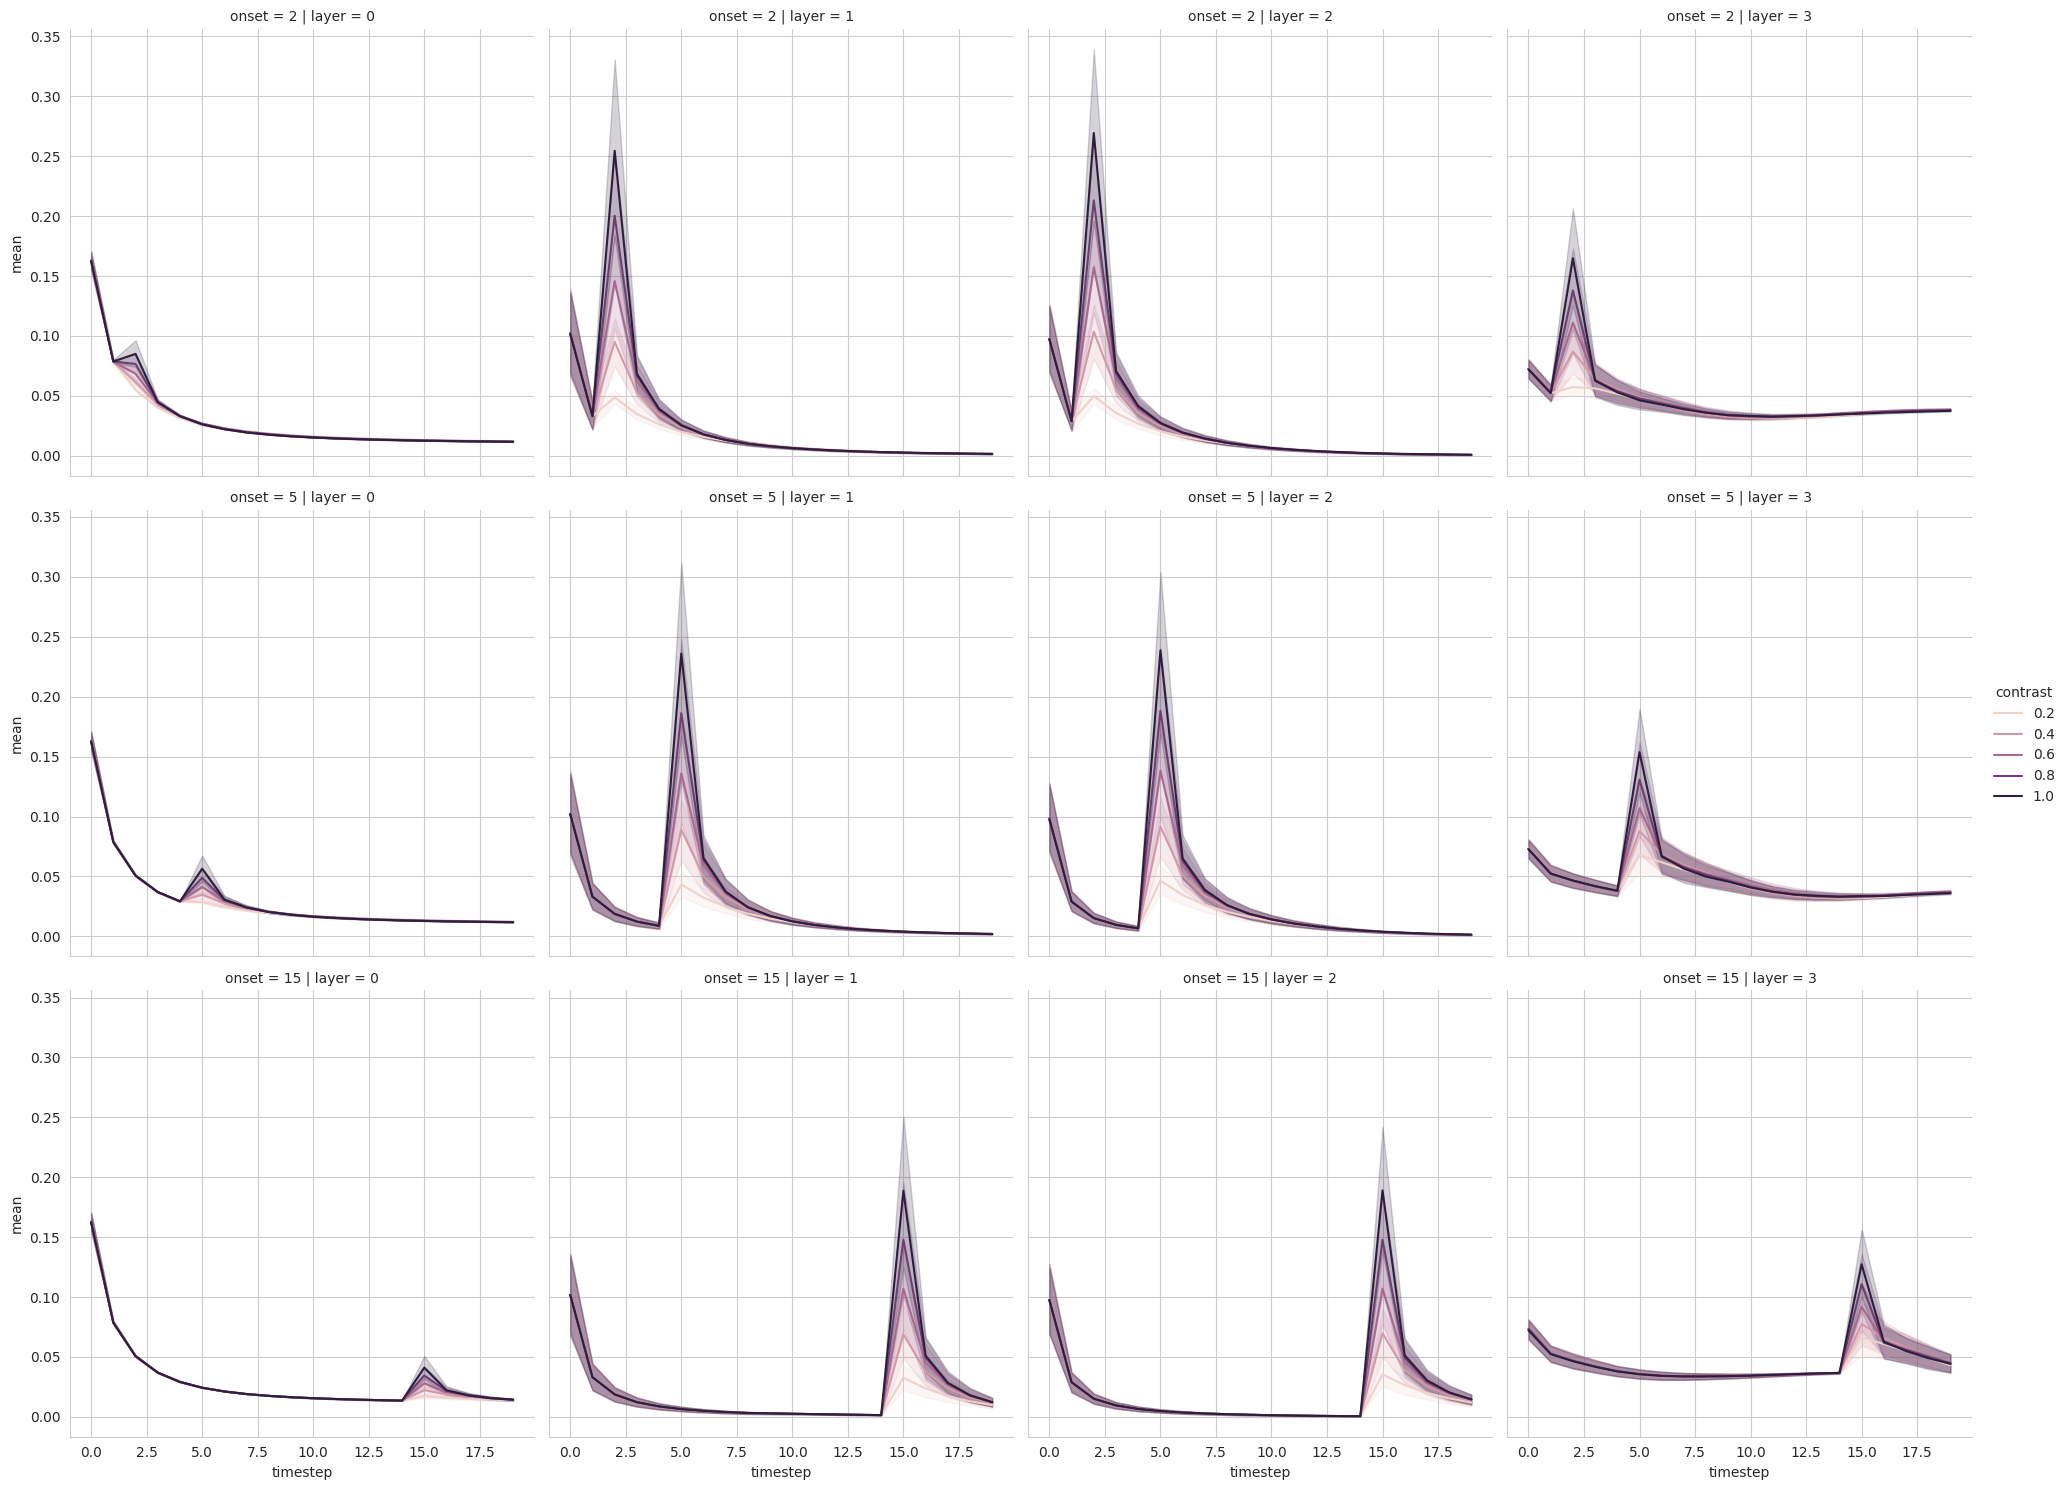

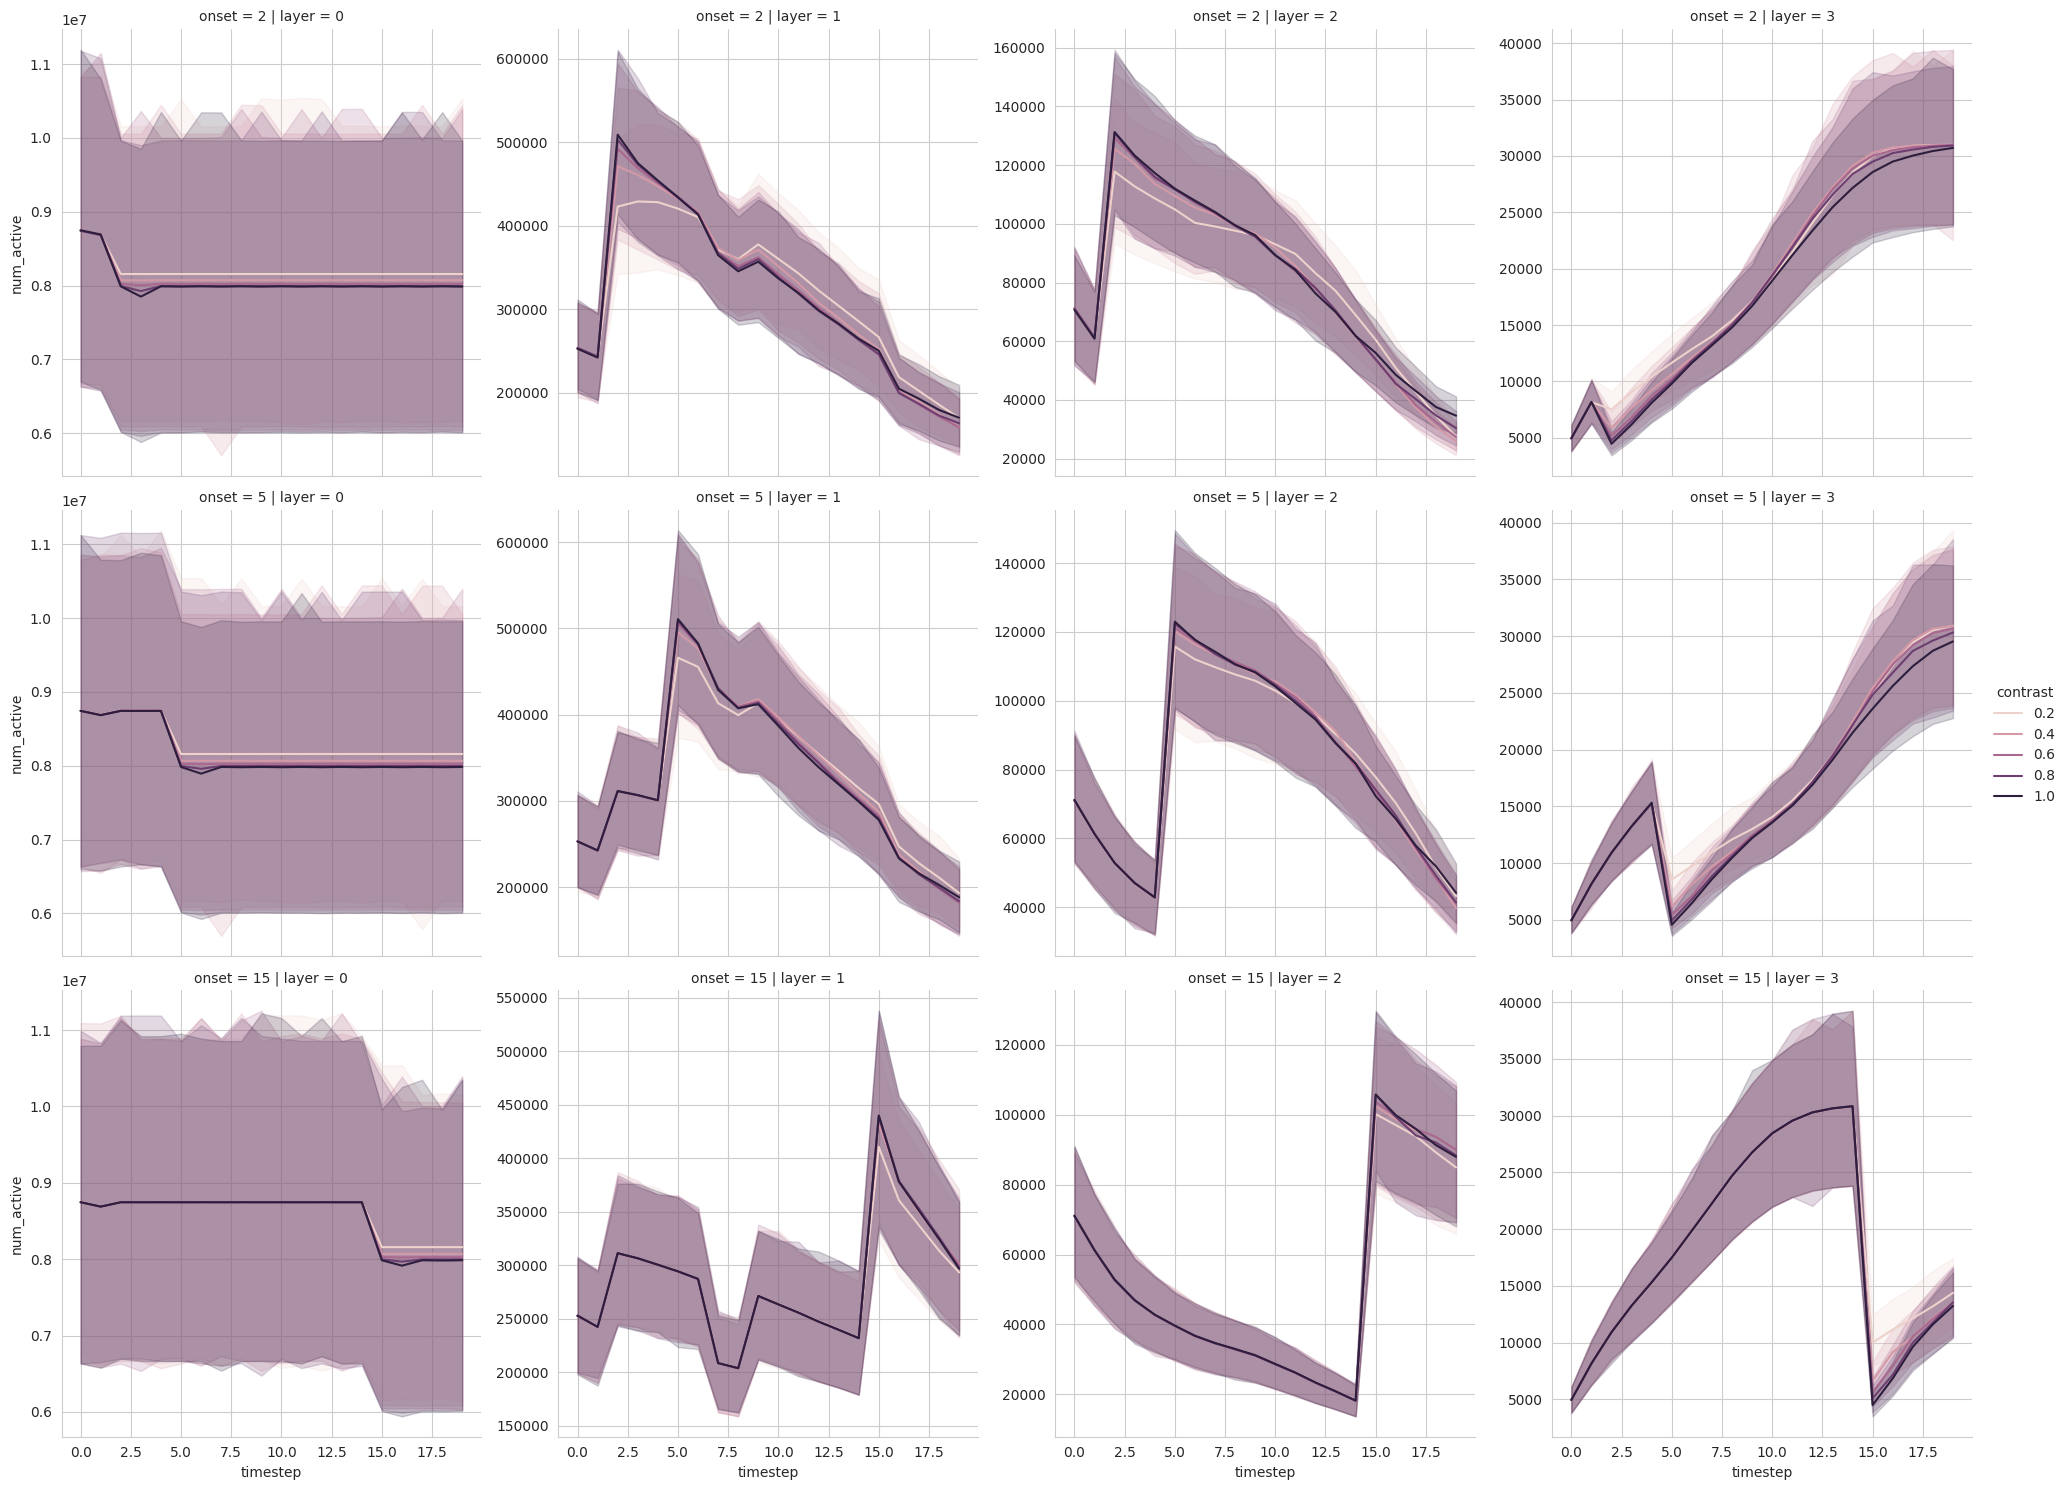

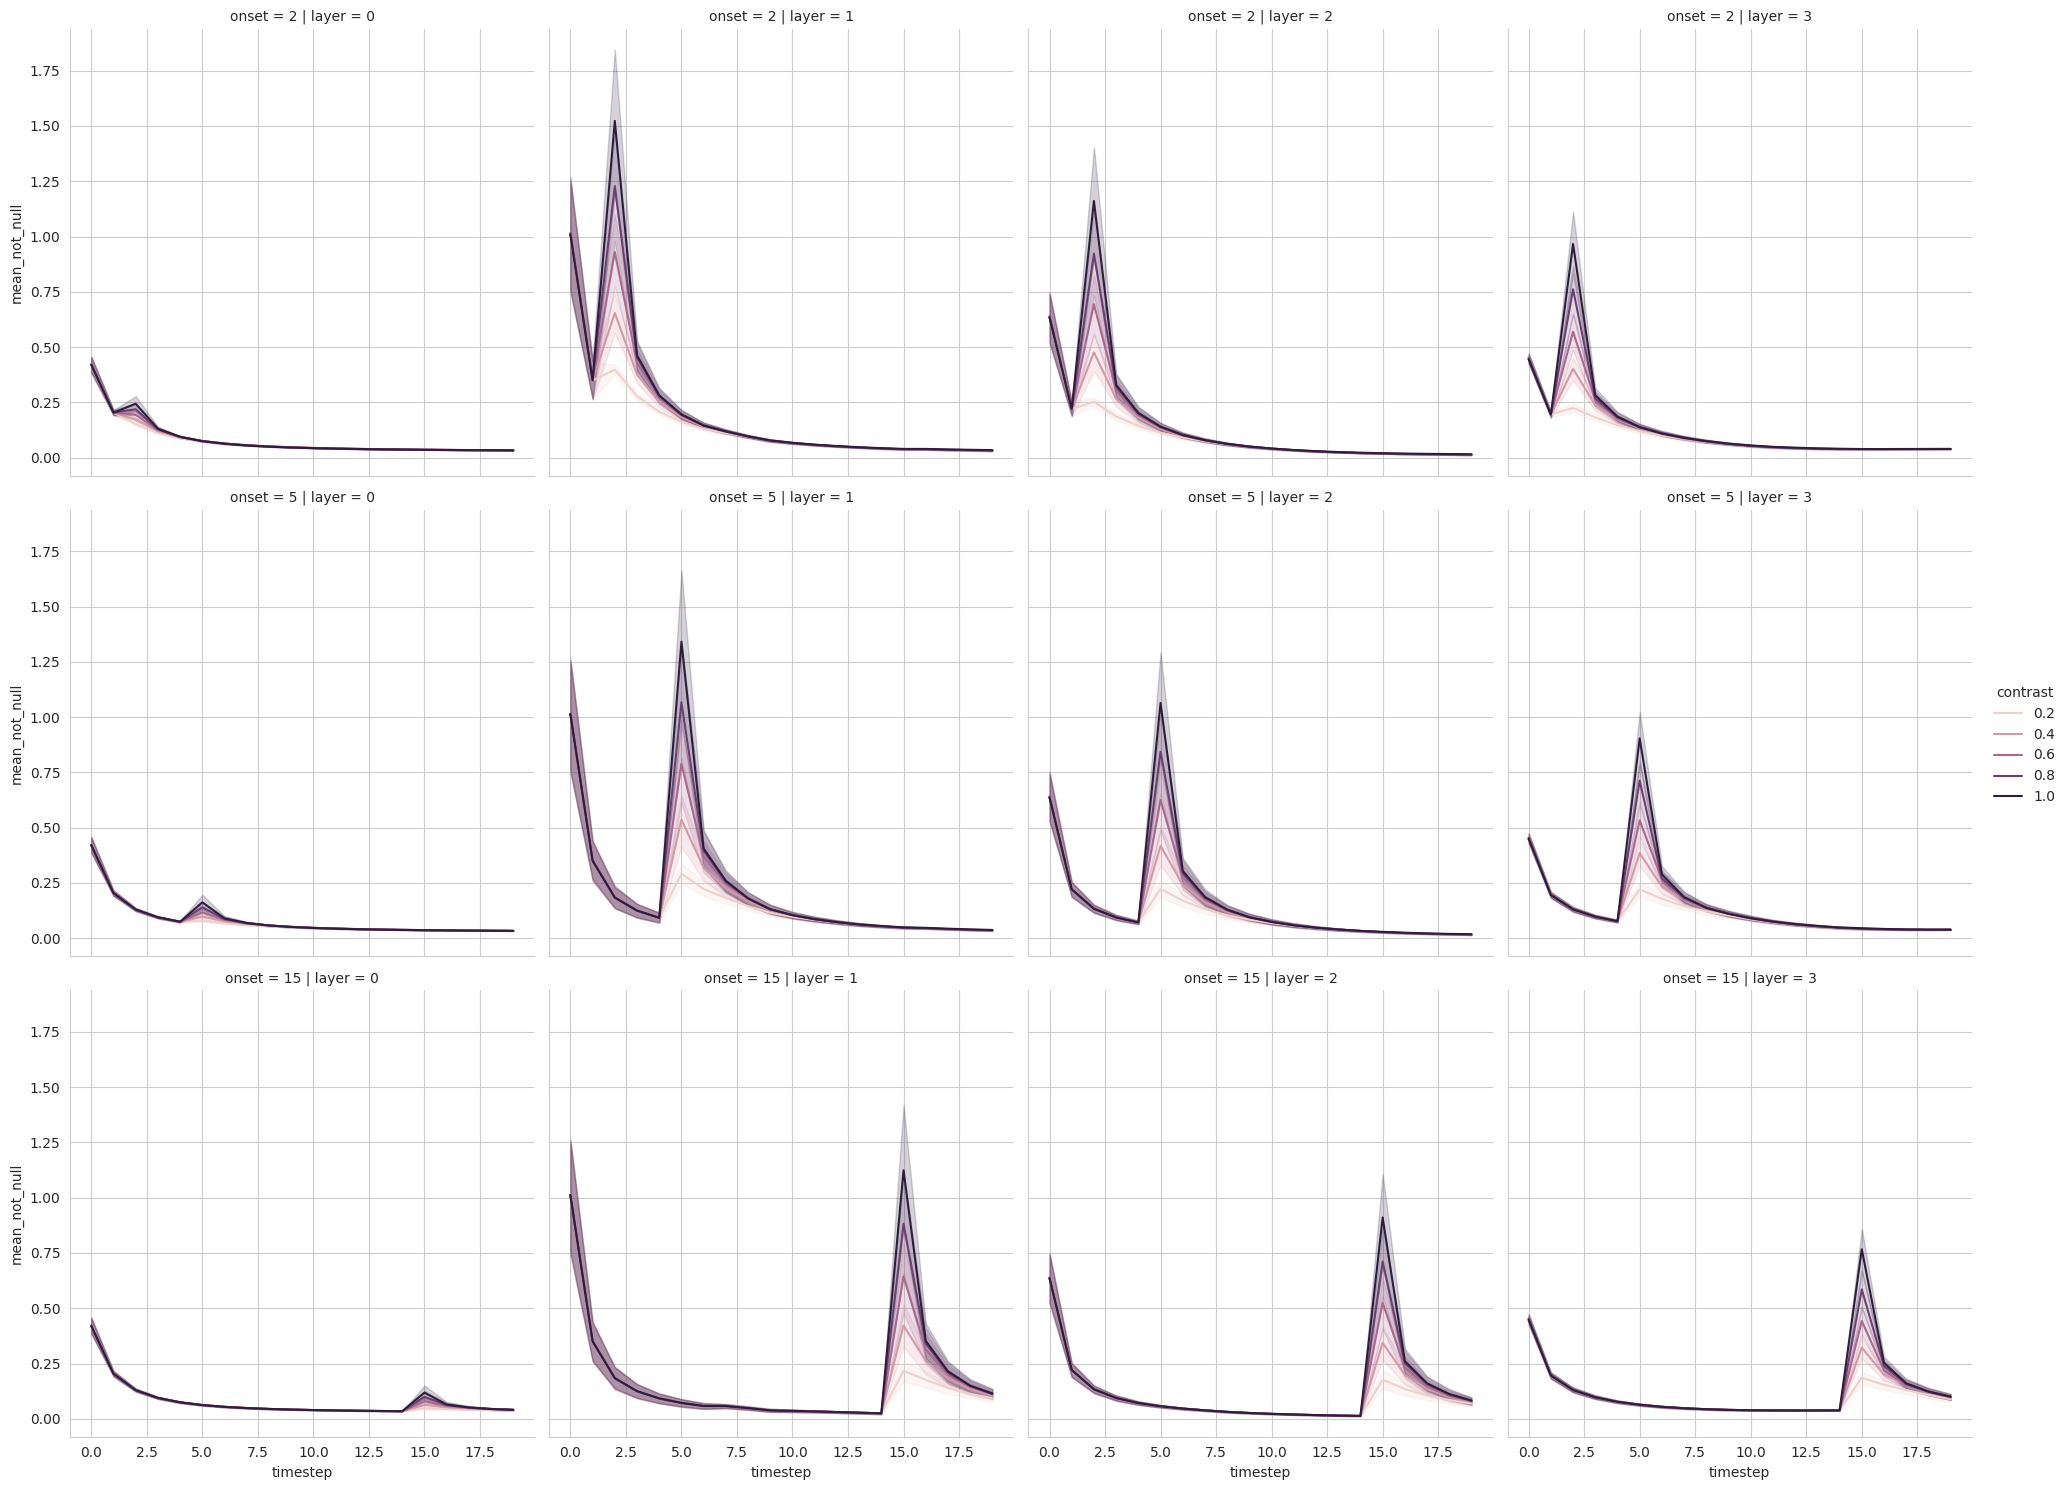

In [71]:
sns.relplot(data=actv_df[actv_df.region=='both'], x='timestep', y='mean', hue='contrast', kind='line', col='layer', row='onset')
plt.show()
sns.relplot(data=actv_df, x='timestep', y='num_active', hue='contrast', kind='line', col='layer',
            facet_kws={'sharey': False}, row='onset')
plt.show()
sns.relplot(data=actv_df, x='timestep', y='mean_not_null', hue='contrast', kind='line', col='layer', row='onset')

In [77]:
os.mkdir('trained_models')
actv_df.to_csv('trained_models/video_activation_data.csv')

## Causal Experiments

In [18]:
from tqdm import tqdm
# actv_dict = {'contrast': [], 'timestep': [], 'layer': [], 'mean': [], 'num_active': [], 'mean_not_null': [], 'onset': [], 'region': []}
res = {'Intervention': [], 'Accuracy': [], 'Image': [], 'Mean': [], 'Model': []}
def hook_fn(actv, hook):
    # batch map width height
    # ratio = actv[..., 26:, 26:].mean() / actv[..., :26, :26].mean()  # big / small
    mid = actv.shape[-1] // 2
    ratio = actv[..., mid:, mid:].mean(dim=(-1, -2), keepdim=True)/ (actv[..., :mid, :mid].mean(dim=(-1, -2), keepdim=True) + 1e-5)
    actv[..., :mid, :mid] *= ratio
    actv[..., mid:, mid:] /= ratio + 1e-5
    return actv

def acc(logits, target, timestep):
    logits = logits[:, timestep, :]
    preds = torch.argmax(logits, dim=1)
    acc = accuracy(preds, target, task='multiclass', num_classes=10)
    return acc
        
    
onset = 2
# for contrast in [0.2, 0.4, 0.6, 0.8, 1.0]:
contrast = 0.6
two_image_dataset = TwoImageTemporalDataset('train', onset_img_2=onset, transform=transform,
                                img_to_timesteps_transforms=timestep_transforms, contrast_1=0.6, contrast_2=contrast)        
loader = DataLoader(two_image_dataset, batch_size=5, shuffle=True, num_workers=0)

j = 0
for x, y in tqdm(loader):
    x = x.cuda()
    y = y.cuda()
    for name, model in models.items():
        model.cuda()
        logits_clean, cache_clean = model.run_with_cache(x)
        res['Intervention'].append(False)
        res['Accuracy'].append(float(acc(logits_clean, y[:, onset], onset)))
        res['Image'].append('second')
        res['Mean'].append(float(cache_clean[f'hks.adapt_0_{onset}'][..., 26:, 26:].mean()))
        
        res['Intervention'].append(False)
        res['Accuracy'].append(float(acc(logits_clean, y[:, 0], onset)))
        res['Image'].append('first')
        res['Mean'].append(float(cache_clean[f'hks.adapt_0_{onset}'][..., :26, :26].mean()))
        
        with model.hooks([(f'hks.adapt_0_{onset}', hook_fn)]):
            logits_swapped, cache_swapped = model.run_with_cache(x)
            res['Intervention'].append(True)
            res['Accuracy'].append(float(acc(logits_swapped, y[:, onset], onset)))
            res['Image'].append('second')
            res['Mean'].append(float(cache_swapped[f'hks.adapt_0_{onset}'][..., 26:, 26:].mean()))
            
            res['Intervention'].append(True)
            res['Accuracy'].append(float(acc(logits_swapped, y[:, 0], onset)))
            res['Image'].append('first')          
            res['Mean'].append(float(cache_swapped[f'hks.adapt_0_{onset}'][..., :26, :26].mean()))
            
        res['Model'].append(name)
        res['Model'].append(name)
        res['Model'].append(name)
        res['Model'].append(name)
                
    j += 1
    if j >= 200:
        break
causal_df = pd.DataFrame(res)
causal_df


Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
  2%|▏         | 199/12000 [01:01<1:00:48,  3.23it/s]


Intervention  Accuracy   Image      Mean           Model
0            False       0.8  second  0.085396  Divisive Norm.
1            False       0.2   first  0.054236  Divisive Norm.
2             True       0.4  second  0.054016  Divisive Norm.
3             True       0.6   first  0.085332  Divisive Norm.
4            False       1.0  second  0.032255        Additive
...            ...       ...     ...       ...             ...
2395          True       0.6   first  0.042723        Additive
2396         False       0.8  second  0.023053   No Adaptation
2397         False       0.4   first  0.025024   No Adaptation
2398          True       0.8  second  0.025029   No Adaptation
2399          True       0.4   first  0.023046   No Adaptation

[2400 rows x 5 columns]

In [81]:
onset = 5
two_image_dataset = TwoImageTemporalDataset('train', onset_img_2=onset, transform=transform,
                                img_to_timesteps_transforms=timestep_transforms, contrast_1=0.6, contrast_2=0.6)        
loader = DataLoader(two_image_dataset, batch_size=5, shuffle=True, num_workers=0)

j = 0
x, y = next(iter(loader))
x = x.cuda()
y = y.cuda()
logits_clean, cache_clean = div_norm_model.run_with_cache(x)
        
with div_norm_model.hooks([(f'hks.adapt_0_{onset}', hook_fn)]):
    logits_swapped, cache_swapped = div_norm_model.run_with_cache(x)

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


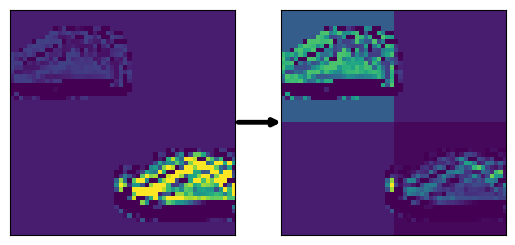

In [95]:
idx = 2
map = 14
onset = 5
clean = cache_clean[f'hks.adapt_0_{onset}'][idx, map].cpu()
corr = cache_swapped[f'hks.adapt_0_{onset}'][idx, map].cpu()

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(clean, vmin=0, vmax=.7)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(corr, vmin=0, vmax=.7)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].annotate('', xy=(1.215, 0.5), xycoords='axes fraction', xytext=(1, 0.5),
               arrowprops=dict(arrowstyle="->", lw=3.5))

plt.savefig('figures/attn_009.svg')
plt.savefig('figures/attn_009.png')

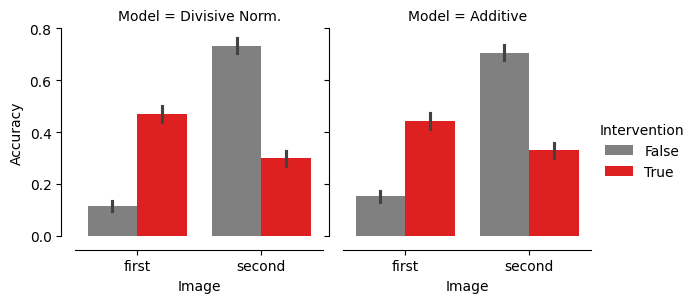

In [31]:
sns.catplot(data=causal_df, x='Image', y='Accuracy', hue='Intervention', order=['first', 'second'], kind='bar', col='Model', col_order=['Divisive Norm.', 'Additive'], height=3, palette=['grey', 'red'])
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.tight_layout()
sns.despine(offset=10)

plt.savefig('figures/attn_10.svg')
plt.savefig('figures/attn_10.png')

<Axes: xlabel='Image', ylabel='Mean'>

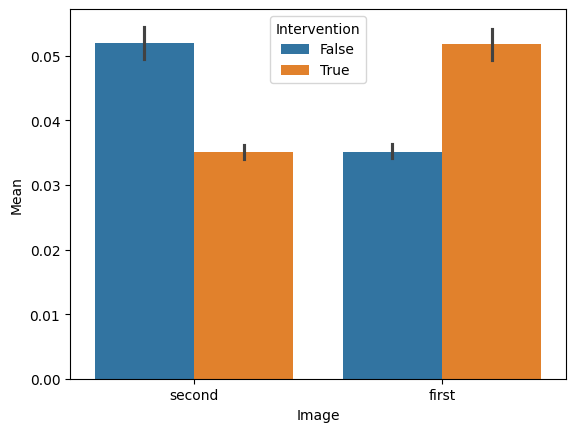

In [77]:
sns.barplot(data=causal_df, x='Image', y='Mean', hue='Intervention')


### Explanation of the experiment

* hypothesis: the model encodes the saliency of an event in its scale
* this is what we want: if the model uses the div norm layer correctly, activations are the same but get suppressed such that novel stimuli have higher activation
* if we switch the scale of the activations in the receptive field, we would expect that the model suddenly predicts the other image
* to do this, we computed accuracy at the timestep 2, where the second object occurred for the label of the first and the second image
* acc for the second image is high as the first one is suppressed
* then, we intervene on the output of the first layer and scale the receptive field of each object such that the activations of the first image are now as high as the second images activations and vice versa
* we compute the ratio per feature map and sample
* we show that this effectively reverses the models prediction and the model now predicts the first image which has high activations

## What's up with layer 3?

* layer 3 keeps stable activations and no real suppression is shown
* but I verified that the div norm state is zero at all times, so it definitely relies on the very small activations
* below, I verified that acc drops to chance level if you ablate layer 1 output in one of the steps where activations are super low
* possibly, layer 3 tries to make activations same size because otherwise the fc layer would have a hard time
* 

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)

  1%|          | 5/600 [00:52<1:44:20, 10.52s/it]


(0.0, 1.0)

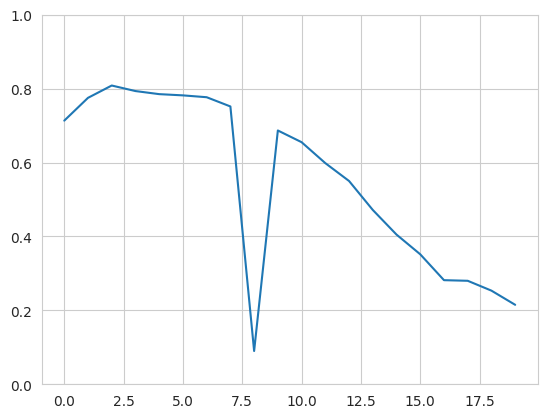

In [134]:
one_image_dataset = OneImageTemporalDataset('train', transform=transform,
                                            img_to_timesteps_transforms=timestep_transforms)
loader = DataLoader(one_image_dataset, batch_size=100, shuffle=True, num_workers=3)

def hook_fn(actv, hook):
    # batch map width height
    # ratio = actv[..., 26:, 26:].mean() / actv[..., :26, :26].mean()  # big / small
    actv *= 0.
    return actv

acc_per_timestep = torch.zeros(20)
total = torch.zeros(1)
j = 0
onset = 8
for x, y in tqdm(loader):
    with model.model.hooks([(f'hks.adapt_0_{onset}', hook_fn)]):
        logits = model.model(x)
    for i in range(20):
        l = logits[:, i, :]
        t = y[:, 0]
        preds = torch.argmax(l, dim=1)
        acc = accuracy(preds, t, task='multiclass', num_classes=10)
        acc_per_timestep[i] += acc
    total += 1
    j += 1
    if j > 5:
        break
acc_per_timestep /= total

sns.lineplot(acc_per_timestep)
plt.ylim(0, 1)

# Exponential Decay

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning:

Checkpoint directory ./ai-thesis/7koxkjvc/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name               

Sanity Checking: 0it [00:00, ?it/s]

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning:

Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.



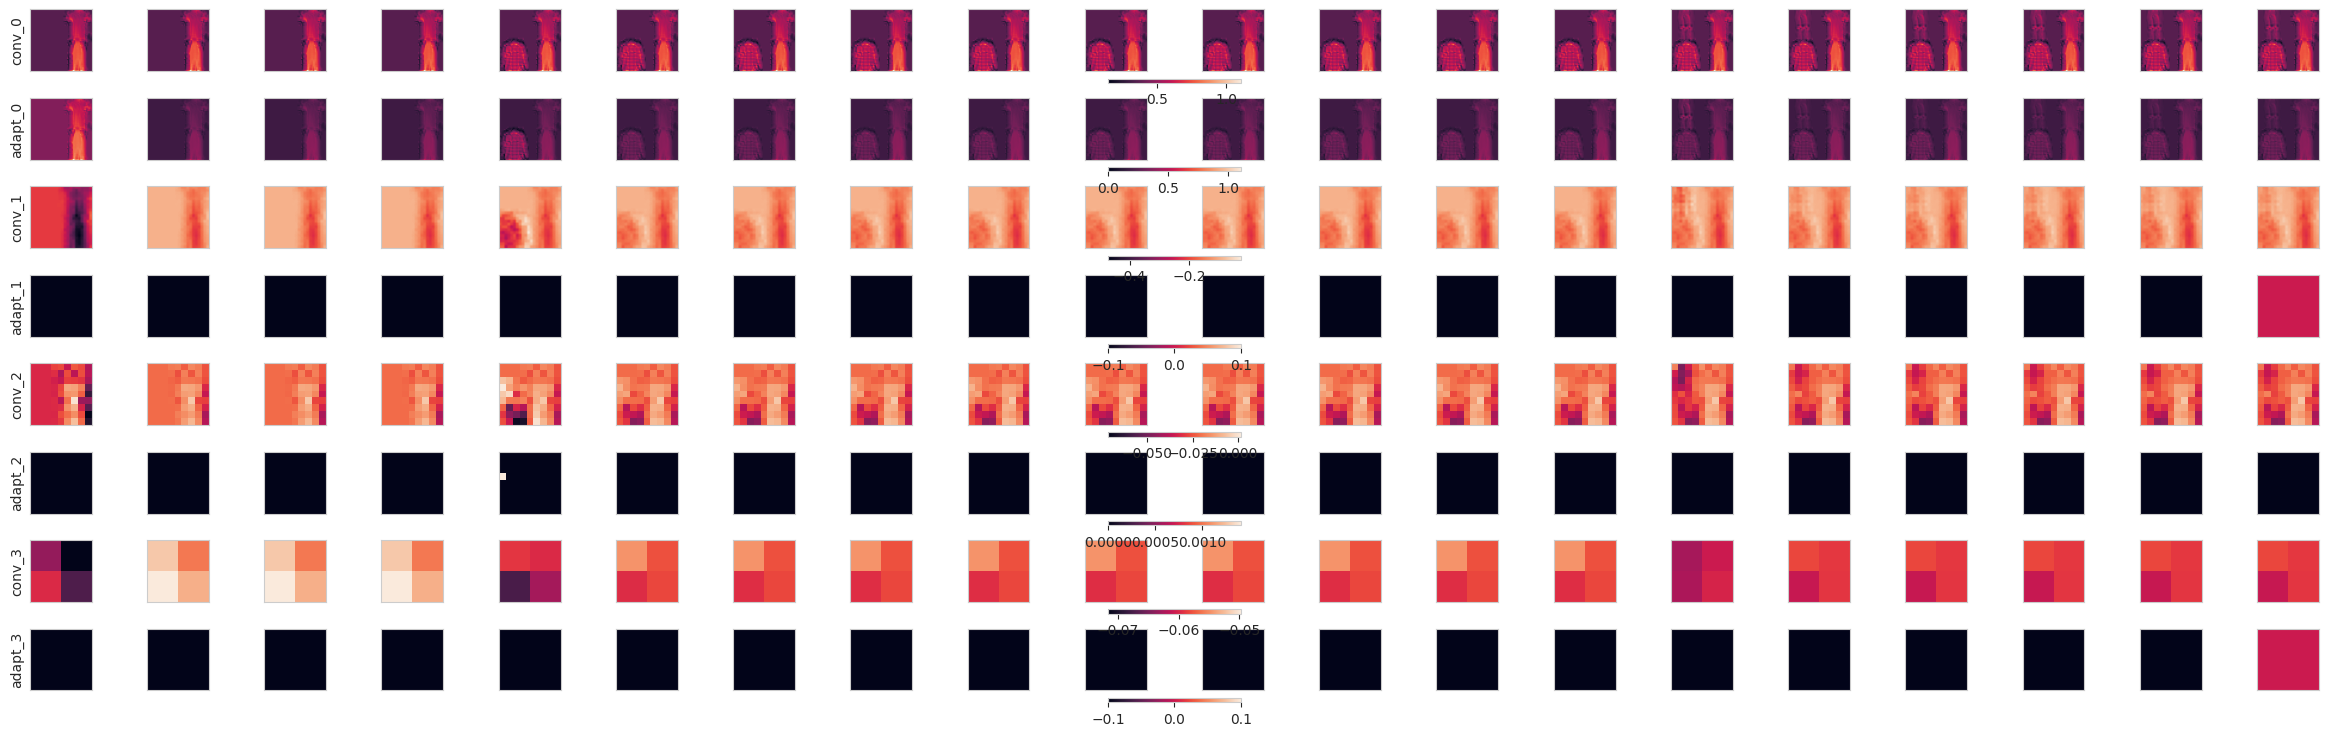

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

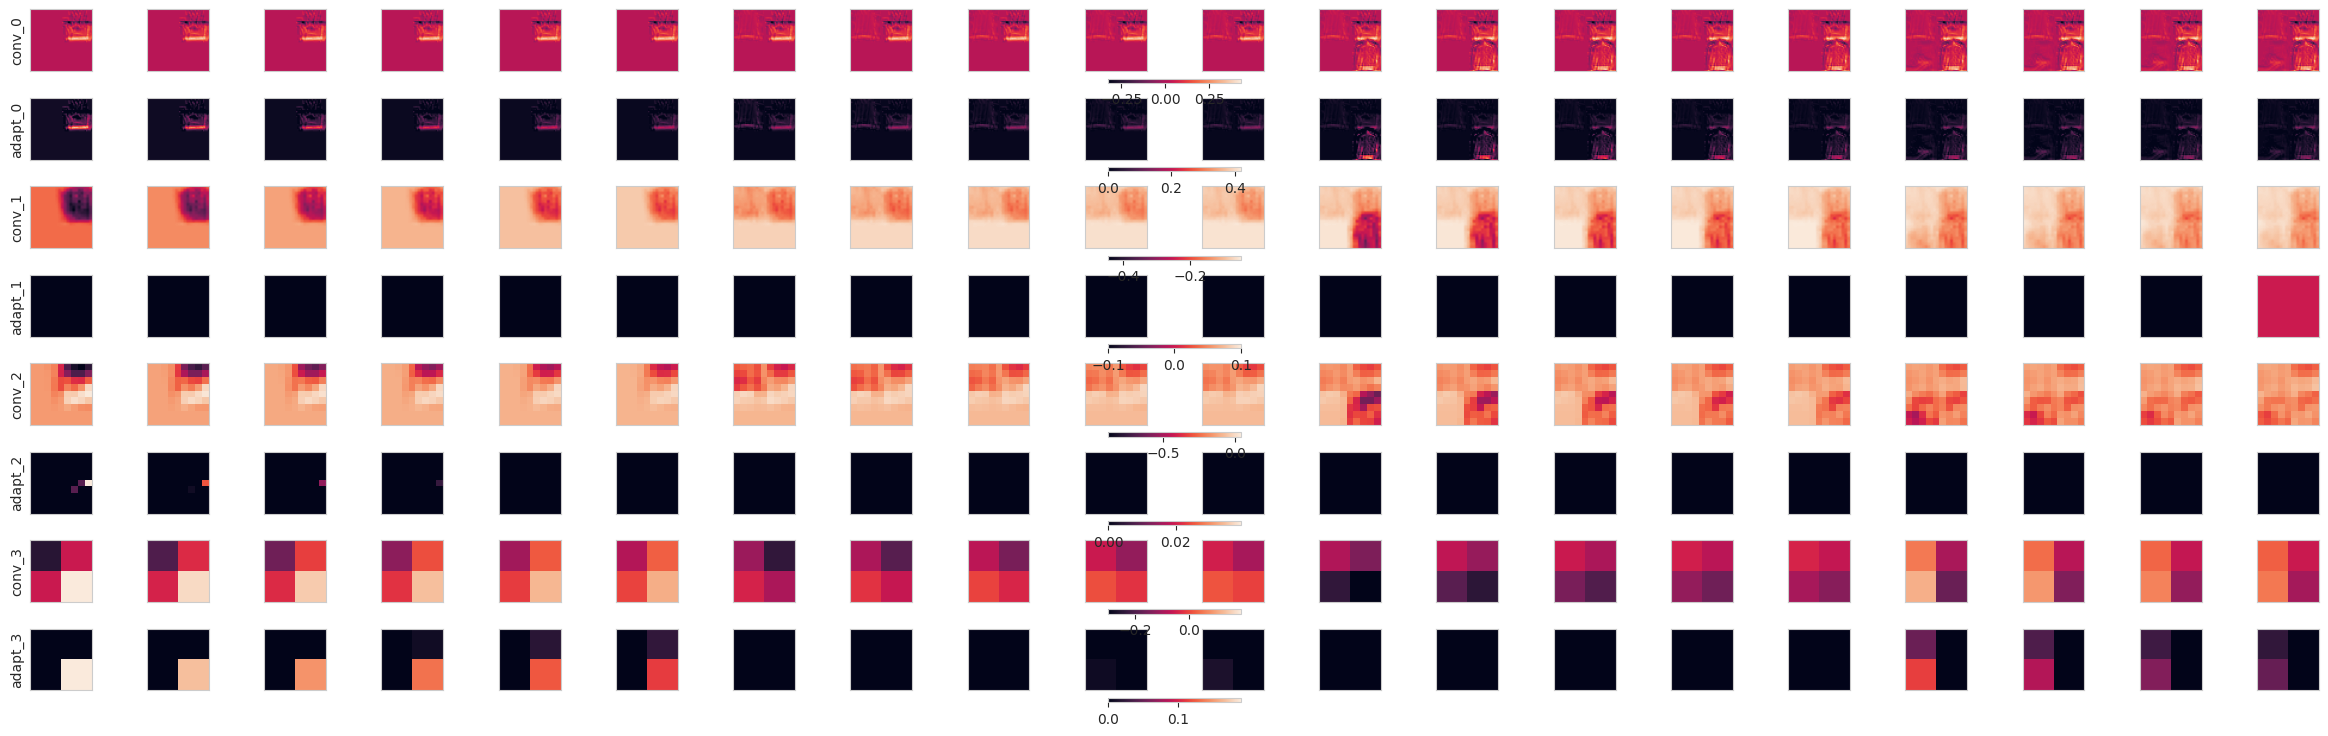

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

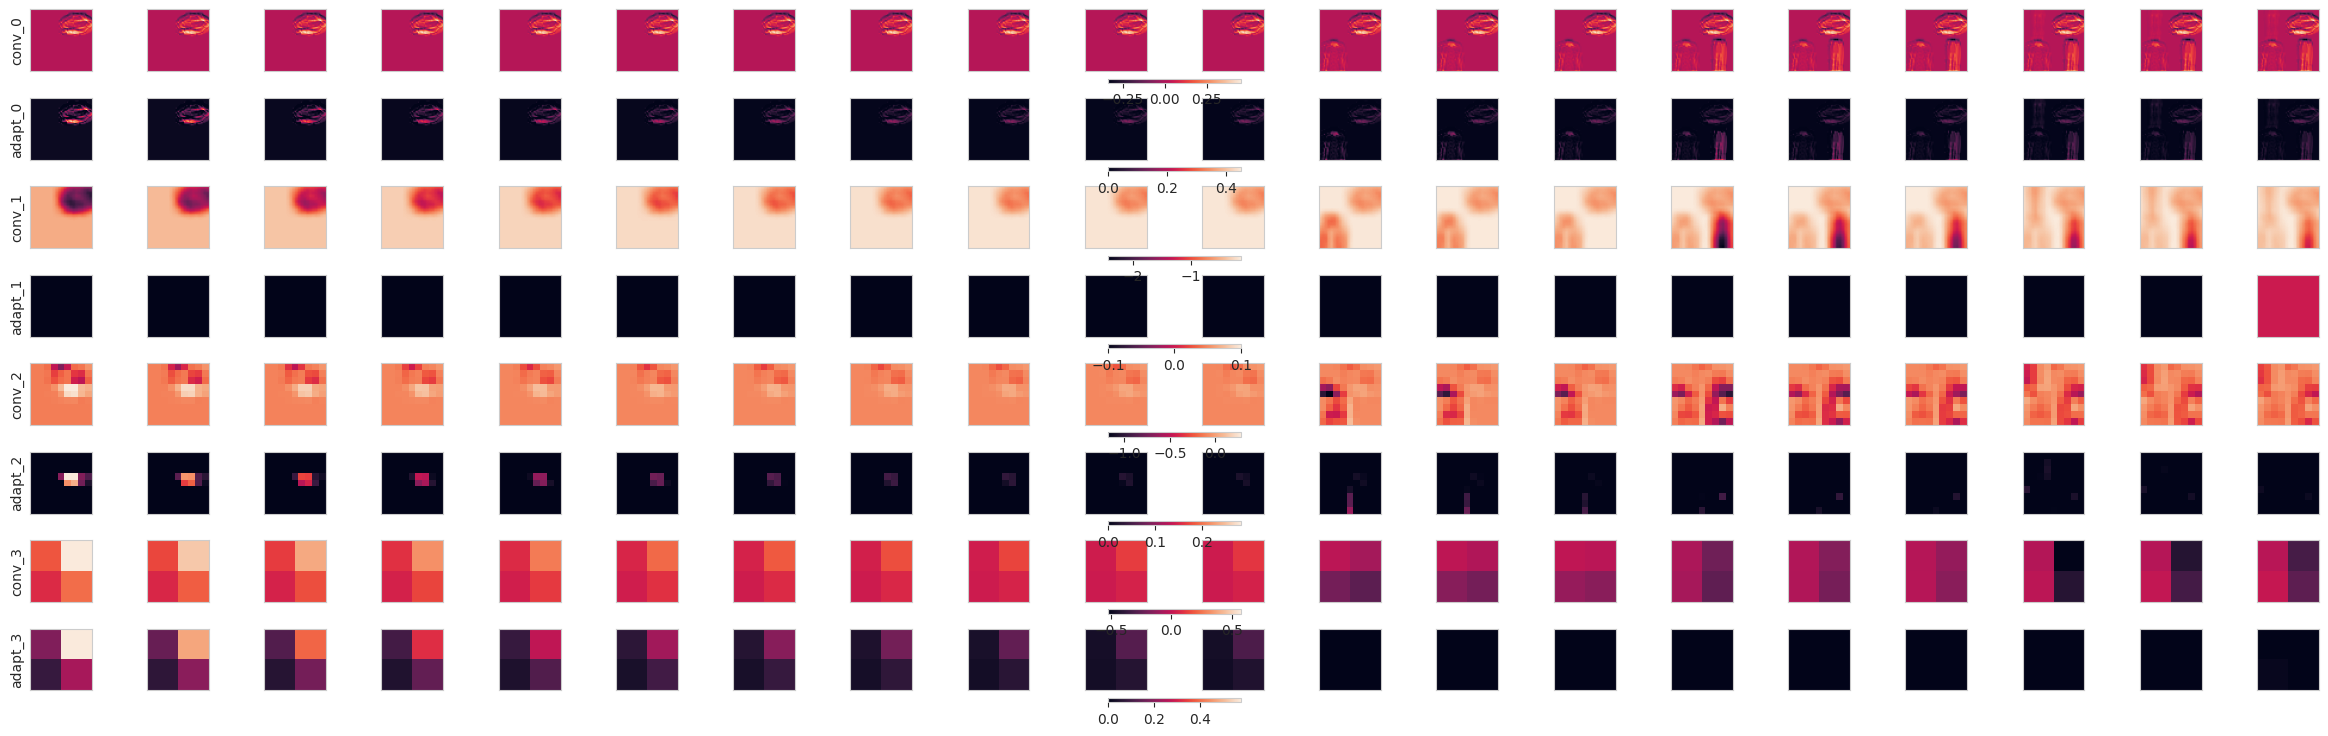

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

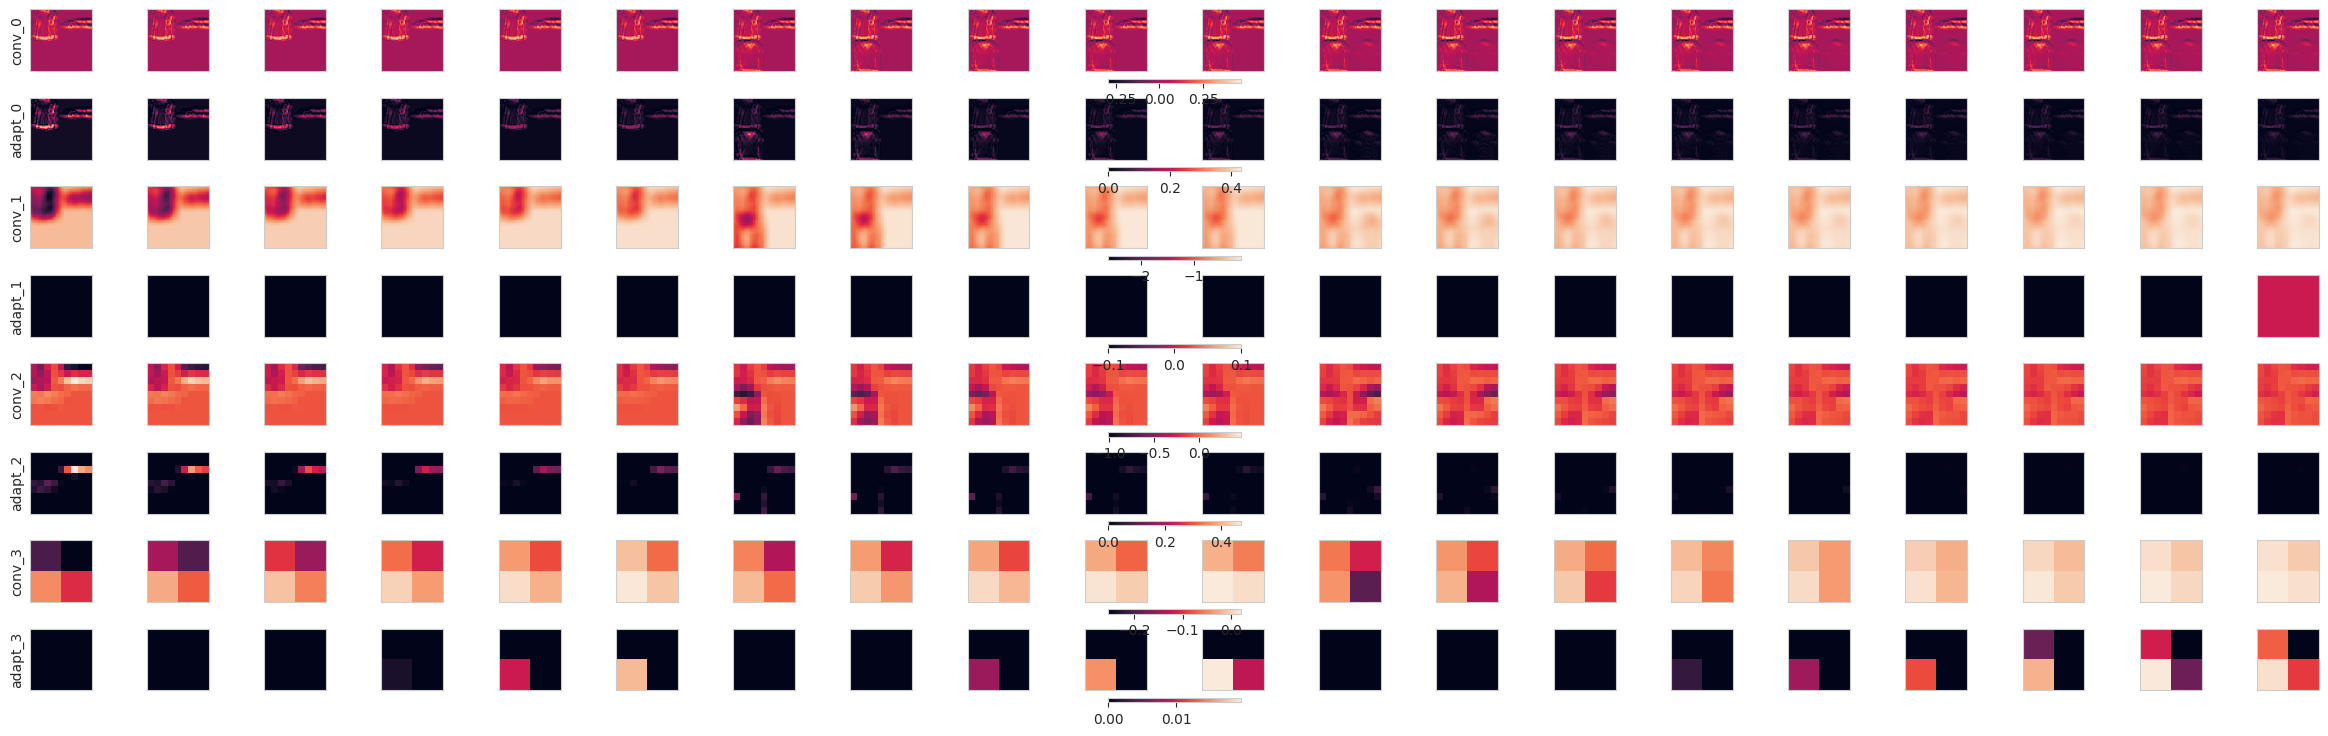

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

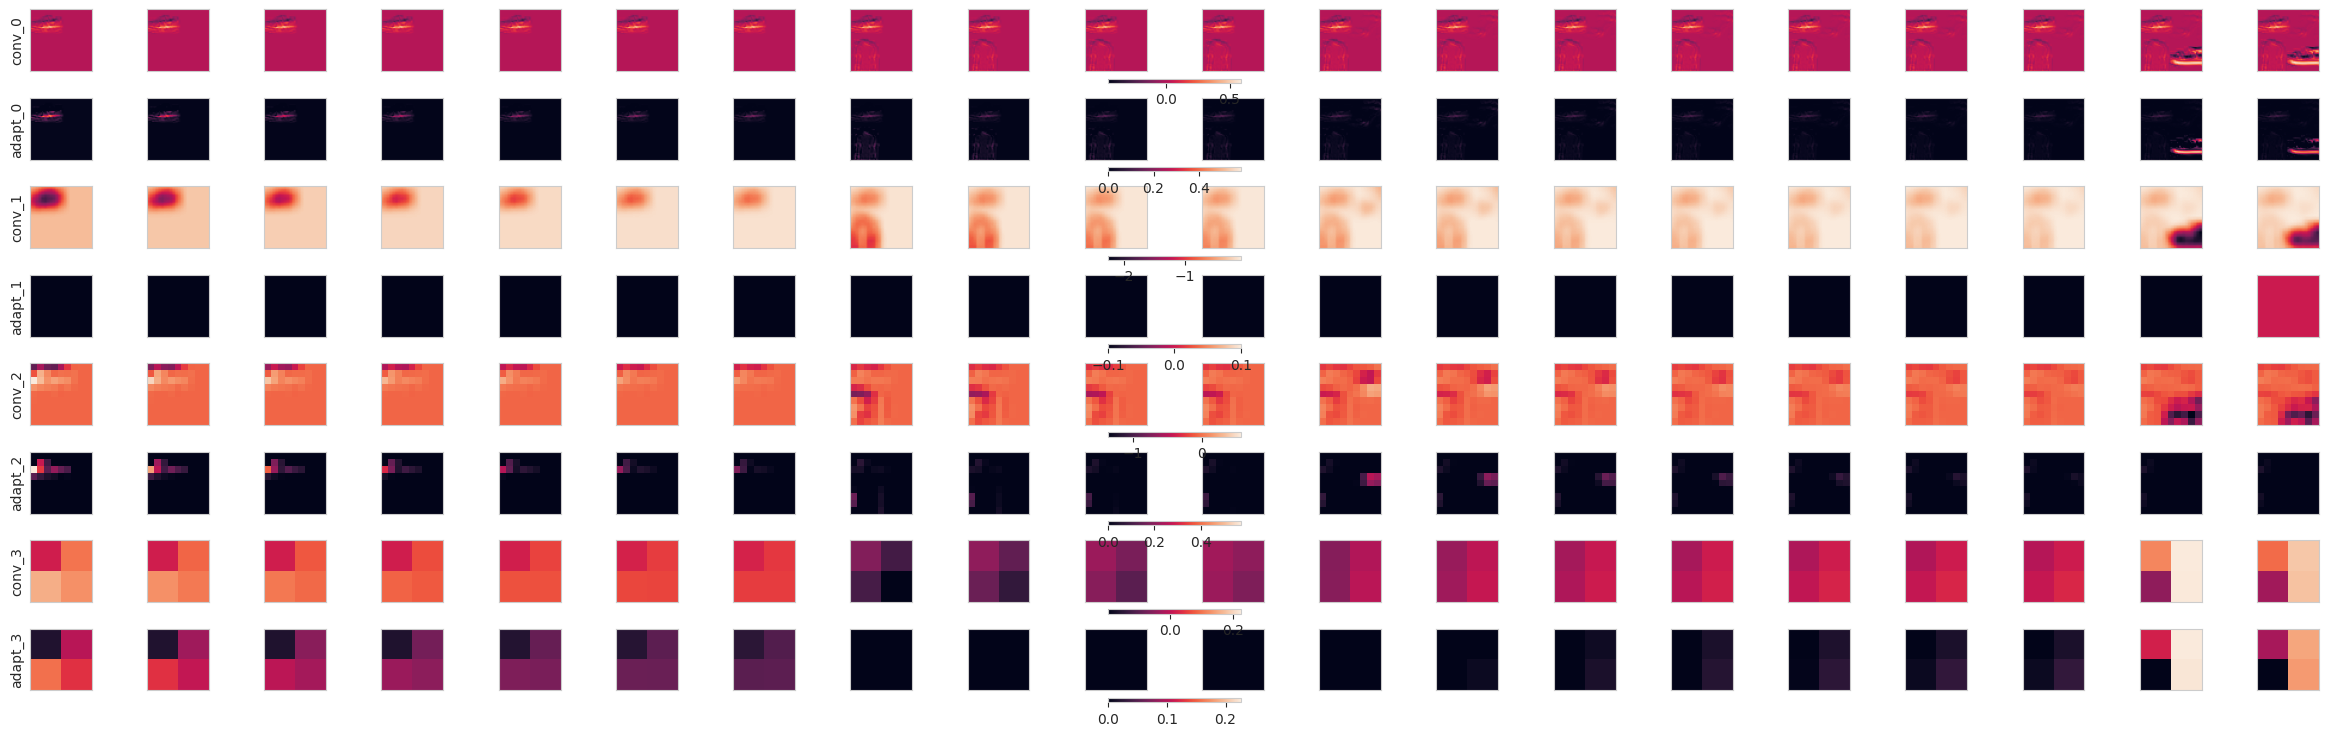

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

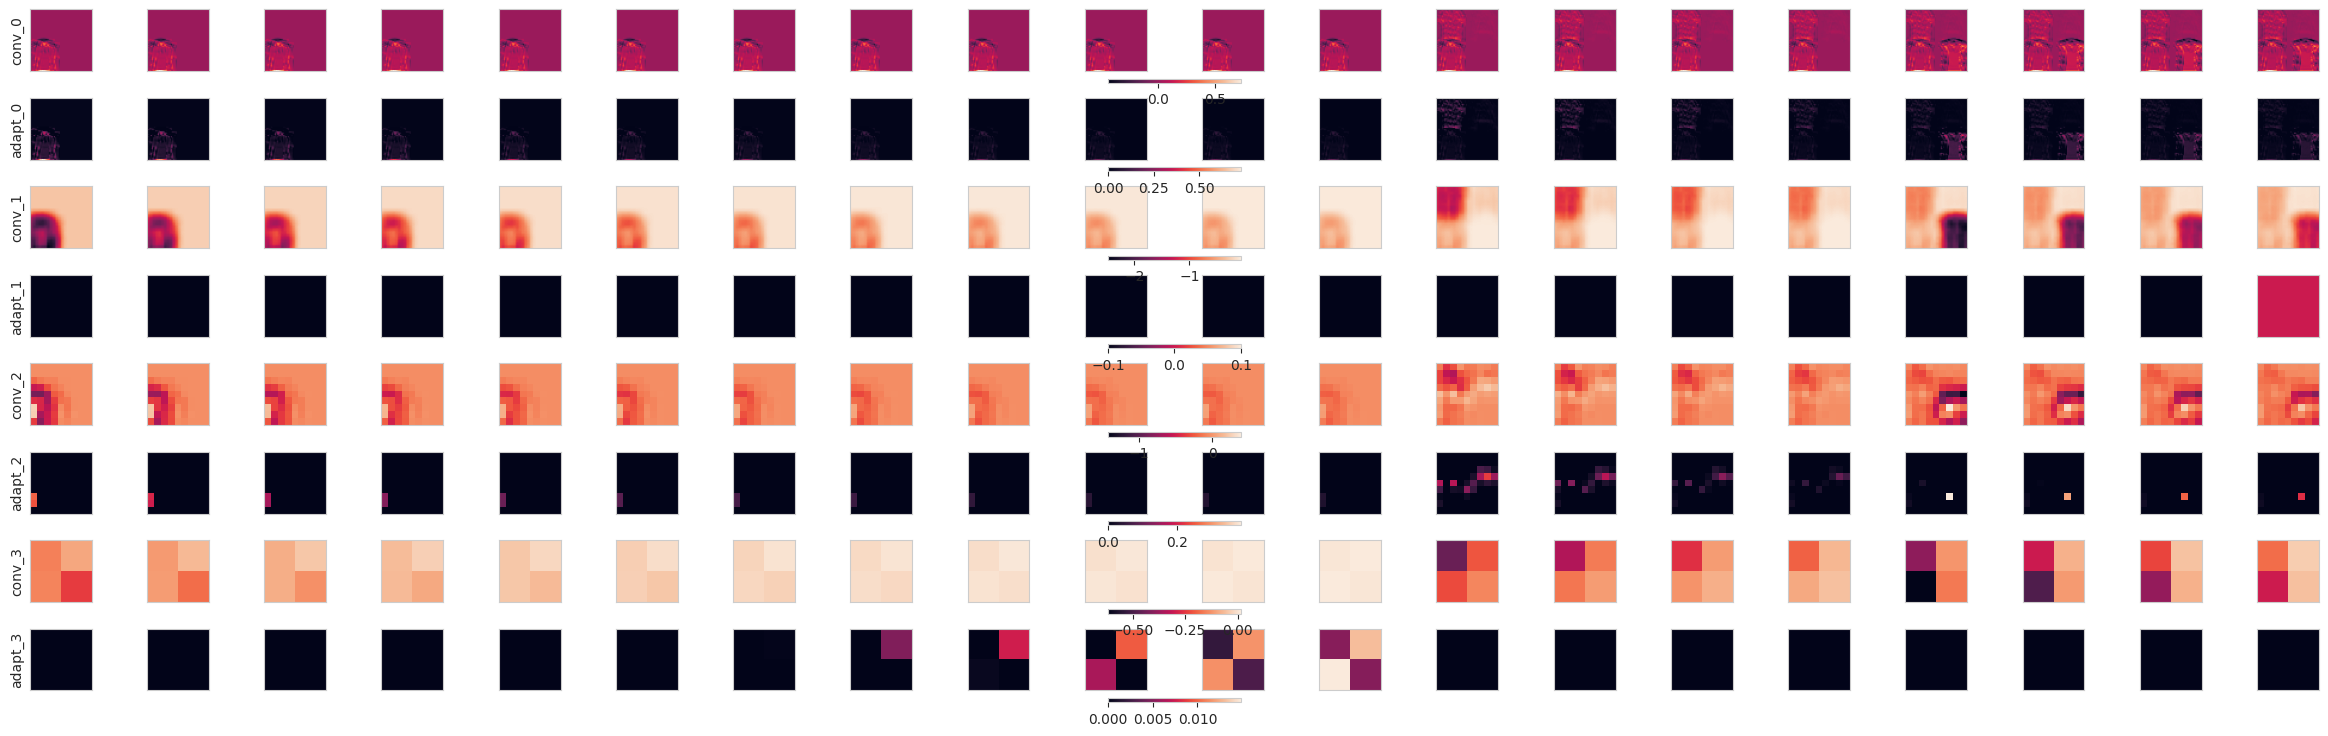

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

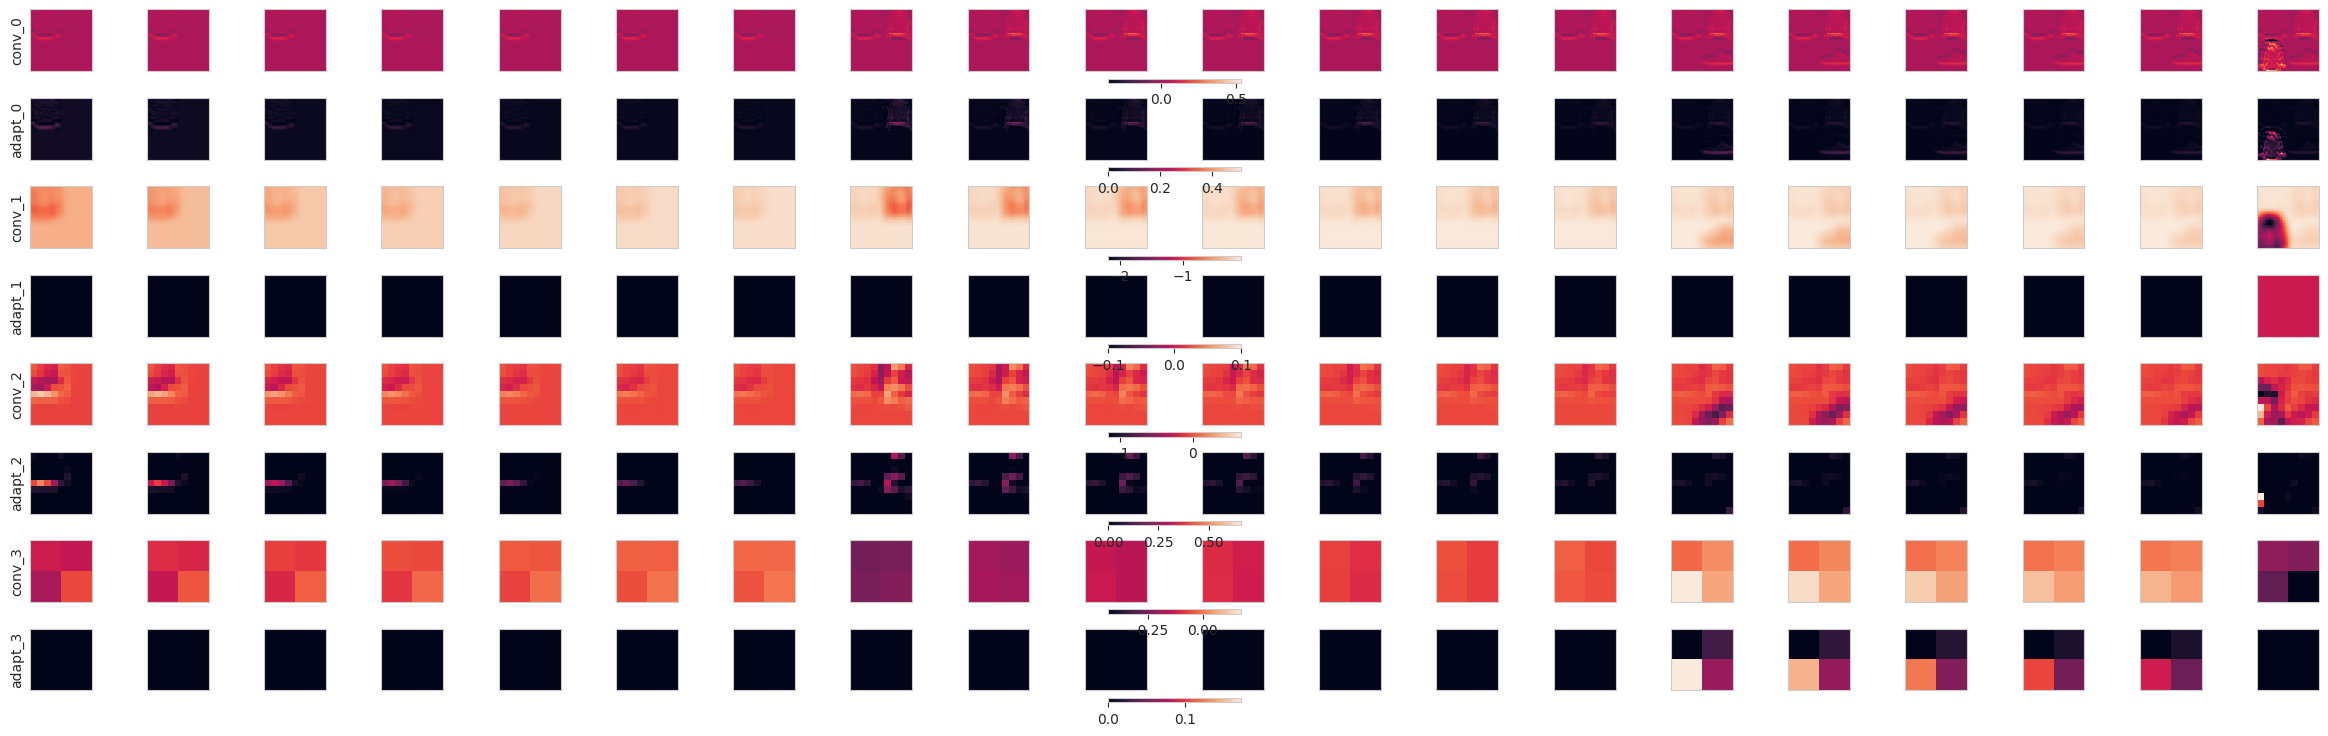

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

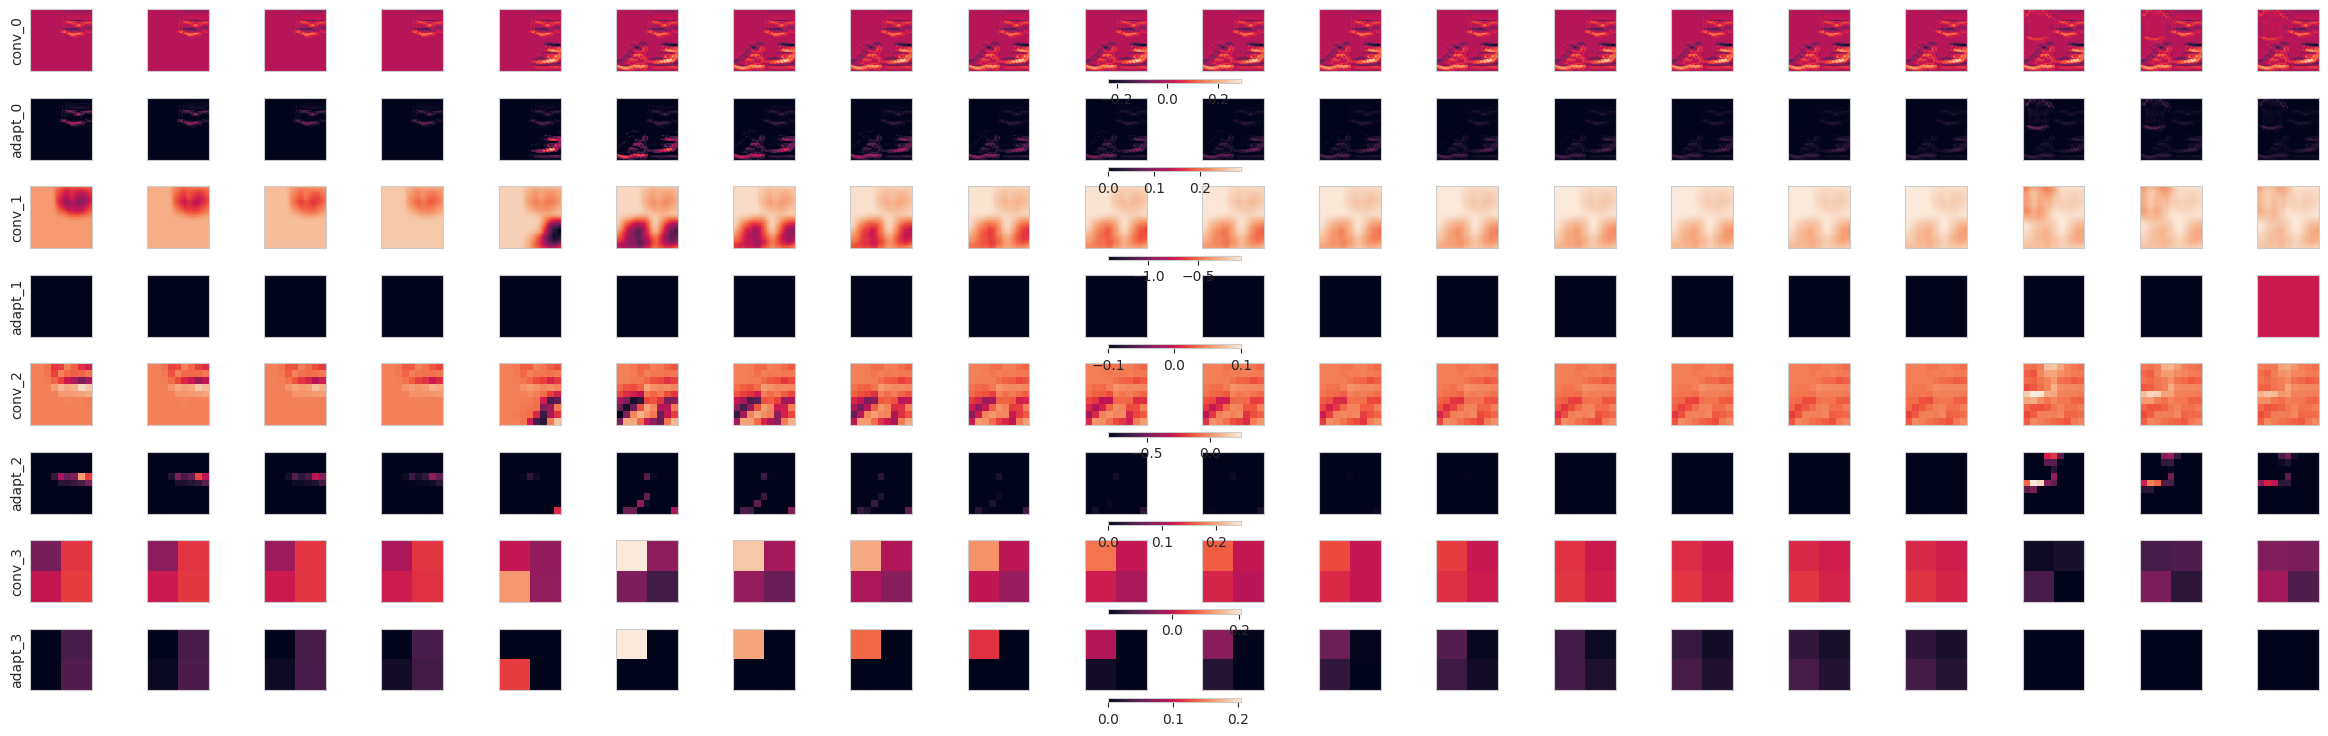

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

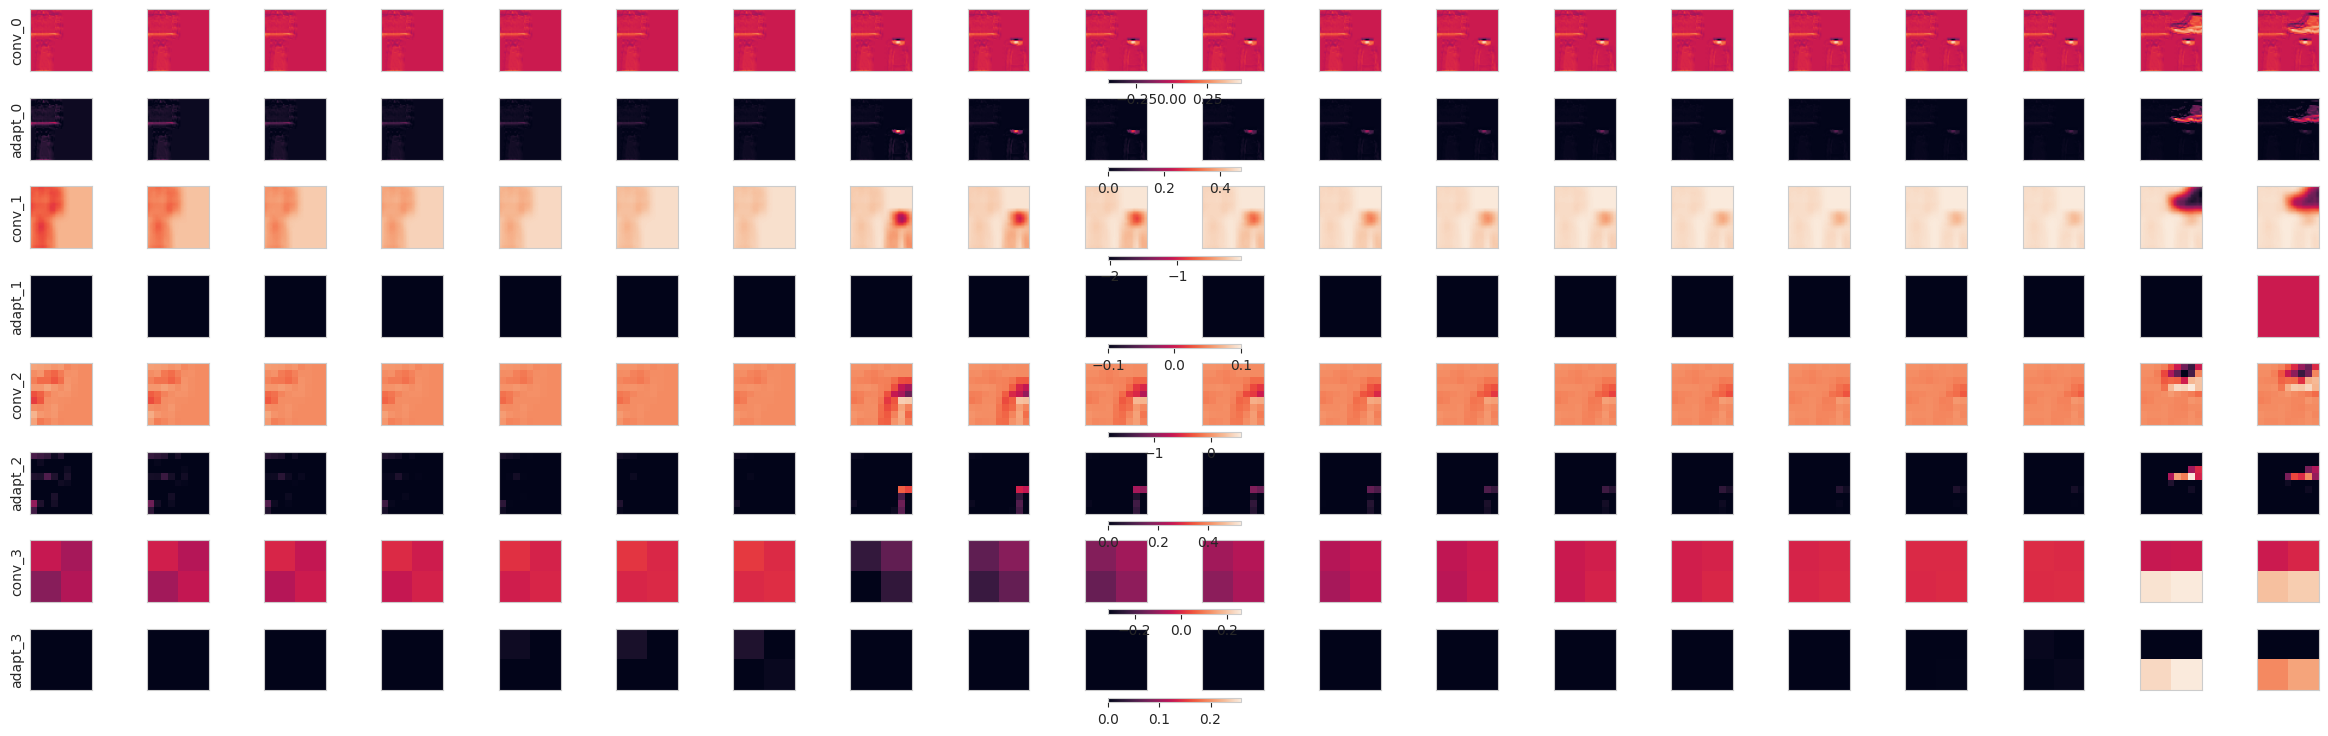

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

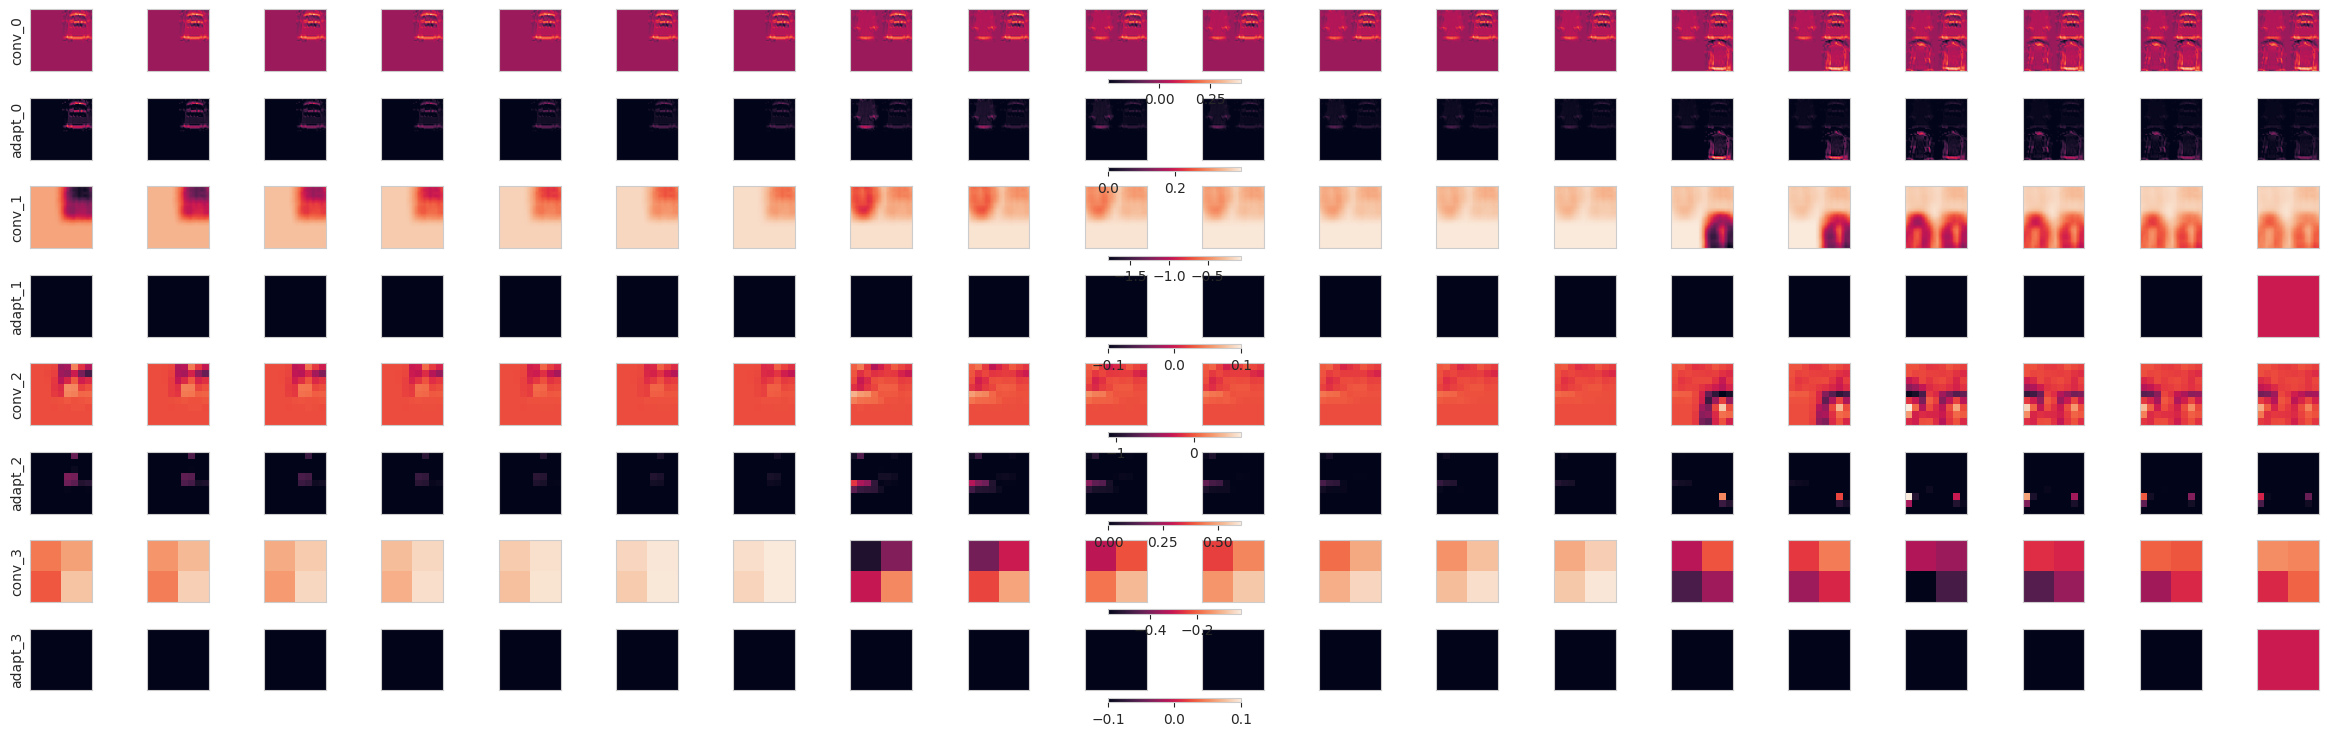

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

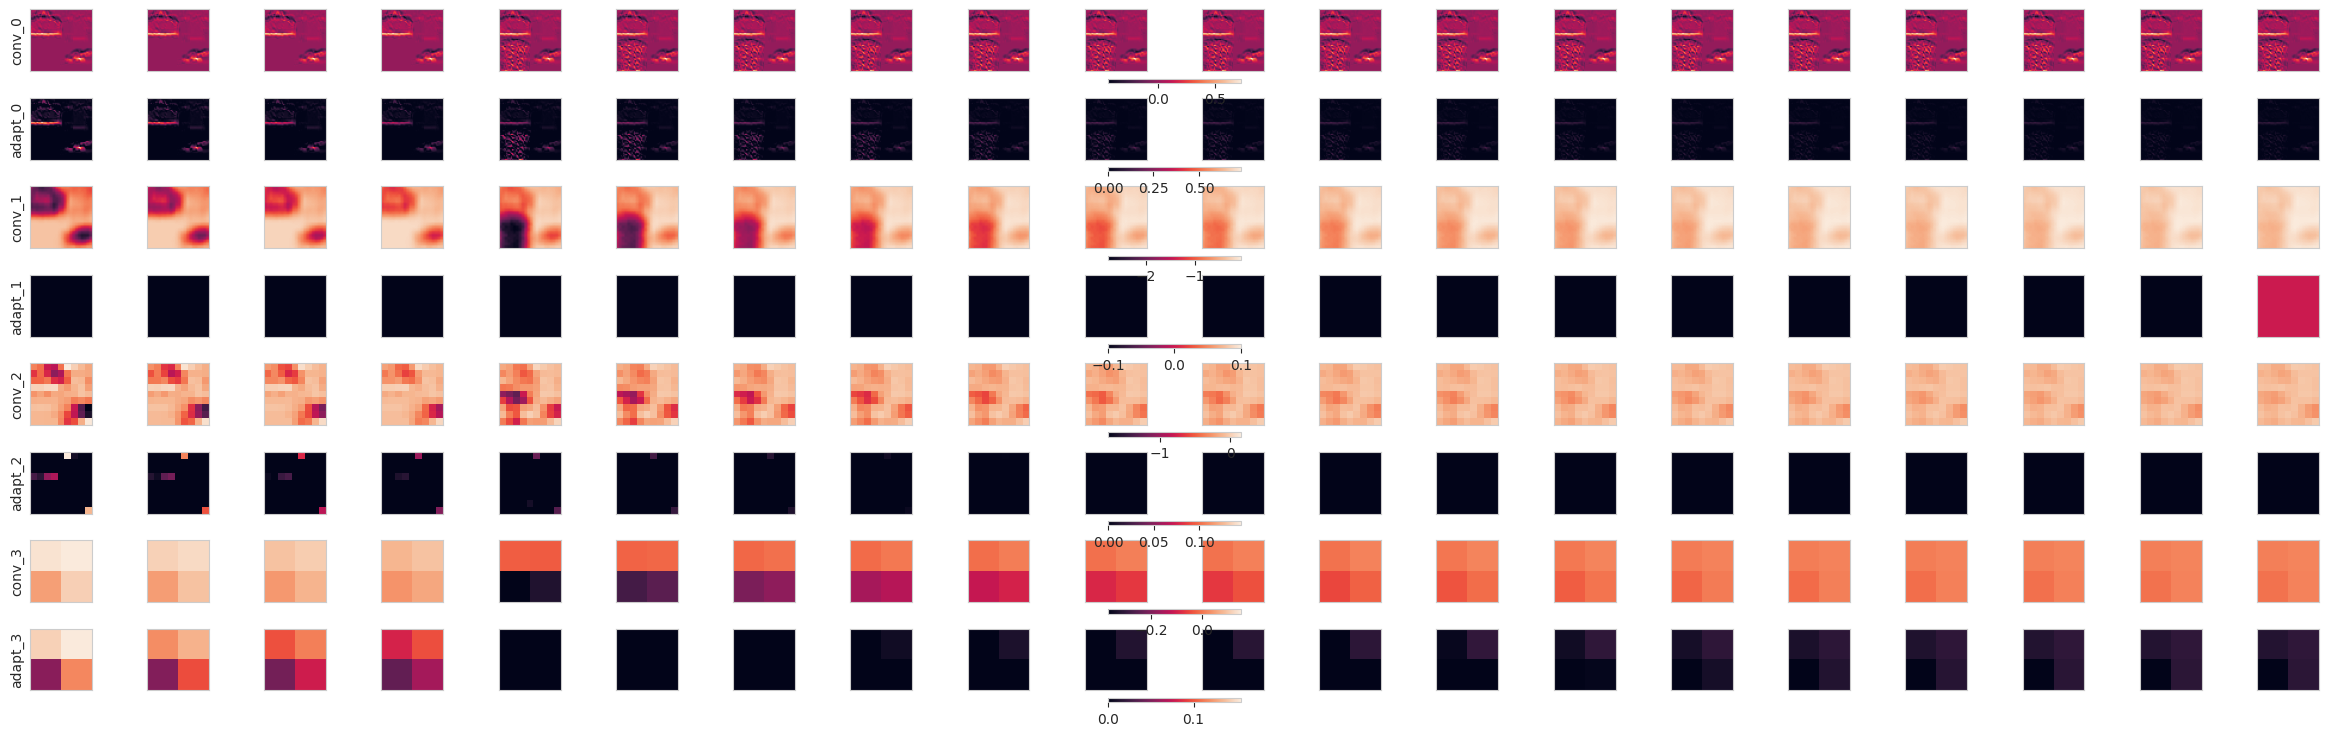

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

`Trainer.fit` stopped: `max_epochs=10` reached.


# All layers

Found cached dataset fashion_mnist (/var/local/glang/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning:

There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name                         | Type                       | Params
----------------------------------------------------------------------------
0 | model                        | HookedRecursiveCNN         | 187 K 
1 | loss                         | CrossEntropyLoss           | 0     
2 | update_to_weight_metric      | RelativeGradientUpdateNorm | 0     
3 | dead_neurons_counter         | DeadNeuronMetric          

Sanity Checking: 0it [00:00, ?it/s]

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning:

Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.



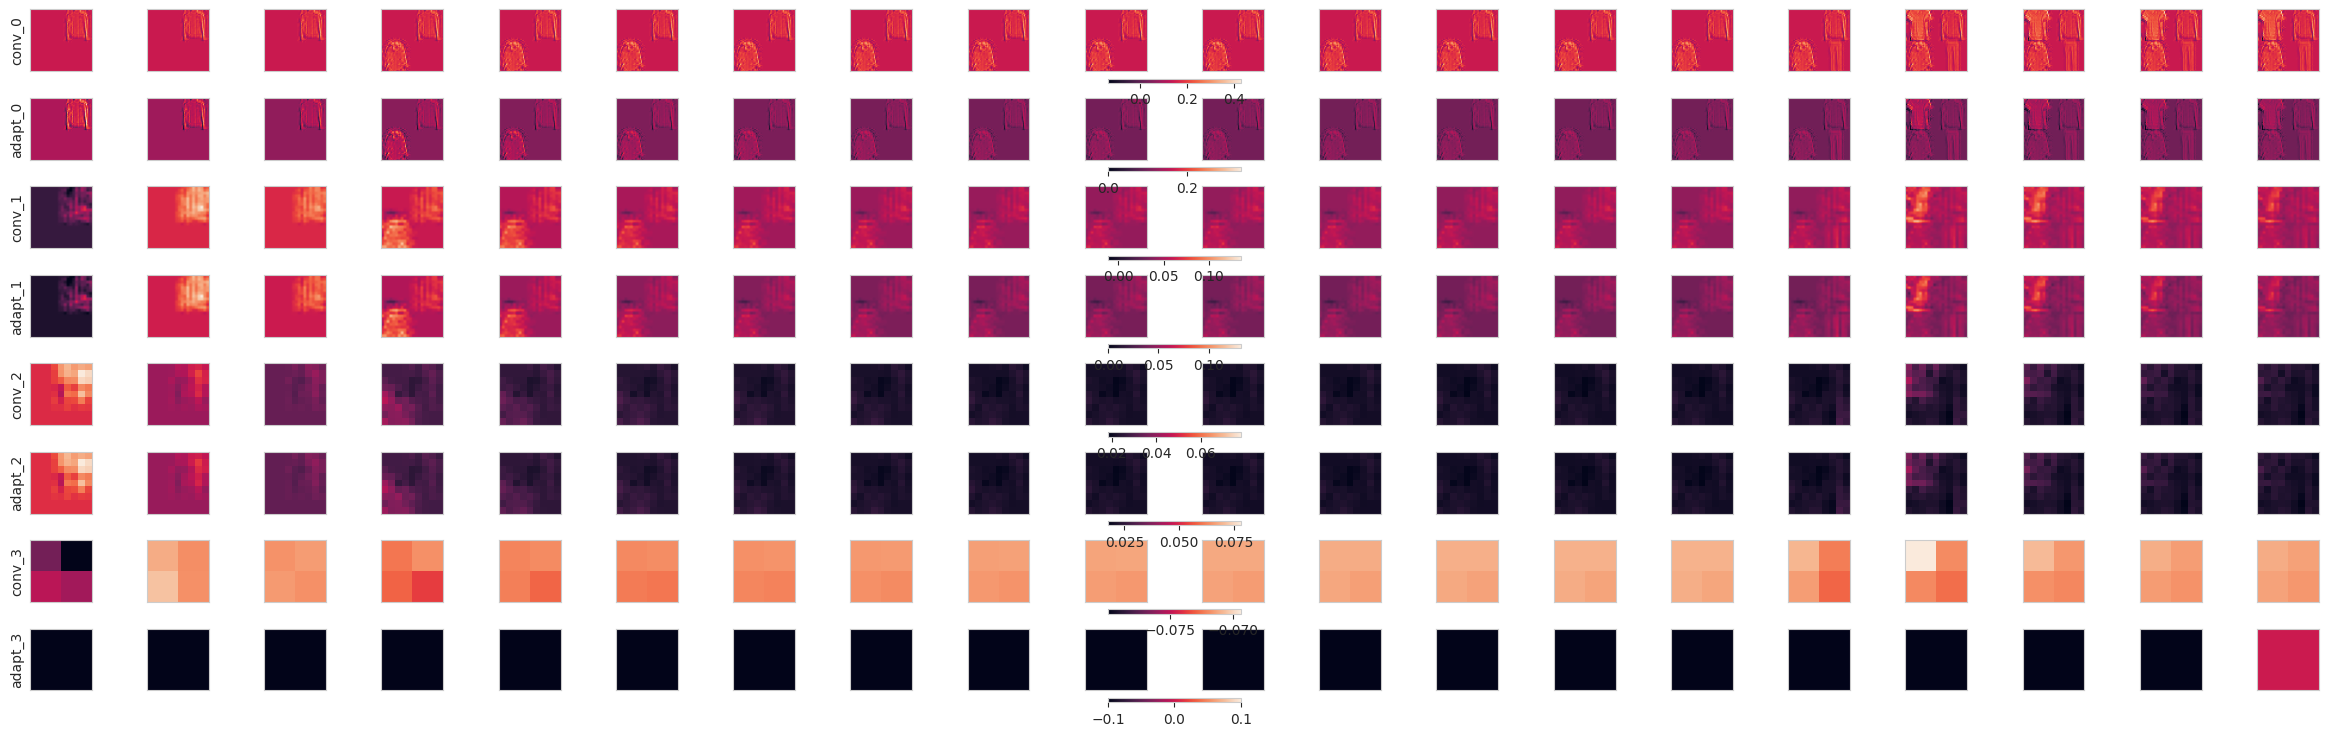

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/var/local/glang/anaconda3/envs/ai-thesis/lib/python3.10/site-packages/plotly/matplotlylib/renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Training: 0it [00:00, ?it/s]

In [ ]:
import wandb

# Create instances of the Fashion MNIST dataset
train_dataset = TemporalDataset('train', transform=transform,
                                img_to_timesteps_transforms=timestep_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)

test_loader = DataLoader(EvalDataWrapper(train_dataset, contrast=1, rep_noise=False), batch_size=64, shuffle=True,
                         num_workers=3)
config_path = 'config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

dataset = config["dataset"]
if config["dataset"] == 'fashion_mnist':
    layer_kwargs = config["layer_kwargs_fmnist"]
elif config["dataset"] == 'cifar10':
    layer_kwargs = config["layer_kwargs_cifar10"]
    
config['adaptation_module'] = 'DivisiveNorm'

# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

logger = CSVLogger(config["log_dir"], name=config["log_name"])

if config["adaptation_module"] == 'LateralRecurrence':
    adaptation_module = LateralRecurrence
    adaptation_kwargs = config["adaptation_kwargs_lateral"]
elif config["adaptation_module"] == 'ExponentialDecay':
    adaptation_module = ExponentialDecay
    adaptation_kwargs = config["adaptation_kwargs_additive"]
elif config["adaptation_module"] == 'DivisiveNorm':
    adaptation_module = DivisiveNorm
    adaptation_kwargs = config["adaptation_kwargs_div_norm"]
elif config["adaptation_module"] == 'DivisiveNormGroup':
    adaptation_module = DivisiveNormGroup
    adaptation_kwargs = config["adaptation_kwargs_div_norm_group"]
elif config["adaptation_module"] == 'DivisiveNormChannel':
    adaptation_module = DivisiveNormChannel
    adaptation_kwargs = config["adaptation_kwargs_div_norm_channel"]
else:
    raise ValueError(f'Adaptation module {config["adaptation_module"]} not implemented')

t_steps = 20

num_epoch = 10

layer_kwargs = [{'in_channels': 1, 'out_channels': 32, 'kernel_size': 5},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 5},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
                {'in_channels': 32, 'out_channels': 32, 'kernel_size': 3},
                {'in_features': 128, 'out_features': 1024}]
adaptation_kwargs = [
    {"epsilon":  1e-8, "K_init":  0.3, "train_K":  True, "alpha_init":  -1.0, "train_alpha": True, "sigma_init": 0.3, "train_sigma": True},
    {"epsilon":  1e-8, "K_init":  0.5, "train_K":  True, "alpha_init":  -1.0, "train_alpha": True, "sigma_init": 0.5, "train_sigma": True},
    {"epsilon":  1e-8, "K_init":  0.5, "train_K":  True, "alpha_init":  -1.0, "train_alpha": True, "sigma_init": 0.5, "train_sigma": True},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  -2000000.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False},
    {"epsilon":  1e-8, "K_init":  1.0, "train_K":  False, "alpha_init":  0.0, "train_alpha": False, "sigma_init": 1.0, "train_sigma": False}
  ]

hooked_model = HookedRecursiveCNN(t_steps=t_steps, layer_kwargs=layer_kwargs,
                                  adaptation_module=adaptation_module,
                                  adaptation_kwargs=adaptation_kwargs, decode_every_timestep=True)
model = Adaptation(hooked_model, lr=config["lr"], contrast_metrics=False)

contrast = 'random'
tb_logger = TensorBoardLogger("lightning_logs",
                              name=f'video_{config["adaptation_module"]}_001',
                              version=f'videon_{config["adaptation_module"]}_001')

wandb.finish()
wandb.init()
# wandb.init(project='ai-thesis', config=config, entity='ai-thesis', name=f'{config["log_name"]}_{config["adaptation_module"]}_c_{contrast}_rep_{repeat_noise}_ep_{num_epoch}')
wandb_logger = pl.loggers.WandbLogger(project='ai-thesis', config=config,
                                      name=f'video_fmnist_all_t_001_{config["adaptation_module"]}_c_{contrast}_ep_{num_epoch}_{config["log_name"]}')

trainer = pl.Trainer(max_epochs=num_epoch, logger=wandb_logger)
# test_results = trainer.test(model, dataloaders=test_loader)
wandb_logger.watch(hooked_model, log='all', log_freq=1000)

trainer.fit(model, train_loader, test_loader)

# test
# test_results = trainer.test(model, dataloaders=train_loader)
# logger.log_metrics({'contrast': contrast, 'epoch': num_epoch, 'repeat_noise': 'n/a',
#                     'test_acc': test_results[0]["test_acc"]})
# logger.save()

trainer.save_checkpoint(
    f'learned_models/video_fmnist_all_layers_{config["adaptation_module"]}_contrast_{contrast}_epoch_{num_epoch}.ckpt')